# Training ANN model on data

    Find best split number

In [9]:
!pip install pandas
!pip install sklearn

import pandas as pd;
import numpy as np;
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict;
from sklearn.preprocessing import MinMaxScaler;
from sklearn import metrics;
from sklearn.model_selection import TimeSeriesSplit;

import keras
from keras.models import Sequential # to initialise the NN
from keras.layers import Dense # to create layers
from keras.layers import Dropout
from keras import initializers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

mae_cv = []
mse_cv = []
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []

In [10]:
split_range = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


for i in split_range:
    # import data
    data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

    # 2018 data
    data = data.loc[data.index > 2018090000, :]

    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)

    # Divide features and labels
    X = data.iloc[:, 0:15]
    y = data.loc[:, 'Offers']
    
    X.fillna(method = 'ffill', inplace = True)
    y.fillna(method = 'ffill', inplace = True)

    X = X.round(20)
    
    # divide data into train and test with 10% test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, shuffle=False)

    # feature scaling
    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    
    def regressor_tunning(n_hidden = 5, 
                          n_neurons = 40, 
                          kernel_initializer = "he_normal",
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        model.add(Dense(units = n_neurons, input_dim = 15))
        model.add(keras.layers.LeakyReLU(alpha = 0.2))
        model.add(Dropout(rate = 0.1))
        for layer in range(n_hidden):
            model.add(Dense(n_neurons))
            model.add(keras.layers.LeakyReLU(alpha = 0.2))
            model.add(Dropout(rate = 0.1))
        model.add(Dense(units = 1, activation = 'linear'))
        optimizer = optimizers.Adamax(lr = 0.001)
        model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse', 'mae'])
        return model

    tscv = TimeSeriesSplit(n_splits = i)
    hist_list = pd.DataFrame()
    count = 1
    
    regressor = regressor_tunning()
    
    for train_index, test_index in tscv.split(X_train):
          X_train_split, X_test_split = X_train[train_index], X_train[test_index]
          y_train_split, y_test_split = y_train[train_index], y_train[test_index]
          hist = regressor.fit(X_train_split, y_train_split, batch_size = 15, epochs = 100)
          hist_list = hist_list.append(hist.history, ignore_index = True)
          print(count)
          count = count + 1

    a = []
    b = []
    
    for i in range(len(hist_list.mse)):
        a.append(np.mean(hist_list.mse[i]))
        b.append(np.mean(hist_list.mae[i]))
      
    mse_cv.append(np.mean(a))
    mae_cv.append(np.mean(b))
    
    # predict for X_test  
    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mse_error = mse(y_test, y_pred) # 1479.61335
    mae_error = mae(y_test, y_pred) # 23.1525
    
    rmse_gen.append(rmse_error)
    mse_gen.append(mse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    
    # smal adjustment
    y_test.replace(0, 0.0001,inplace = True)

    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mse_spike = mse(y_test_spike, y_pred_spike)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mse_spi.append(mse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mse_normal = mse(y_test_normal, y_pred_normal)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mse_nor.append(mse_normal)
    mae_nor.append(mae_normal)


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
67/67 [==============================] - 0s 2ms/step - loss: 16617.1152 - mse: 16617.1152 - mae: 114.7932
Epoch 2/100
67/67 [==============================] - 0s 1ms/step - loss: 6698.7241 - mse: 6698.7241 - mae: 55.3658
Epoch 3/100
67/67 [==============================] - 0s 1ms/step - loss: 3948.5432 - mse: 3948.5432 - mae: 33.5642
Epoch 4/100
67/67 [==============================] - 0s 1ms/step - loss: 4061.4592 - mse: 4061.4592 - mae: 32.3877
Epoch 5/100
67/67 [==============================] - 0s 1ms/step - loss: 3809.1660 - mse: 3809.1660 - mae: 32.2976
Epoch 6/100
67/67 [==============================] - 0s 1ms/step - loss: 3785.7117 - mse: 3785.7117 - mae: 31.8002
Epoch 7/100
67/67 [==============================] - 0s 1ms/step - loss: 3948.5559 - mse: 3948.5554 - mae: 32.2700
Epoch 8/100
67/67 [==============================] - 0s 2ms/step - loss: 3723.4800 - mse: 3723.4800 - mae: 31.7067
Epoch 9/100
67/67 [==============================] - 0s 2ms/step - loss: 4000

67/67 [==============================] - 0s 1ms/step - loss: 3611.7148 - mse: 3611.7148 - mae: 30.0130
Epoch 72/100
67/67 [==============================] - 0s 1ms/step - loss: 3862.2678 - mse: 3862.2683 - mae: 30.3137
Epoch 73/100
67/67 [==============================] - 0s 1ms/step - loss: 3654.0181 - mse: 3654.0181 - mae: 30.0587
Epoch 74/100
67/67 [==============================] - 0s 1ms/step - loss: 3679.3652 - mse: 3679.3652 - mae: 29.1129
Epoch 75/100
67/67 [==============================] - 0s 2ms/step - loss: 3604.7681 - mse: 3604.7681 - mae: 29.9215
Epoch 76/100
67/67 [==============================] - 0s 1ms/step - loss: 3768.0078 - mse: 3768.0078 - mae: 30.3154
Epoch 77/100
67/67 [==============================] - 0s 1ms/step - loss: 3697.1021 - mse: 3697.1021 - mae: 30.0527
Epoch 78/100
67/67 [==============================] - 0s 1ms/step - loss: 3599.8445 - mse: 3599.8445 - mae: 30.1445
Epoch 79/100
67/67 [==============================] - 0s 1ms/step - loss: 3615.1873 -

133/133 [==============================] - 0s 2ms/step - loss: 2606.8186 - mse: 2606.8186 - mae: 28.2244
Epoch 42/100
133/133 [==============================] - 0s 1ms/step - loss: 2587.7219 - mse: 2587.7219 - mae: 28.3470
Epoch 43/100
133/133 [==============================] - 0s 1ms/step - loss: 2570.6882 - mse: 2570.6882 - mae: 28.0277
Epoch 44/100
133/133 [==============================] - 0s 2ms/step - loss: 2616.9399 - mse: 2616.9399 - mae: 28.6844
Epoch 45/100
133/133 [==============================] - 0s 2ms/step - loss: 2598.8572 - mse: 2598.8572 - mae: 28.5663
Epoch 46/100
133/133 [==============================] - 0s 2ms/step - loss: 2601.1860 - mse: 2601.1860 - mae: 28.4874
Epoch 47/100
133/133 [==============================] - 0s 1ms/step - loss: 2558.8403 - mse: 2558.8403 - mae: 28.3785
Epoch 48/100
133/133 [==============================] - 0s 1ms/step - loss: 2630.0830 - mse: 2630.0830 - mae: 28.8386
Epoch 49/100
133/133 [==============================] - 0s 2ms/step -

200/200 [==============================] - 0s 2ms/step - loss: 2132.3032 - mse: 2132.3032 - mae: 27.4829
Epoch 11/100
200/200 [==============================] - 0s 2ms/step - loss: 2207.2676 - mse: 2207.2676 - mae: 27.9893
Epoch 12/100
200/200 [==============================] - 0s 2ms/step - loss: 2173.9634 - mse: 2173.9634 - mae: 27.6862
Epoch 13/100
200/200 [==============================] - 0s 2ms/step - loss: 2169.4895 - mse: 2169.4895 - mae: 27.5448
Epoch 14/100
200/200 [==============================] - 0s 2ms/step - loss: 2171.3345 - mse: 2171.3345 - mae: 27.4506
Epoch 15/100
200/200 [==============================] - 0s 2ms/step - loss: 2183.0400 - mse: 2183.0400 - mae: 27.5770
Epoch 16/100
200/200 [==============================] - 0s 1ms/step - loss: 2171.5994 - mse: 2171.5994 - mae: 27.8627
Epoch 17/100
200/200 [==============================] - 0s 2ms/step - loss: 2235.6453 - mse: 2235.6453 - mae: 28.2193
Epoch 18/100
200/200 [==============================] - 0s 1ms/step -

200/200 [==============================] - 0s 2ms/step - loss: 2125.4949 - mse: 2125.4949 - mae: 27.1380
Epoch 80/100
200/200 [==============================] - 0s 2ms/step - loss: 2113.2180 - mse: 2113.2180 - mae: 27.3058
Epoch 81/100
200/200 [==============================] - 0s 1ms/step - loss: 2138.4819 - mse: 2138.4819 - mae: 27.2196
Epoch 82/100
200/200 [==============================] - 0s 1ms/step - loss: 2118.7214 - mse: 2118.7214 - mae: 26.9689
Epoch 83/100
200/200 [==============================] - 0s 2ms/step - loss: 2152.9438 - mse: 2152.9438 - mae: 27.2399
Epoch 84/100
200/200 [==============================] - 0s 1ms/step - loss: 2096.3728 - mse: 2096.3728 - mae: 26.9017
Epoch 85/100
200/200 [==============================] - 0s 1ms/step - loss: 2099.8472 - mse: 2099.8472 - mae: 26.8888
Epoch 86/100
200/200 [==============================] - 0s 1ms/step - loss: 2113.2017 - mse: 2113.2017 - mae: 26.7436
Epoch 87/100
200/200 [==============================] - 0s 1ms/step -

266/266 [==============================] - 0s 2ms/step - loss: 2567.0757 - mse: 2567.0757 - mae: 27.4117
Epoch 49/100
266/266 [==============================] - 0s 2ms/step - loss: 2616.2351 - mse: 2616.2351 - mae: 27.5917
Epoch 50/100
266/266 [==============================] - 0s 2ms/step - loss: 2582.5625 - mse: 2582.5625 - mae: 27.3295
Epoch 51/100
266/266 [==============================] - 0s 2ms/step - loss: 2604.7141 - mse: 2604.7139 - mae: 27.3902
Epoch 52/100
266/266 [==============================] - 0s 2ms/step - loss: 2552.3472 - mse: 2552.3472 - mae: 27.1164
Epoch 53/100
266/266 [==============================] - 0s 1ms/step - loss: 2565.1782 - mse: 2565.1782 - mae: 27.2126
Epoch 54/100
266/266 [==============================] - 0s 1ms/step - loss: 2557.9390 - mse: 2557.9390 - mae: 26.9968
Epoch 55/100
266/266 [==============================] - 0s 1ms/step - loss: 2606.8235 - mse: 2606.8235 - mae: 27.4900
Epoch 56/100
266/266 [==============================] - 0s 2ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
56/56 [==============================] - 0s 1ms/step - loss: 17281.7969 - mse: 17281.7969 - mae: 115.9903
Epoch 2/100
56/56 [==============================] - 0s 1ms/step - loss: 12385.6699 - mse: 12385.6699 - mae: 91.0705
Epoch 3/100
56/56 [==============================] - 0s 1ms/step - loss: 4537.1548 - mse: 4537.1548 - mae: 34.2789
Epoch 4/100
56/56 [==============================] - 0s 2ms/step - loss: 4549.0400 - mse: 4549.0400 - mae: 32.3640
Epoch 5/100
56/56 [==============================] - 0s 2ms/step - loss: 4559.0239 - mse: 4559.0239 - mae: 33.9073
Epoch 6/100
56/56 [==============================] - 0s 1ms/step - loss: 4321.9927 - mse: 4321.9927 - mae: 33.2273
Epoch 7/100
56/56 [==============================] - 0s 1ms/step - loss: 4341.7939 - mse: 4341.7939 - mae: 31.8480
Epoch 8/100
56/56 [==============================] - 0s 2ms/step - loss: 4290.1719 - mse: 4290.1719 - mae: 32.7301
Epoch 9/100
56/56 [==============================] - 0s 2ms/step - loss: 44

56/56 [==============================] - 0s 2ms/step - loss: 4078.8547 - mse: 4078.8547 - mae: 31.3190
Epoch 72/100
56/56 [==============================] - 0s 2ms/step - loss: 4012.8958 - mse: 4012.8958 - mae: 29.7501
Epoch 73/100
56/56 [==============================] - 0s 2ms/step - loss: 4173.4976 - mse: 4173.4976 - mae: 30.6441
Epoch 74/100
56/56 [==============================] - 0s 2ms/step - loss: 4178.5542 - mse: 4178.5542 - mae: 30.8814
Epoch 75/100
56/56 [==============================] - 0s 1ms/step - loss: 4116.0063 - mse: 4116.0063 - mae: 29.0938
Epoch 76/100
56/56 [==============================] - 0s 2ms/step - loss: 4197.8315 - mse: 4197.8315 - mae: 30.6532
Epoch 77/100
56/56 [==============================] - 0s 1ms/step - loss: 4247.4995 - mse: 4247.4995 - mae: 30.7107
Epoch 78/100
56/56 [==============================] - 0s 2ms/step - loss: 4136.2769 - mse: 4136.2769 - mae: 29.8568
Epoch 79/100
56/56 [==============================] - 0s 1ms/step - loss: 4055.6443 -

111/111 [==============================] - 0s 2ms/step - loss: 2890.8281 - mse: 2890.8281 - mae: 29.0210
Epoch 42/100
111/111 [==============================] - 0s 2ms/step - loss: 2848.3992 - mse: 2848.3992 - mae: 28.7268
Epoch 43/100
111/111 [==============================] - 0s 1ms/step - loss: 2830.2180 - mse: 2830.2180 - mae: 28.6569
Epoch 44/100
111/111 [==============================] - 0s 2ms/step - loss: 2825.8101 - mse: 2825.8101 - mae: 29.3802
Epoch 45/100
111/111 [==============================] - 0s 2ms/step - loss: 2777.9685 - mse: 2777.9685 - mae: 28.8382
Epoch 46/100
111/111 [==============================] - 0s 1ms/step - loss: 2833.8157 - mse: 2833.8157 - mae: 28.9168
Epoch 47/100
111/111 [==============================] - 0s 2ms/step - loss: 2773.9976 - mse: 2773.9976 - mae: 28.7956
Epoch 48/100
111/111 [==============================] - 0s 2ms/step - loss: 2820.5039 - mse: 2820.5039 - mae: 29.0875
Epoch 49/100
111/111 [==============================] - 0s 2ms/step -

167/167 [==============================] - 0s 2ms/step - loss: 2338.3911 - mse: 2338.3911 - mae: 27.8003
Epoch 11/100
167/167 [==============================] - 0s 2ms/step - loss: 2267.6206 - mse: 2267.6206 - mae: 27.8108
Epoch 12/100
167/167 [==============================] - 0s 2ms/step - loss: 2287.1267 - mse: 2287.1267 - mae: 27.5595
Epoch 13/100
167/167 [==============================] - 0s 2ms/step - loss: 2311.1394 - mse: 2311.1394 - mae: 27.5230
Epoch 14/100
167/167 [==============================] - 0s 2ms/step - loss: 2281.2515 - mse: 2281.2515 - mae: 27.4987
Epoch 15/100
167/167 [==============================] - 0s 2ms/step - loss: 2324.1470 - mse: 2324.1470 - mae: 27.8433
Epoch 16/100
167/167 [==============================] - 0s 2ms/step - loss: 2238.3718 - mse: 2238.3718 - mae: 27.2166
Epoch 17/100
167/167 [==============================] - 0s 2ms/step - loss: 2418.9417 - mse: 2418.9417 - mae: 28.0741
Epoch 18/100
167/167 [==============================] - 0s 2ms/step -

167/167 [==============================] - 0s 1ms/step - loss: 2222.1931 - mse: 2222.1931 - mae: 26.7389
Epoch 80/100
167/167 [==============================] - 0s 1ms/step - loss: 2218.9470 - mse: 2218.9470 - mae: 26.9072
Epoch 81/100
167/167 [==============================] - 0s 2ms/step - loss: 2272.9678 - mse: 2272.9678 - mae: 26.7363
Epoch 82/100
167/167 [==============================] - 0s 2ms/step - loss: 2289.5999 - mse: 2289.5999 - mae: 27.3054
Epoch 83/100
167/167 [==============================] - 0s 2ms/step - loss: 2244.7708 - mse: 2244.7708 - mae: 27.1430
Epoch 84/100
167/167 [==============================] - 0s 1ms/step - loss: 2216.6382 - mse: 2216.6382 - mae: 26.7731
Epoch 85/100
167/167 [==============================] - 0s 2ms/step - loss: 2292.3125 - mse: 2292.3125 - mae: 27.3067
Epoch 86/100
167/167 [==============================] - 0s 2ms/step - loss: 2233.8359 - mse: 2233.8359 - mae: 26.8086
Epoch 87/100
167/167 [==============================] - 0s 1ms/step -

222/222 [==============================] - 0s 2ms/step - loss: 2599.7783 - mse: 2599.7783 - mae: 26.9832
Epoch 49/100
222/222 [==============================] - 0s 2ms/step - loss: 2623.1650 - mse: 2623.1648 - mae: 27.1220
Epoch 50/100
222/222 [==============================] - 0s 1ms/step - loss: 2606.8279 - mse: 2606.8279 - mae: 27.3222
Epoch 51/100
222/222 [==============================] - 0s 1ms/step - loss: 2607.5952 - mse: 2607.5952 - mae: 27.0164
Epoch 52/100
222/222 [==============================] - 0s 2ms/step - loss: 2594.9424 - mse: 2594.9424 - mae: 26.9881
Epoch 53/100
222/222 [==============================] - 0s 2ms/step - loss: 2594.4724 - mse: 2594.4724 - mae: 27.1632
Epoch 54/100
222/222 [==============================] - 0s 1ms/step - loss: 2574.4453 - mse: 2574.4453 - mae: 27.1698
Epoch 55/100
222/222 [==============================] - 0s 2ms/step - loss: 2577.8777 - mse: 2577.8777 - mae: 27.4427
Epoch 56/100
222/222 [==============================] - 0s 2ms/step -

277/277 [==============================] - 0s 1ms/step - loss: 2534.7117 - mse: 2534.7117 - mae: 27.3679
Epoch 17/100
277/277 [==============================] - 0s 1ms/step - loss: 2599.9497 - mse: 2599.9497 - mae: 27.9230
Epoch 18/100
277/277 [==============================] - 0s 2ms/step - loss: 2551.3193 - mse: 2551.3193 - mae: 27.1317
Epoch 19/100
277/277 [==============================] - 0s 2ms/step - loss: 2549.1921 - mse: 2549.1921 - mae: 27.3278
Epoch 20/100
277/277 [==============================] - 0s 2ms/step - loss: 2555.4866 - mse: 2555.4866 - mae: 27.1374
Epoch 21/100
277/277 [==============================] - 0s 2ms/step - loss: 2562.1067 - mse: 2562.1067 - mae: 27.4415
Epoch 22/100
277/277 [==============================] - 0s 2ms/step - loss: 2556.6853 - mse: 2556.6853 - mae: 27.4419
Epoch 23/100
277/277 [==============================] - 0s 2ms/step - loss: 2536.9780 - mse: 2536.9780 - mae: 27.2704
Epoch 24/100
277/277 [==============================] - 0s 2ms/step -

277/277 [==============================] - 0s 1ms/step - loss: 2465.9404 - mse: 2465.9404 - mae: 26.7095
Epoch 86/100
277/277 [==============================] - 0s 2ms/step - loss: 2502.4243 - mse: 2502.4243 - mae: 27.1071
Epoch 87/100
277/277 [==============================] - 0s 2ms/step - loss: 2499.0488 - mse: 2499.0488 - mae: 26.9225
Epoch 88/100
277/277 [==============================] - 0s 2ms/step - loss: 2519.5144 - mse: 2519.5144 - mae: 27.1928
Epoch 89/100
277/277 [==============================] - 0s 2ms/step - loss: 2489.9219 - mse: 2489.9219 - mae: 26.5806
Epoch 90/100
277/277 [==============================] - 0s 1ms/step - loss: 2479.3818 - mse: 2479.3818 - mae: 26.9271
Epoch 91/100
277/277 [==============================] - 0s 1ms/step - loss: 2528.5747 - mse: 2528.5747 - mae: 27.0660
Epoch 92/100
277/277 [==============================] - 1s 2ms/step - loss: 2502.4036 - mse: 2502.4036 - mae: 26.9008
Epoch 93/100
277/277 [==============================] - 0s 2ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
48/48 [==============================] - 0s 1ms/step - loss: 17046.6738 - mse: 17046.6738 - mae: 113.7233
Epoch 2/100
48/48 [==============================] - 0s 1ms/step - loss: 13629.7656 - mse: 13629.7656 - mae: 97.3324
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 6027.9487 - mse: 6027.9487 - mae: 42.0055
Epoch 4/100
48/48 [==============================] - 0s 1ms/step - loss: 4457.4302 - mse: 4457.4302 - mae: 31.1819
Epoch 5/100
48/48 [==============================] - 0s 1ms/step - loss: 4429.7710 - mse: 4429.7710 - mae: 28.7041
Epoch 6/100
48/48 [==============================] - 0s 1ms/step - loss: 4500.5024 - mse: 4500.5024 - mae: 30.5393
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 4451.8408 - mse: 4451.8408 - mae: 29.3392
Epoch 8/100
48/48 [==============================] - 0s 1ms/step - loss: 4436.9312 - mse: 4436.9312 - mae: 29.2352
Epoch 9/100
48/48 [==============================] - 0s 1ms/step - loss: 43

48/48 [==============================] - 0s 2ms/step - loss: 4317.9834 - mse: 4317.9834 - mae: 28.4049
Epoch 72/100
48/48 [==============================] - 0s 2ms/step - loss: 4443.5493 - mse: 4443.5493 - mae: 28.8942
Epoch 73/100
48/48 [==============================] - 0s 2ms/step - loss: 4471.5142 - mse: 4471.5142 - mae: 29.1787
Epoch 74/100
48/48 [==============================] - 0s 2ms/step - loss: 4336.6108 - mse: 4336.6104 - mae: 28.6089
Epoch 75/100
48/48 [==============================] - 0s 1ms/step - loss: 4463.1699 - mse: 4463.1699 - mae: 28.8627
Epoch 76/100
48/48 [==============================] - 0s 1ms/step - loss: 4425.0083 - mse: 4425.0083 - mae: 28.2986
Epoch 77/100
48/48 [==============================] - 0s 1ms/step - loss: 4303.0840 - mse: 4303.0840 - mae: 28.9049
Epoch 78/100
48/48 [==============================] - 0s 1ms/step - loss: 4270.4707 - mse: 4270.4707 - mae: 28.4016
Epoch 79/100
48/48 [==============================] - 0s 1ms/step - loss: 4352.7129 -

95/95 [==============================] - 0s 2ms/step - loss: 3064.0183 - mse: 3064.0183 - mae: 29.6147
Epoch 42/100
95/95 [==============================] - 0s 2ms/step - loss: 3020.9822 - mse: 3020.9822 - mae: 28.3786
Epoch 43/100
95/95 [==============================] - 0s 2ms/step - loss: 3034.9431 - mse: 3034.9431 - mae: 28.6355
Epoch 44/100
95/95 [==============================] - 0s 2ms/step - loss: 2982.0654 - mse: 2982.0654 - mae: 28.8118
Epoch 45/100
95/95 [==============================] - 0s 2ms/step - loss: 2962.4814 - mse: 2962.4814 - mae: 29.0298
Epoch 46/100
95/95 [==============================] - 0s 2ms/step - loss: 3005.6316 - mse: 3005.6316 - mae: 29.4582
Epoch 47/100
95/95 [==============================] - 0s 2ms/step - loss: 3003.5017 - mse: 3003.5017 - mae: 28.6960
Epoch 48/100
95/95 [==============================] - 0s 2ms/step - loss: 3028.3928 - mse: 3028.3928 - mae: 29.0744
Epoch 49/100
95/95 [==============================] - 0s 2ms/step - loss: 3016.1572 -

143/143 [==============================] - 0s 2ms/step - loss: 2574.2761 - mse: 2574.2761 - mae: 28.8616
Epoch 12/100
143/143 [==============================] - 0s 2ms/step - loss: 2500.7241 - mse: 2500.7241 - mae: 28.0730
Epoch 13/100
143/143 [==============================] - 0s 2ms/step - loss: 2510.9221 - mse: 2510.9221 - mae: 28.2323
Epoch 14/100
143/143 [==============================] - 0s 2ms/step - loss: 2491.8369 - mse: 2491.8369 - mae: 28.0005
Epoch 15/100
143/143 [==============================] - 0s 2ms/step - loss: 2462.6199 - mse: 2462.6199 - mae: 27.7847
Epoch 16/100
143/143 [==============================] - 0s 2ms/step - loss: 2465.0569 - mse: 2465.0569 - mae: 27.9841
Epoch 17/100
143/143 [==============================] - 0s 1ms/step - loss: 2508.4338 - mse: 2508.4338 - mae: 28.2063
Epoch 18/100
143/143 [==============================] - 0s 1ms/step - loss: 2548.9629 - mse: 2548.9629 - mae: 28.0003
Epoch 19/100
143/143 [==============================] - 0s 1ms/step -

143/143 [==============================] - 0s 2ms/step - loss: 2456.1685 - mse: 2456.1685 - mae: 27.7856: 0s - loss: 3401.5725 - mse: 3401.5725 - mae: 2
Epoch 80/100
143/143 [==============================] - 0s 2ms/step - loss: 2433.6863 - mse: 2433.6863 - mae: 27.3568
Epoch 81/100
143/143 [==============================] - 0s 1ms/step - loss: 2446.3403 - mse: 2446.3403 - mae: 27.5721
Epoch 82/100
143/143 [==============================] - 0s 2ms/step - loss: 2457.2400 - mse: 2457.2400 - mae: 27.3289
Epoch 83/100
143/143 [==============================] - 0s 2ms/step - loss: 2469.7219 - mse: 2469.7219 - mae: 28.0337
Epoch 84/100
143/143 [==============================] - 0s 2ms/step - loss: 2425.5652 - mse: 2425.5652 - mae: 27.3175
Epoch 85/100
143/143 [==============================] - 0s 2ms/step - loss: 2456.0239 - mse: 2456.0239 - mae: 27.9137
Epoch 86/100
143/143 [==============================] - 0s 2ms/step - loss: 2484.1655 - mse: 2484.1655 - mae: 27.4264
Epoch 87/100
143/143 

190/190 [==============================] - 0s 2ms/step - loss: 2110.6472 - mse: 2110.6472 - mae: 26.8669
Epoch 48/100
190/190 [==============================] - 0s 1ms/step - loss: 2090.9314 - mse: 2090.9314 - mae: 26.4146
Epoch 49/100
190/190 [==============================] - 0s 2ms/step - loss: 2130.0046 - mse: 2130.0046 - mae: 27.0160
Epoch 50/100
190/190 [==============================] - 0s 2ms/step - loss: 2121.0398 - mse: 2121.0398 - mae: 27.0373
Epoch 51/100
190/190 [==============================] - 0s 2ms/step - loss: 2126.7122 - mse: 2126.7122 - mae: 26.8468
Epoch 52/100
190/190 [==============================] - 0s 2ms/step - loss: 2106.2629 - mse: 2106.2629 - mae: 26.5622
Epoch 53/100
190/190 [==============================] - 0s 1ms/step - loss: 2122.3037 - mse: 2122.3037 - mae: 26.8352
Epoch 54/100
190/190 [==============================] - 0s 1ms/step - loss: 2124.1772 - mse: 2124.1772 - mae: 26.4147
Epoch 55/100
190/190 [==============================] - 0s 2ms/step -

238/238 [==============================] - 0s 2ms/step - loss: 2469.8962 - mse: 2469.8962 - mae: 26.3850
Epoch 17/100
238/238 [==============================] - 0s 2ms/step - loss: 2461.9609 - mse: 2461.9609 - mae: 26.5905
Epoch 18/100
238/238 [==============================] - 0s 1ms/step - loss: 2478.0947 - mse: 2478.0947 - mae: 26.6116
Epoch 19/100
238/238 [==============================] - 0s 1ms/step - loss: 2510.3489 - mse: 2510.3489 - mae: 26.8202
Epoch 20/100
238/238 [==============================] - 0s 2ms/step - loss: 2542.1055 - mse: 2542.1055 - mae: 26.4971
Epoch 21/100
238/238 [==============================] - 0s 2ms/step - loss: 2502.1592 - mse: 2502.1592 - mae: 26.6977
Epoch 22/100
238/238 [==============================] - 0s 2ms/step - loss: 2513.3362 - mse: 2513.3362 - mae: 26.6531
Epoch 23/100
238/238 [==============================] - 0s 2ms/step - loss: 2468.6272 - mse: 2468.6272 - mae: 26.4546
Epoch 24/100
238/238 [==============================] - 0s 2ms/step -

238/238 [==============================] - 0s 2ms/step - loss: 2453.6394 - mse: 2453.6394 - mae: 26.6083
Epoch 86/100
238/238 [==============================] - 0s 2ms/step - loss: 2464.6121 - mse: 2464.6121 - mae: 26.3032
Epoch 87/100
238/238 [==============================] - 0s 2ms/step - loss: 2444.1973 - mse: 2444.1973 - mae: 26.3890
Epoch 88/100
238/238 [==============================] - 0s 2ms/step - loss: 2455.7454 - mse: 2455.7454 - mae: 26.1863
Epoch 89/100
238/238 [==============================] - 0s 2ms/step - loss: 2414.9446 - mse: 2414.9446 - mae: 26.2511
Epoch 90/100
238/238 [==============================] - 0s 2ms/step - loss: 2448.2817 - mse: 2448.2817 - mae: 26.1127
Epoch 91/100
238/238 [==============================] - 0s 2ms/step - loss: 2445.8313 - mse: 2445.8313 - mae: 26.4491
Epoch 92/100
238/238 [==============================] - 0s 2ms/step - loss: 2462.4890 - mse: 2462.4890 - mae: 26.5066
Epoch 93/100
238/238 [==============================] - 0s 2ms/step -

285/285 [==============================] - 1s 2ms/step - loss: 2436.5337 - mse: 2436.5337 - mae: 26.3702
Epoch 54/100
285/285 [==============================] - 1s 2ms/step - loss: 2411.6160 - mse: 2411.6160 - mae: 26.5885
Epoch 55/100
285/285 [==============================] - 1s 3ms/step - loss: 2434.4331 - mse: 2434.4331 - mae: 26.5695
Epoch 56/100
285/285 [==============================] - 0s 2ms/step - loss: 2442.3110 - mse: 2442.3110 - mae: 26.5316
Epoch 57/100
285/285 [==============================] - 1s 2ms/step - loss: 2420.1948 - mse: 2420.1948 - mae: 26.6377
Epoch 58/100
285/285 [==============================] - 0s 2ms/step - loss: 2452.9607 - mse: 2452.9609 - mae: 26.6176
Epoch 59/100
285/285 [==============================] - 1s 2ms/step - loss: 2403.7302 - mse: 2403.7302 - mae: 26.4788
Epoch 60/100
285/285 [==============================] - 0s 2ms/step - loss: 2449.3491 - mse: 2449.3491 - mae: 26.9131
Epoch 61/100
285/285 [==============================] - 1s 2ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
42/42 [==============================] - 0s 1ms/step - loss: 17538.8359 - mse: 17538.8359 - mae: 114.1778
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 15466.1758 - mse: 15466.1758 - mae: 104.4552
Epoch 3/100
42/42 [==============================] - 0s 1ms/step - loss: 7226.2231 - mse: 7226.2231 - mae: 50.0163
Epoch 4/100
42/42 [==============================] - 0s 1ms/step - loss: 4762.0122 - mse: 4762.0122 - mae: 30.9856
Epoch 5/100
42/42 [==============================] - 0s 1ms/step - loss: 4999.0962 - mse: 4999.0962 - mae: 29.6355
Epoch 6/100
42/42 [==============================] - 0s 1ms/step - loss: 4814.6860 - mse: 4814.6860 - mae: 30.3665
Epoch 7/100
42/42 [==============================] - 0s 1ms/step - loss: 4869.5581 - mse: 4869.5581 - mae: 31.5801
Epoch 8/100
42/42 [==============================] - 0s 1ms/step - loss: 4872.3833 - mse: 4872.3833 - mae: 30.5914
Epoch 9/100
42/42 [==============================] - 0s 1ms/step - loss: 5

42/42 [==============================] - 0s 2ms/step - loss: 4625.3296 - mse: 4625.3296 - mae: 29.1210
Epoch 72/100
42/42 [==============================] - 0s 1ms/step - loss: 4772.2886 - mse: 4772.2886 - mae: 30.3991
Epoch 73/100
42/42 [==============================] - 0s 1ms/step - loss: 4778.8325 - mse: 4778.8325 - mae: 29.1836
Epoch 74/100
42/42 [==============================] - 0s 1ms/step - loss: 4794.4409 - mse: 4794.4409 - mae: 30.1106
Epoch 75/100
42/42 [==============================] - 0s 1ms/step - loss: 4749.0742 - mse: 4749.0742 - mae: 30.2613
Epoch 76/100
42/42 [==============================] - 0s 1ms/step - loss: 4890.9097 - mse: 4890.9097 - mae: 29.6315
Epoch 77/100
42/42 [==============================] - 0s 1ms/step - loss: 4698.5474 - mse: 4698.5474 - mae: 28.5656
Epoch 78/100
42/42 [==============================] - 0s 1ms/step - loss: 4731.3921 - mse: 4731.3921 - mae: 29.7578
Epoch 79/100
42/42 [==============================] - 0s 1ms/step - loss: 4652.7480 -

84/84 [==============================] - 0s 1ms/step - loss: 3349.1423 - mse: 3349.1423 - mae: 30.2891
Epoch 42/100
84/84 [==============================] - 0s 1ms/step - loss: 3419.1897 - mse: 3419.1897 - mae: 29.9449
Epoch 43/100
84/84 [==============================] - 0s 2ms/step - loss: 3342.0293 - mse: 3342.0293 - mae: 30.5051
Epoch 44/100
84/84 [==============================] - 0s 2ms/step - loss: 3396.7261 - mse: 3396.7261 - mae: 30.3912
Epoch 45/100
84/84 [==============================] - 0s 2ms/step - loss: 3339.6709 - mse: 3339.6709 - mae: 30.2424
Epoch 46/100
84/84 [==============================] - 0s 2ms/step - loss: 3422.8203 - mse: 3422.8203 - mae: 30.4461
Epoch 47/100
84/84 [==============================] - 0s 1ms/step - loss: 3402.8601 - mse: 3402.8601 - mae: 30.4633
Epoch 48/100
84/84 [==============================] - 0s 1ms/step - loss: 3364.8818 - mse: 3364.8813 - mae: 29.8757
Epoch 49/100
84/84 [==============================] - 0s 1ms/step - loss: 3307.9946 -

125/125 [==============================] - 0s 2ms/step - loss: 2698.8535 - mse: 2698.8535 - mae: 28.4224
Epoch 12/100
125/125 [==============================] - 0s 2ms/step - loss: 2703.6853 - mse: 2703.6853 - mae: 28.7192
Epoch 13/100
125/125 [==============================] - 0s 2ms/step - loss: 2674.6787 - mse: 2674.6787 - mae: 28.4444
Epoch 14/100
125/125 [==============================] - 0s 2ms/step - loss: 2666.0002 - mse: 2666.0002 - mae: 28.4505
Epoch 15/100
125/125 [==============================] - 0s 1ms/step - loss: 2652.2727 - mse: 2652.2727 - mae: 28.5434
Epoch 16/100
125/125 [==============================] - 0s 1ms/step - loss: 2687.4153 - mse: 2687.4153 - mae: 28.6751
Epoch 17/100
125/125 [==============================] - 0s 2ms/step - loss: 2630.1223 - mse: 2630.1223 - mae: 27.9240
Epoch 18/100
125/125 [==============================] - 0s 2ms/step - loss: 2629.0896 - mse: 2629.0896 - mae: 28.0432
Epoch 19/100
125/125 [==============================] - 0s 1ms/step -

125/125 [==============================] - 0s 2ms/step - loss: 2632.4951 - mse: 2632.4951 - mae: 28.0602
Epoch 81/100
125/125 [==============================] - 0s 2ms/step - loss: 2623.2349 - mse: 2623.2349 - mae: 27.5561
Epoch 82/100
125/125 [==============================] - 0s 2ms/step - loss: 2620.5874 - mse: 2620.5874 - mae: 28.2298
Epoch 83/100
125/125 [==============================] - 0s 1ms/step - loss: 2612.4250 - mse: 2612.4250 - mae: 28.2291
Epoch 84/100
125/125 [==============================] - 0s 1ms/step - loss: 2669.4685 - mse: 2669.4685 - mae: 28.3700
Epoch 85/100
125/125 [==============================] - 0s 1ms/step - loss: 2633.8892 - mse: 2633.8892 - mae: 28.2054
Epoch 86/100
125/125 [==============================] - 0s 1ms/step - loss: 2589.0188 - mse: 2589.0188 - mae: 27.4935
Epoch 87/100
125/125 [==============================] - 0s 1ms/step - loss: 2603.3464 - mse: 2603.3464 - mae: 27.5461
Epoch 88/100
125/125 [==============================] - 0s 2ms/step -

167/167 [==============================] - 0s 2ms/step - loss: 2252.5942 - mse: 2252.5942 - mae: 27.0090
Epoch 50/100
167/167 [==============================] - 0s 2ms/step - loss: 2276.9727 - mse: 2276.9727 - mae: 27.2886
Epoch 51/100
167/167 [==============================] - 0s 1ms/step - loss: 2246.5466 - mse: 2246.5466 - mae: 26.8141
Epoch 52/100
167/167 [==============================] - 0s 1ms/step - loss: 2258.1880 - mse: 2258.1880 - mae: 26.7690
Epoch 53/100
167/167 [==============================] - 0s 2ms/step - loss: 2238.6216 - mse: 2238.6216 - mae: 26.9505
Epoch 54/100
167/167 [==============================] - 0s 2ms/step - loss: 2237.8945 - mse: 2237.8945 - mae: 26.9308
Epoch 55/100
167/167 [==============================] - 0s 1ms/step - loss: 2238.4507 - mse: 2238.4507 - mae: 26.9606
Epoch 56/100
167/167 [==============================] - 0s 1ms/step - loss: 2228.7795 - mse: 2228.7795 - mae: 26.9552
Epoch 57/100
167/167 [==============================] - 0s 1ms/step -

208/208 [==============================] - 0s 1ms/step - loss: 2054.7168 - mse: 2054.7168 - mae: 26.9339
Epoch 19/100
208/208 [==============================] - 0s 1ms/step - loss: 2085.9492 - mse: 2085.9492 - mae: 27.2755
Epoch 20/100
208/208 [==============================] - 0s 1ms/step - loss: 2079.2422 - mse: 2079.2422 - mae: 26.9701
Epoch 21/100
208/208 [==============================] - 0s 1ms/step - loss: 2051.1936 - mse: 2051.1936 - mae: 26.6099
Epoch 22/100
208/208 [==============================] - 0s 2ms/step - loss: 2055.1631 - mse: 2055.1631 - mae: 26.6756
Epoch 23/100
208/208 [==============================] - 0s 1ms/step - loss: 2077.9448 - mse: 2077.9448 - mae: 27.0928
Epoch 24/100
208/208 [==============================] - 0s 1ms/step - loss: 2097.6165 - mse: 2097.6165 - mae: 27.1651
Epoch 25/100
208/208 [==============================] - 0s 2ms/step - loss: 2056.2378 - mse: 2056.2378 - mae: 26.9671
Epoch 26/100
208/208 [==============================] - 0s 2ms/step -

208/208 [==============================] - 0s 2ms/step - loss: 2055.2905 - mse: 2055.2905 - mae: 26.6577
Epoch 86/100
208/208 [==============================] - 0s 2ms/step - loss: 2042.2025 - mse: 2042.2025 - mae: 26.5086
Epoch 87/100
208/208 [==============================] - 0s 1ms/step - loss: 2086.7769 - mse: 2086.7769 - mae: 26.4218
Epoch 88/100
208/208 [==============================] - 0s 1ms/step - loss: 2056.0107 - mse: 2056.0107 - mae: 26.7569
Epoch 89/100
208/208 [==============================] - 0s 1ms/step - loss: 2034.2986 - mse: 2034.2986 - mae: 26.7207
Epoch 90/100
208/208 [==============================] - 0s 2ms/step - loss: 2049.7524 - mse: 2049.7524 - mae: 26.7825
Epoch 91/100
208/208 [==============================] - 0s 1ms/step - loss: 2020.8048 - mse: 2020.8048 - mae: 26.4591
Epoch 92/100
208/208 [==============================] - 0s 1ms/step - loss: 2034.3064 - mse: 2034.3064 - mae: 26.5435
Epoch 93/100
208/208 [==============================] - 0s 2ms/step -

249/249 [==============================] - 0s 2ms/step - loss: 2351.2754 - mse: 2351.2754 - mae: 25.6774
Epoch 54/100
249/249 [==============================] - 0s 2ms/step - loss: 2387.6418 - mse: 2387.6418 - mae: 25.8066
Epoch 55/100
249/249 [==============================] - 0s 2ms/step - loss: 2397.9575 - mse: 2397.9575 - mae: 26.0420
Epoch 56/100
249/249 [==============================] - 0s 2ms/step - loss: 2356.6807 - mse: 2356.6807 - mae: 25.7397
Epoch 57/100
249/249 [==============================] - 1s 2ms/step - loss: 2388.1826 - mse: 2388.1826 - mae: 26.3018
Epoch 58/100
249/249 [==============================] - 0s 1ms/step - loss: 2386.6790 - mse: 2386.6790 - mae: 25.7009
Epoch 59/100
249/249 [==============================] - 0s 2ms/step - loss: 2363.3066 - mse: 2363.3066 - mae: 26.0379
Epoch 60/100
249/249 [==============================] - 0s 2ms/step - loss: 2366.1875 - mse: 2366.1875 - mae: 25.7364
Epoch 61/100
249/249 [==============================] - 0s 2ms/step -

Epoch 22/100
291/291 [==============================] - 1s 2ms/step - loss: 2394.8369 - mse: 2394.8369 - mae: 26.1256
Epoch 23/100
291/291 [==============================] - 1s 3ms/step - loss: 2412.2324 - mse: 2412.2324 - mae: 26.2873
Epoch 24/100
291/291 [==============================] - 1s 2ms/step - loss: 2362.4424 - mse: 2362.4424 - mae: 26.0750
Epoch 25/100
291/291 [==============================] - 1s 2ms/step - loss: 2385.6418 - mse: 2385.6421 - mae: 26.0518
Epoch 26/100
291/291 [==============================] - 1s 2ms/step - loss: 2362.5442 - mse: 2362.5442 - mae: 26.0762
Epoch 27/100
291/291 [==============================] - 1s 2ms/step - loss: 2388.6853 - mse: 2388.6853 - mae: 26.0085
Epoch 28/100
291/291 [==============================] - 1s 3ms/step - loss: 2366.5361 - mse: 2366.5361 - mae: 26.1279
Epoch 29/100
291/291 [==============================] - 1s 2ms/step - loss: 2368.1230 - mse: 2368.1233 - mae: 26.0723
Epoch 30/100
291/291 [==============================] - 

291/291 [==============================] - 1s 3ms/step - loss: 2322.3398 - mse: 2322.3398 - mae: 25.6264
Epoch 91/100
291/291 [==============================] - 1s 2ms/step - loss: 2302.5393 - mse: 2302.5393 - mae: 25.9270
Epoch 92/100
291/291 [==============================] - 1s 2ms/step - loss: 2316.3875 - mse: 2316.3875 - mae: 25.9475
Epoch 93/100
291/291 [==============================] - 1s 3ms/step - loss: 2315.5854 - mse: 2315.5854 - mae: 25.6328
Epoch 94/100
291/291 [==============================] - 1s 4ms/step - loss: 2293.5125 - mse: 2293.5125 - mae: 25.6595
Epoch 95/100
291/291 [==============================] - 1s 4ms/step - loss: 2296.1287 - mse: 2296.1287 - mae: 25.5385
Epoch 96/100
291/291 [==============================] - 1s 3ms/step - loss: 2309.6438 - mse: 2309.6438 - mae: 25.7157
Epoch 97/100
291/291 [==============================] - 1s 3ms/step - loss: 2308.2573 - mse: 2308.2573 - mae: 25.7912
Epoch 98/100
291/291 [==============================] - 1s 2ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
37/37 [==============================] - 0s 1ms/step - loss: 13607.7236 - mse: 13607.7236 - mae: 110.4156
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 10542.4707 - mse: 10542.4707 - mae: 94.7467
Epoch 3/100
37/37 [==============================] - 0s 2ms/step - loss: 3087.9509 - mse: 3087.9509 - mae: 40.7560
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 1884.1761 - mse: 1884.1761 - mae: 29.2587
Epoch 5/100
37/37 [==============================] - 0s 2ms/step - loss: 2059.7993 - mse: 2059.7993 - mae: 30.0844
Epoch 6/100
37/37 [==============================] - 0s 2ms/step - loss: 1927.7878 - mse: 1927.7878 - mae: 29.5024
Epoch 7/100
37/37 [==============================] - 0s 2ms/step - loss: 1881.2493 - mse: 1881.2493 - mae: 29.2304
Epoch 8/100
37/37 [==============================] - 0s 2ms/step - loss: 1913.2590 - mse: 1913.2590 - mae: 29.0884
Epoch 9/100
37/37 [==============================] - 0s 2ms/step - loss: 18

37/37 [==============================] - 0s 2ms/step - loss: 1650.3447 - mse: 1650.3447 - mae: 26.9590
Epoch 72/100
37/37 [==============================] - 0s 2ms/step - loss: 1641.1519 - mse: 1641.1519 - mae: 25.5847
Epoch 73/100
37/37 [==============================] - 0s 2ms/step - loss: 1703.3589 - mse: 1703.3589 - mae: 26.8654
Epoch 74/100
37/37 [==============================] - 0s 2ms/step - loss: 1597.2898 - mse: 1597.2898 - mae: 25.8498
Epoch 75/100
37/37 [==============================] - 0s 2ms/step - loss: 1636.8408 - mse: 1636.8408 - mae: 26.7315
Epoch 76/100
37/37 [==============================] - 0s 2ms/step - loss: 1664.0479 - mse: 1664.0479 - mae: 27.2570
Epoch 77/100
37/37 [==============================] - 0s 2ms/step - loss: 1664.6429 - mse: 1664.6431 - mae: 26.6858
Epoch 78/100
37/37 [==============================] - 0s 2ms/step - loss: 1586.1556 - mse: 1586.1556 - mae: 26.1337
Epoch 79/100
37/37 [==============================] - 0s 2ms/step - loss: 1594.8536 -

74/74 [==============================] - 0s 2ms/step - loss: 3343.7649 - mse: 3343.7649 - mae: 29.3733
Epoch 41/100
74/74 [==============================] - 0s 3ms/step - loss: 3426.8022 - mse: 3426.8022 - mae: 29.6531: 0s - loss: 4012.9153 - mse: 4012.9153 - mae: 30.
Epoch 42/100
74/74 [==============================] - 0s 2ms/step - loss: 3210.5767 - mse: 3210.5767 - mae: 29.1696
Epoch 43/100
74/74 [==============================] - 0s 2ms/step - loss: 3384.9773 - mse: 3384.9773 - mae: 29.1284
Epoch 44/100
74/74 [==============================] - 0s 2ms/step - loss: 3365.6619 - mse: 3365.6619 - mae: 29.3654
Epoch 45/100
74/74 [==============================] - 0s 2ms/step - loss: 3230.1902 - mse: 3230.1902 - mae: 29.1277
Epoch 46/100
74/74 [==============================] - 0s 2ms/step - loss: 3284.2061 - mse: 3284.2061 - mae: 28.4226
Epoch 47/100
74/74 [==============================] - 0s 2ms/step - loss: 3344.5254 - mse: 3344.5254 - mae: 28.7385
Epoch 48/100
74/74 [===============

111/111 [==============================] - 0s 4ms/step - loss: 2772.2446 - mse: 2772.2446 - mae: 28.5320
Epoch 10/100
111/111 [==============================] - 0s 3ms/step - loss: 2739.9246 - mse: 2739.9246 - mae: 28.0788
Epoch 11/100
111/111 [==============================] - 0s 3ms/step - loss: 2742.6772 - mse: 2742.6772 - mae: 28.3579
Epoch 12/100
111/111 [==============================] - 0s 3ms/step - loss: 2666.7249 - mse: 2666.7249 - mae: 27.4610
Epoch 13/100
111/111 [==============================] - 0s 3ms/step - loss: 2750.0610 - mse: 2750.0610 - mae: 27.3938
Epoch 14/100
111/111 [==============================] - 0s 3ms/step - loss: 2678.4277 - mse: 2678.4277 - mae: 27.6775
Epoch 15/100
111/111 [==============================] - 0s 2ms/step - loss: 2687.0417 - mse: 2687.0417 - mae: 28.0181
Epoch 16/100
111/111 [==============================] - 0s 3ms/step - loss: 2701.6616 - mse: 2701.6616 - mae: 28.19150s - loss: 1645.7303 - mse: 1645.7303 - ma
Epoch 17/100
111/111 [=====

111/111 [==============================] - 0s 3ms/step - loss: 2650.1057 - mse: 2650.1057 - mae: 27.1161
Epoch 78/100
111/111 [==============================] - 0s 2ms/step - loss: 2642.1165 - mse: 2642.1165 - mae: 27.9091
Epoch 79/100
111/111 [==============================] - 0s 2ms/step - loss: 2751.8020 - mse: 2751.8020 - mae: 27.6446
Epoch 80/100
111/111 [==============================] - 0s 2ms/step - loss: 2642.9307 - mse: 2642.9307 - mae: 27.2535
Epoch 81/100
111/111 [==============================] - 0s 2ms/step - loss: 2674.9375 - mse: 2674.9375 - mae: 27.5498
Epoch 82/100
111/111 [==============================] - 0s 2ms/step - loss: 2659.3823 - mse: 2659.3823 - mae: 27.2503
Epoch 83/100
111/111 [==============================] - 0s 2ms/step - loss: 2753.4382 - mse: 2753.4380 - mae: 27.5577
Epoch 84/100
111/111 [==============================] - ETA: 0s - loss: 2676.3521 - mse: 2676.3521 - mae: 27.32 - 0s 2ms/step - loss: 2607.1865 - mse: 2607.1865 - mae: 27.3362
Epoch 85/10

148/148 [==============================] - 0s 2ms/step - loss: 2409.5029 - mse: 2409.5029 - mae: 27.6857
Epoch 45/100
148/148 [==============================] - 0s 2ms/step - loss: 2356.3271 - mse: 2356.3271 - mae: 27.4191
Epoch 46/100
148/148 [==============================] - 0s 2ms/step - loss: 2409.8066 - mse: 2409.8066 - mae: 27.5044
Epoch 47/100
148/148 [==============================] - 0s 2ms/step - loss: 2381.1038 - mse: 2381.1038 - mae: 27.7332
Epoch 48/100
148/148 [==============================] - 0s 2ms/step - loss: 2409.3384 - mse: 2409.3384 - mae: 27.5042
Epoch 49/100
148/148 [==============================] - 0s 2ms/step - loss: 2416.8628 - mse: 2416.8628 - mae: 27.5955
Epoch 50/100
148/148 [==============================] - 0s 2ms/step - loss: 2401.2112 - mse: 2401.2112 - mae: 27.6351
Epoch 51/100
148/148 [==============================] - 0s 2ms/step - loss: 2409.6345 - mse: 2409.6345 - mae: 27.3505
Epoch 52/100
148/148 [==============================] - 0s 2ms/step -

185/185 [==============================] - 0s 2ms/step - loss: 2122.1714 - mse: 2122.1714 - mae: 26.6055
Epoch 14/100
185/185 [==============================] - 0s 2ms/step - loss: 2102.7583 - mse: 2102.7583 - mae: 26.2294
Epoch 15/100
185/185 [==============================] - 0s 2ms/step - loss: 2095.5322 - mse: 2095.5322 - mae: 26.2564
Epoch 16/100
185/185 [==============================] - 0s 2ms/step - loss: 2104.6606 - mse: 2104.6606 - mae: 26.3410
Epoch 17/100
185/185 [==============================] - 0s 2ms/step - loss: 2073.0212 - mse: 2073.0212 - mae: 26.1123
Epoch 18/100
185/185 [==============================] - 0s 2ms/step - loss: 2126.9797 - mse: 2126.9797 - mae: 26.5368
Epoch 19/100
185/185 [==============================] - 0s 2ms/step - loss: 2151.1506 - mse: 2151.1506 - mae: 26.3892
Epoch 20/100
185/185 [==============================] - 0s 2ms/step - loss: 2109.0601 - mse: 2109.0601 - mae: 25.9404
Epoch 21/100
185/185 [==============================] - 0s 2ms/step -

185/185 [==============================] - 0s 2ms/step - loss: 2069.0706 - mse: 2069.0706 - mae: 25.9073
Epoch 83/100
185/185 [==============================] - 0s 2ms/step - loss: 2098.9265 - mse: 2098.9265 - mae: 26.2276
Epoch 84/100
185/185 [==============================] - 0s 2ms/step - loss: 2047.2324 - mse: 2047.2324 - mae: 25.8234
Epoch 85/100
185/185 [==============================] - 0s 2ms/step - loss: 2081.4929 - mse: 2081.4929 - mae: 26.0341
Epoch 86/100
185/185 [==============================] - 0s 2ms/step - loss: 2074.5930 - mse: 2074.5930 - mae: 26.2131
Epoch 87/100
185/185 [==============================] - 0s 2ms/step - loss: 2052.1536 - mse: 2052.1536 - mae: 25.6937
Epoch 88/100
185/185 [==============================] - 0s 2ms/step - loss: 2065.9578 - mse: 2065.9578 - mae: 26.1167
Epoch 89/100
185/185 [==============================] - 0s 2ms/step - loss: 2099.1948 - mse: 2099.1948 - mae: 26.2482
Epoch 90/100
185/185 [==============================] - 0s 2ms/step -

222/222 [==============================] - 1s 3ms/step - loss: 2512.6877 - mse: 2512.6877 - mae: 26.2667
Epoch 52/100
222/222 [==============================] - 1s 4ms/step - loss: 2521.9114 - mse: 2521.9116 - mae: 25.9985
Epoch 53/100
222/222 [==============================] - 1s 3ms/step - loss: 2510.0161 - mse: 2510.0161 - mae: 26.1931
Epoch 54/100
222/222 [==============================] - 1s 3ms/step - loss: 2540.4880 - mse: 2540.4880 - mae: 26.4213
Epoch 55/100
222/222 [==============================] - 1s 2ms/step - loss: 2499.2185 - mse: 2499.2185 - mae: 26.3109
Epoch 56/100
222/222 [==============================] - 0s 2ms/step - loss: 2489.6958 - mse: 2489.6958 - mae: 25.9923
Epoch 57/100
222/222 [==============================] - 0s 2ms/step - loss: 2517.6060 - mse: 2517.6057 - mae: 26.5810
Epoch 58/100
222/222 [==============================] - 0s 2ms/step - loss: 2496.8406 - mse: 2496.8406 - mae: 26.2560
Epoch 59/100
222/222 [==============================] - 1s 2ms/step -

259/259 [==============================] - 1s 2ms/step - loss: 2275.5452 - mse: 2275.5452 - mae: 25.1356
Epoch 21/100
259/259 [==============================] - 0s 2ms/step - loss: 2286.6150 - mse: 2286.6150 - mae: 25.3961
Epoch 22/100
259/259 [==============================] - 0s 2ms/step - loss: 2278.1343 - mse: 2278.1343 - mae: 25.3798
Epoch 23/100
259/259 [==============================] - 0s 2ms/step - loss: 2257.7234 - mse: 2257.7234 - mae: 25.4609
Epoch 24/100
259/259 [==============================] - 0s 2ms/step - loss: 2278.1973 - mse: 2278.1973 - mae: 25.3912
Epoch 25/100
259/259 [==============================] - 1s 2ms/step - loss: 2291.7722 - mse: 2291.7722 - mae: 25.6358
Epoch 26/100
259/259 [==============================] - 0s 2ms/step - loss: 2308.4075 - mse: 2308.4077 - mae: 25.2809
Epoch 27/100
259/259 [==============================] - 1s 2ms/step - loss: 2273.7451 - mse: 2273.7451 - mae: 25.3969
Epoch 28/100
259/259 [==============================] - 0s 2ms/step -

259/259 [==============================] - 0s 2ms/step - loss: 2226.1870 - mse: 2226.1870 - mae: 24.8631
Epoch 90/100
259/259 [==============================] - 0s 2ms/step - loss: 2245.0447 - mse: 2245.0447 - mae: 24.9820
Epoch 91/100
259/259 [==============================] - 0s 2ms/step - loss: 2218.4546 - mse: 2218.4546 - mae: 24.7822
Epoch 92/100
259/259 [==============================] - 0s 2ms/step - loss: 2230.8579 - mse: 2230.8579 - mae: 25.0987
Epoch 93/100
259/259 [==============================] - 0s 2ms/step - loss: 2228.8958 - mse: 2228.8958 - mae: 25.0713
Epoch 94/100
259/259 [==============================] - 0s 2ms/step - loss: 2271.9238 - mse: 2271.9238 - mae: 25.3503
Epoch 95/100
259/259 [==============================] - 0s 2ms/step - loss: 2238.8323 - mse: 2238.8323 - mae: 25.2427
Epoch 96/100
259/259 [==============================] - 0s 2ms/step - loss: 2234.2456 - mse: 2234.2456 - mae: 25.1755
Epoch 97/100
259/259 [==============================] - 0s 2ms/step -

296/296 [==============================] - 1s 2ms/step - loss: 2299.0173 - mse: 2299.0173 - mae: 25.6880
Epoch 59/100
296/296 [==============================] - 1s 2ms/step - loss: 2262.4832 - mse: 2262.4832 - mae: 25.3295
Epoch 60/100
296/296 [==============================] - 1s 2ms/step - loss: 2233.5554 - mse: 2233.5554 - mae: 25.4748
Epoch 61/100
296/296 [==============================] - 0s 2ms/step - loss: 2236.9453 - mse: 2236.9453 - mae: 25.2885
Epoch 62/100
296/296 [==============================] - 1s 2ms/step - loss: 2235.9851 - mse: 2235.9851 - mae: 25.4425
Epoch 63/100
296/296 [==============================] - 1s 2ms/step - loss: 2231.2871 - mse: 2231.2871 - mae: 25.3161
Epoch 64/100
296/296 [==============================] - ETA: 0s - loss: 2277.0244 - mse: 2277.0244 - mae: 25.16 - 1s 2ms/step - loss: 2244.6135 - mse: 2244.6135 - mae: 25.1544
Epoch 65/100
296/296 [==============================] - 0s 2ms/step - loss: 2233.0896 - mse: 2233.0896 - mae: 25.5794
Epoch 66/10

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
34/34 [==============================] - 0s 2ms/step - loss: 13124.7969 - mse: 13124.7969 - mae: 108.9005
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 10758.7793 - mse: 10758.7793 - mae: 96.9456
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 3602.2083 - mse: 3602.2083 - mae: 44.4073
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 1861.8751 - mse: 1861.8751 - mae: 28.9565
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 1748.3267 - mse: 1748.3267 - mae: 27.2156
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 1608.4135 - mse: 1608.4135 - mae: 27.2661
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 1757.1234 - mse: 1757.1234 - mae: 28.0325
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 1729.9690 - mse: 1729.9690 - mae: 27.6647
Epoch 9/100
34/34 [==============================] - 0s 2ms/step - loss: 16

34/34 [==============================] - 0s 1ms/step - loss: 1492.7294 - mse: 1492.7294 - mae: 25.5360
Epoch 72/100
34/34 [==============================] - 0s 1ms/step - loss: 1482.2928 - mse: 1482.2928 - mae: 24.6986
Epoch 73/100
34/34 [==============================] - 0s 1ms/step - loss: 1625.1086 - mse: 1625.1086 - mae: 26.5237
Epoch 74/100
34/34 [==============================] - 0s 1ms/step - loss: 1502.5536 - mse: 1502.5536 - mae: 25.1008
Epoch 75/100
34/34 [==============================] - 0s 1ms/step - loss: 1438.2002 - mse: 1438.2002 - mae: 24.0050
Epoch 76/100
34/34 [==============================] - 0s 1ms/step - loss: 1471.6237 - mse: 1471.6237 - mae: 25.4635
Epoch 77/100
34/34 [==============================] - 0s 1ms/step - loss: 1458.6692 - mse: 1458.6692 - mae: 25.2304
Epoch 78/100
34/34 [==============================] - 0s 1ms/step - loss: 1480.2551 - mse: 1480.2550 - mae: 25.0148
Epoch 79/100
34/34 [==============================] - 0s 2ms/step - loss: 1453.8435 -

67/67 [==============================] - 0s 2ms/step - loss: 3601.1985 - mse: 3601.1985 - mae: 29.6302
Epoch 42/100
67/67 [==============================] - 0s 2ms/step - loss: 3521.0757 - mse: 3521.0757 - mae: 28.6782
Epoch 43/100
67/67 [==============================] - 0s 2ms/step - loss: 3574.4448 - mse: 3574.4448 - mae: 28.4653
Epoch 44/100
67/67 [==============================] - 0s 2ms/step - loss: 3571.6516 - mse: 3571.6516 - mae: 29.2367
Epoch 45/100
67/67 [==============================] - 0s 2ms/step - loss: 3461.2297 - mse: 3461.2297 - mae: 28.4221
Epoch 46/100
67/67 [==============================] - 0s 2ms/step - loss: 3612.2795 - mse: 3612.2795 - mae: 29.7282
Epoch 47/100
67/67 [==============================] - 0s 2ms/step - loss: 3527.9417 - mse: 3527.9417 - mae: 28.0044
Epoch 48/100
67/67 [==============================] - 0s 2ms/step - loss: 3575.8718 - mse: 3575.8718 - mae: 29.1719
Epoch 49/100
67/67 [==============================] - 0s 2ms/step - loss: 3535.8831 -

100/100 [==============================] - 0s 2ms/step - loss: 2883.8330 - mse: 2883.8330 - mae: 28.1728
Epoch 12/100
100/100 [==============================] - 0s 2ms/step - loss: 2848.0593 - mse: 2848.0593 - mae: 28.2085
Epoch 13/100
100/100 [==============================] - 0s 3ms/step - loss: 2839.9016 - mse: 2839.9016 - mae: 27.7211
Epoch 14/100
100/100 [==============================] - 0s 2ms/step - loss: 2910.1064 - mse: 2910.1064 - mae: 28.9362
Epoch 15/100
100/100 [==============================] - 0s 2ms/step - loss: 2827.0557 - mse: 2827.0557 - mae: 28.0975
Epoch 16/100
100/100 [==============================] - 0s 2ms/step - loss: 2873.2383 - mse: 2873.2383 - mae: 27.7705
Epoch 17/100
100/100 [==============================] - 0s 1ms/step - loss: 2855.1992 - mse: 2855.1992 - mae: 27.7521
Epoch 18/100
100/100 [==============================] - 0s 1ms/step - loss: 2869.4900 - mse: 2869.4900 - mae: 28.1977
Epoch 19/100
100/100 [==============================] - 0s 1ms/step -

100/100 [==============================] - 0s 1ms/step - loss: 2753.6272 - mse: 2753.6272 - mae: 27.4446
Epoch 81/100
100/100 [==============================] - 0s 1ms/step - loss: 2779.4126 - mse: 2779.4126 - mae: 27.4688
Epoch 82/100
100/100 [==============================] - 0s 2ms/step - loss: 2800.6836 - mse: 2800.6836 - mae: 27.4671
Epoch 83/100
100/100 [==============================] - 0s 2ms/step - loss: 2801.3833 - mse: 2801.3833 - mae: 27.4565
Epoch 84/100
100/100 [==============================] - 0s 2ms/step - loss: 2866.3650 - mse: 2866.3650 - mae: 28.0307
Epoch 85/100
100/100 [==============================] - 0s 2ms/step - loss: 2783.6248 - mse: 2783.6248 - mae: 27.6909
Epoch 86/100
100/100 [==============================] - 0s 2ms/step - loss: 2809.1194 - mse: 2809.1194 - mae: 27.7926
Epoch 87/100
100/100 [==============================] - 0s 2ms/step - loss: 2791.4993 - mse: 2791.4993 - mae: 27.6012
Epoch 88/100
100/100 [==============================] - 0s 2ms/step -

134/134 [==============================] - 0s 2ms/step - loss: 2432.9995 - mse: 2432.9995 - mae: 27.1244
Epoch 50/100
134/134 [==============================] - 0s 2ms/step - loss: 2537.0398 - mse: 2537.0398 - mae: 27.2379
Epoch 51/100
134/134 [==============================] - 0s 2ms/step - loss: 2470.8174 - mse: 2470.8174 - mae: 27.0190
Epoch 52/100
134/134 [==============================] - 0s 2ms/step - loss: 2551.9099 - mse: 2551.9099 - mae: 27.4572
Epoch 53/100
134/134 [==============================] - 0s 2ms/step - loss: 2458.5208 - mse: 2458.5208 - mae: 26.7534
Epoch 54/100
134/134 [==============================] - 0s 2ms/step - loss: 2473.9614 - mse: 2473.9614 - mae: 26.9621
Epoch 55/100
134/134 [==============================] - 0s 2ms/step - loss: 2511.6418 - mse: 2511.6418 - mae: 27.5779
Epoch 56/100
134/134 [==============================] - 0s 2ms/step - loss: 2552.1946 - mse: 2552.1946 - mae: 27.3882
Epoch 57/100
134/134 [==============================] - 0s 2ms/step -

167/167 [==============================] - 0s 2ms/step - loss: 2184.3584 - mse: 2184.3584 - mae: 25.9808
Epoch 18/100
167/167 [==============================] - 0s 2ms/step - loss: 2143.6819 - mse: 2143.6819 - mae: 26.3852
Epoch 19/100
167/167 [==============================] - 0s 2ms/step - loss: 2144.4780 - mse: 2144.4780 - mae: 25.7057
Epoch 20/100
167/167 [==============================] - 0s 2ms/step - loss: 2184.5046 - mse: 2184.5046 - mae: 26.5028
Epoch 21/100
167/167 [==============================] - 0s 2ms/step - loss: 2168.3516 - mse: 2168.3516 - mae: 26.1830
Epoch 22/100
167/167 [==============================] - 0s 3ms/step - loss: 2160.4773 - mse: 2160.4773 - mae: 26.0502
Epoch 23/100
167/167 [==============================] - 0s 2ms/step - loss: 2205.3049 - mse: 2205.3049 - mae: 26.1514
Epoch 24/100
167/167 [==============================] - 0s 2ms/step - loss: 2213.2742 - mse: 2213.2742 - mae: 26.3532
Epoch 25/100
167/167 [==============================] - 0s 2ms/step -

167/167 [==============================] - 0s 1ms/step - loss: 2189.0898 - mse: 2189.0898 - mae: 26.1477
Epoch 87/100
167/167 [==============================] - 0s 1ms/step - loss: 2124.4766 - mse: 2124.4766 - mae: 25.7600
Epoch 88/100
167/167 [==============================] - 0s 1ms/step - loss: 2180.5295 - mse: 2180.5295 - mae: 25.6400
Epoch 89/100
167/167 [==============================] - 0s 2ms/step - loss: 2157.2131 - mse: 2157.2131 - mae: 26.4015
Epoch 90/100
167/167 [==============================] - 0s 2ms/step - loss: 2136.1799 - mse: 2136.1799 - mae: 25.7458
Epoch 91/100
167/167 [==============================] - 0s 1ms/step - loss: 2182.0879 - mse: 2182.0879 - mae: 25.6949
Epoch 92/100
167/167 [==============================] - 0s 1ms/step - loss: 2156.8723 - mse: 2156.8723 - mae: 25.8907
Epoch 93/100
167/167 [==============================] - 0s 2ms/step - loss: 2130.3672 - mse: 2130.3672 - mae: 25.5110
Epoch 94/100
167/167 [==============================] - 0s 2ms/step -

200/200 [==============================] - 0s 2ms/step - loss: 2020.6732 - mse: 2020.6732 - mae: 26.0180
Epoch 56/100
200/200 [==============================] - 0s 1ms/step - loss: 2030.3516 - mse: 2030.3516 - mae: 26.1619
Epoch 57/100
200/200 [==============================] - 0s 1ms/step - loss: 2021.7697 - mse: 2021.7697 - mae: 25.8460
Epoch 58/100
200/200 [==============================] - 0s 1ms/step - loss: 2022.0564 - mse: 2022.0564 - mae: 25.8641
Epoch 59/100
200/200 [==============================] - 0s 2ms/step - loss: 2010.1454 - mse: 2010.1454 - mae: 26.2271
Epoch 60/100
200/200 [==============================] - 0s 2ms/step - loss: 2022.8051 - mse: 2022.8051 - mae: 25.9074
Epoch 61/100
200/200 [==============================] - 0s 1ms/step - loss: 2062.0681 - mse: 2062.0681 - mae: 26.3212
Epoch 62/100
200/200 [==============================] - 0s 1ms/step - loss: 1997.0095 - mse: 1997.0095 - mae: 25.7499
Epoch 63/100
200/200 [==============================] - 0s 2ms/step -

233/233 [==============================] - 0s 1ms/step - loss: 2462.7800 - mse: 2462.7800 - mae: 25.7747
Epoch 24/100
233/233 [==============================] - 0s 2ms/step - loss: 2407.7202 - mse: 2407.7202 - mae: 25.4182
Epoch 25/100
233/233 [==============================] - 0s 2ms/step - loss: 2434.4507 - mse: 2434.4507 - mae: 25.4837
Epoch 26/100
233/233 [==============================] - 0s 2ms/step - loss: 2387.9900 - mse: 2387.9900 - mae: 25.5054
Epoch 27/100
233/233 [==============================] - 0s 1ms/step - loss: 2400.2605 - mse: 2400.2605 - mae: 25.7184
Epoch 28/100
233/233 [==============================] - 0s 2ms/step - loss: 2424.6716 - mse: 2424.6716 - mae: 25.5988
Epoch 29/100
233/233 [==============================] - 0s 2ms/step - loss: 2408.2742 - mse: 2408.2742 - mae: 25.7374
Epoch 30/100
233/233 [==============================] - 0s 1ms/step - loss: 2403.9678 - mse: 2403.9678 - mae: 25.4963
Epoch 31/100
233/233 [==============================] - 0s 1ms/step -

233/233 [==============================] - 0s 1ms/step - loss: 2385.1030 - mse: 2385.1030 - mae: 25.7159
Epoch 93/100
233/233 [==============================] - 0s 1ms/step - loss: 2378.3723 - mse: 2378.3723 - mae: 25.3547
Epoch 94/100
233/233 [==============================] - 0s 1ms/step - loss: 2375.0154 - mse: 2375.0154 - mae: 25.4861
Epoch 95/100
233/233 [==============================] - 0s 2ms/step - loss: 2386.6987 - mse: 2386.6987 - mae: 25.7385
Epoch 96/100
233/233 [==============================] - 0s 1ms/step - loss: 2404.3901 - mse: 2404.3901 - mae: 25.1496
Epoch 97/100
233/233 [==============================] - 0s 1ms/step - loss: 2383.3989 - mse: 2383.3989 - mae: 25.3321
Epoch 98/100
233/233 [==============================] - 0s 2ms/step - loss: 2401.4253 - mse: 2401.4253 - mae: 25.4835
Epoch 99/100
233/233 [==============================] - 0s 2ms/step - loss: 2378.6831 - mse: 2378.6831 - mae: 25.1336
Epoch 100/100
233/233 [==============================] - 0s 2ms/step 

266/266 [==============================] - 0s 2ms/step - loss: 2412.8733 - mse: 2412.8733 - mae: 25.9815
Epoch 62/100
266/266 [==============================] - 0s 1ms/step - loss: 2412.2588 - mse: 2412.2588 - mae: 25.9701
Epoch 63/100
266/266 [==============================] - 0s 2ms/step - loss: 2449.3936 - mse: 2449.3936 - mae: 26.0359
Epoch 64/100
266/266 [==============================] - 0s 2ms/step - loss: 2366.1404 - mse: 2366.1404 - mae: 26.1025
Epoch 65/100
266/266 [==============================] - 0s 2ms/step - loss: 2372.7512 - mse: 2372.7512 - mae: 25.7696
Epoch 66/100
266/266 [==============================] - 1s 3ms/step - loss: 2426.0579 - mse: 2426.0579 - mae: 25.8998
Epoch 67/100
266/266 [==============================] - 0s 2ms/step - loss: 2426.8933 - mse: 2426.8933 - mae: 25.8930
Epoch 68/100
266/266 [==============================] - 1s 2ms/step - loss: 2439.2771 - mse: 2439.2771 - mae: 25.9132
Epoch 69/100
266/266 [==============================] - 1s 2ms/step -

299/299 [==============================] - 0s 1ms/step - loss: 2210.7073 - mse: 2210.7073 - mae: 25.1432
Epoch 31/100
299/299 [==============================] - 0s 1ms/step - loss: 2213.4424 - mse: 2213.4424 - mae: 25.1118
Epoch 32/100
299/299 [==============================] - 0s 1ms/step - loss: 2256.3430 - mse: 2256.3430 - mae: 25.3811
Epoch 33/100
299/299 [==============================] - 1s 2ms/step - loss: 2194.5918 - mse: 2194.5918 - mae: 25.2644
Epoch 34/100
299/299 [==============================] - 1s 2ms/step - loss: 2237.9155 - mse: 2237.9155 - mae: 25.2498
Epoch 35/100
299/299 [==============================] - 0s 2ms/step - loss: 2199.4985 - mse: 2199.4985 - mae: 25.2598
Epoch 36/100
299/299 [==============================] - 0s 1ms/step - loss: 2229.8337 - mse: 2229.8337 - mae: 25.1348
Epoch 37/100
299/299 [==============================] - 0s 1ms/step - loss: 2197.9651 - mse: 2197.9651 - mae: 25.0832
Epoch 38/100
299/299 [==============================] - 0s 2ms/step -

299/299 [==============================] - 0s 1ms/step - loss: 2174.8333 - mse: 2174.8333 - mae: 25.0070
Epoch 100/100
299/299 [==============================] - 0s 2ms/step - loss: 2149.9919 - mse: 2149.9919 - mae: 24.9630
9


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 13323.0479 - mse: 13323.0479 - mae: 109.4807
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 12310.1816 - mse: 12310.1816 - mae: 104.7679
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 8295.7451 - mse: 8295.7451 - mae: 82.4431
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 2358.8162 - mse: 2358.8162 - mae: 34.3095
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 1837.1396 - mse: 1837.1396 - mae: 28.5232
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 1749.7778 - mse: 1749.7778 - mae: 27.7567
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 1711.5271 - mse: 1711.5271 - mae: 28.5116
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 1717.2985 - mse: 1717.2985 - mae: 28.8361
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 1

31/31 [==============================] - 0s 2ms/step - loss: 1685.0790 - mse: 1685.0790 - mae: 26.2059
Epoch 72/100
31/31 [==============================] - 0s 2ms/step - loss: 1555.9620 - mse: 1555.9620 - mae: 26.1278
Epoch 73/100
31/31 [==============================] - 0s 2ms/step - loss: 1529.4010 - mse: 1529.4010 - mae: 25.0234
Epoch 74/100
31/31 [==============================] - 0s 2ms/step - loss: 1631.9436 - mse: 1631.9436 - mae: 25.9749
Epoch 75/100
31/31 [==============================] - 0s 2ms/step - loss: 1529.4414 - mse: 1529.4414 - mae: 25.8867
Epoch 76/100
31/31 [==============================] - 0s 2ms/step - loss: 1528.7369 - mse: 1528.7369 - mae: 25.4034
Epoch 77/100
31/31 [==============================] - 0s 2ms/step - loss: 1572.1207 - mse: 1572.1207 - mae: 25.4385
Epoch 78/100
31/31 [==============================] - 0s 2ms/step - loss: 1612.7020 - mse: 1612.7020 - mae: 25.3967
Epoch 79/100
31/31 [==============================] - 0s 1ms/step - loss: 1433.3365 -

61/61 [==============================] - 0s 1ms/step - loss: 3822.4602 - mse: 3822.4602 - mae: 28.9394
Epoch 42/100
61/61 [==============================] - 0s 1ms/step - loss: 3781.5928 - mse: 3781.5928 - mae: 28.1141
Epoch 43/100
61/61 [==============================] - 0s 1ms/step - loss: 3790.6235 - mse: 3790.6235 - mae: 29.0207
Epoch 44/100
61/61 [==============================] - 0s 1ms/step - loss: 3668.2981 - mse: 3668.2981 - mae: 28.2014
Epoch 45/100
61/61 [==============================] - 0s 2ms/step - loss: 3726.8521 - mse: 3726.8521 - mae: 28.8968
Epoch 46/100
61/61 [==============================] - 0s 2ms/step - loss: 3715.8801 - mse: 3715.8801 - mae: 29.5141
Epoch 47/100
61/61 [==============================] - 0s 2ms/step - loss: 3823.7673 - mse: 3823.7673 - mae: 28.6902
Epoch 48/100
61/61 [==============================] - 0s 2ms/step - loss: 3714.1226 - mse: 3714.1226 - mae: 28.4433
Epoch 49/100
61/61 [==============================] - 0s 2ms/step - loss: 3795.6116 -

91/91 [==============================] - 0s 1ms/step - loss: 3085.3979 - mse: 3085.3979 - mae: 29.2212
Epoch 12/100
91/91 [==============================] - 0s 1ms/step - loss: 3007.2976 - mse: 3007.2976 - mae: 28.9668
Epoch 13/100
91/91 [==============================] - 0s 1ms/step - loss: 3125.5852 - mse: 3125.5852 - mae: 29.6606
Epoch 14/100
91/91 [==============================] - 0s 1ms/step - loss: 3106.5876 - mse: 3106.5876 - mae: 29.4379
Epoch 15/100
91/91 [==============================] - 0s 2ms/step - loss: 3115.1277 - mse: 3115.1277 - mae: 29.4249
Epoch 16/100
91/91 [==============================] - 0s 2ms/step - loss: 3114.9153 - mse: 3114.9153 - mae: 29.1835
Epoch 17/100
91/91 [==============================] - 0s 2ms/step - loss: 3040.3293 - mse: 3040.3293 - mae: 29.1020
Epoch 18/100
91/91 [==============================] - 0s 1ms/step - loss: 3055.1714 - mse: 3055.1714 - mae: 28.5063
Epoch 19/100
91/91 [==============================] - 0s 1ms/step - loss: 3070.5249 -

91/91 [==============================] - 0s 1ms/step - loss: 3032.0115 - mse: 3032.0115 - mae: 28.8857
Epoch 82/100
91/91 [==============================] - 0s 1ms/step - loss: 2991.5232 - mse: 2991.5232 - mae: 28.4029
Epoch 83/100
91/91 [==============================] - 0s 2ms/step - loss: 3021.0168 - mse: 3021.0168 - mae: 28.9425
Epoch 84/100
91/91 [==============================] - 0s 2ms/step - loss: 3029.9260 - mse: 3029.9260 - mae: 28.3784
Epoch 85/100
91/91 [==============================] - 0s 2ms/step - loss: 3155.6541 - mse: 3155.6541 - mae: 29.4233
Epoch 86/100
91/91 [==============================] - 0s 2ms/step - loss: 3060.4490 - mse: 3060.4490 - mae: 28.5766
Epoch 87/100
91/91 [==============================] - 0s 1ms/step - loss: 3042.9978 - mse: 3042.9978 - mae: 28.4289
Epoch 88/100
91/91 [==============================] - 0s 1ms/step - loss: 2987.2893 - mse: 2987.2893 - mae: 28.1281
Epoch 89/100
91/91 [==============================] - 0s 2ms/step - loss: 3024.7571 -

121/121 [==============================] - 0s 1ms/step - loss: 2586.1611 - mse: 2586.1611 - mae: 27.7045
Epoch 51/100
121/121 [==============================] - 0s 1ms/step - loss: 2591.3281 - mse: 2591.3281 - mae: 27.4625
Epoch 52/100
121/121 [==============================] - 0s 1ms/step - loss: 2643.0686 - mse: 2643.0686 - mae: 27.3770
Epoch 53/100
121/121 [==============================] - 0s 1ms/step - loss: 2656.5259 - mse: 2656.5259 - mae: 27.8818
Epoch 54/100
121/121 [==============================] - 0s 2ms/step - loss: 2581.7078 - mse: 2581.7078 - mae: 27.8337
Epoch 55/100
121/121 [==============================] - 0s 2ms/step - loss: 2540.9995 - mse: 2540.9995 - mae: 26.8712: 0s - loss: 2840.0083 - mse: 2840.0083 - mae: 27.55
Epoch 56/100
121/121 [==============================] - 0s 1ms/step - loss: 2585.5471 - mse: 2585.5471 - mae: 27.0827
Epoch 57/100
121/121 [==============================] - 0s 1ms/step - loss: 2572.4080 - mse: 2572.4080 - mae: 27.4702
Epoch 58/100
121/

152/152 [==============================] - 0s 2ms/step - loss: 2404.6624 - mse: 2404.6624 - mae: 27.3705
Epoch 19/100
152/152 [==============================] - 0s 2ms/step - loss: 2341.6829 - mse: 2341.6829 - mae: 26.9454
Epoch 20/100
152/152 [==============================] - 0s 2ms/step - loss: 2313.2815 - mse: 2313.2815 - mae: 27.1835
Epoch 21/100
152/152 [==============================] - 0s 2ms/step - loss: 2378.7104 - mse: 2378.7104 - mae: 27.0793
Epoch 22/100
152/152 [==============================] - 0s 2ms/step - loss: 2353.0576 - mse: 2353.0576 - mae: 27.3084
Epoch 23/100
152/152 [==============================] - 0s 2ms/step - loss: 2402.1084 - mse: 2402.1084 - mae: 27.2491
Epoch 24/100
152/152 [==============================] - 0s 2ms/step - loss: 2364.7551 - mse: 2364.7551 - mae: 27.2792
Epoch 25/100
152/152 [==============================] - 0s 2ms/step - loss: 2342.8494 - mse: 2342.8494 - mae: 27.2682
Epoch 26/100
152/152 [==============================] - 0s 2ms/step -

152/152 [==============================] - 0s 2ms/step - loss: 2319.6365 - mse: 2319.6365 - mae: 26.7988
Epoch 88/100
152/152 [==============================] - 0s 2ms/step - loss: 2342.7134 - mse: 2342.7134 - mae: 27.2300
Epoch 89/100
152/152 [==============================] - 0s 2ms/step - loss: 2333.2844 - mse: 2333.2844 - mae: 26.5287
Epoch 90/100
152/152 [==============================] - 0s 2ms/step - loss: 2369.3555 - mse: 2369.3555 - mae: 26.8386
Epoch 91/100
152/152 [==============================] - 0s 2ms/step - loss: 2338.6121 - mse: 2338.6121 - mae: 27.0565
Epoch 92/100
152/152 [==============================] - 0s 2ms/step - loss: 2341.2358 - mse: 2341.2358 - mae: 26.9734
Epoch 93/100
152/152 [==============================] - 0s 2ms/step - loss: 2337.7190 - mse: 2337.7190 - mae: 26.9809
Epoch 94/100
152/152 [==============================] - 0s 2ms/step - loss: 2354.0981 - mse: 2354.0981 - mae: 27.0292
Epoch 95/100
152/152 [==============================] - 0s 2ms/step -

182/182 [==============================] - 0s 2ms/step - loss: 2091.9331 - mse: 2091.9331 - mae: 25.7452
Epoch 57/100
182/182 [==============================] - 0s 2ms/step - loss: 2134.3940 - mse: 2134.3940 - mae: 26.1802
Epoch 58/100
182/182 [==============================] - 0s 2ms/step - loss: 2062.4006 - mse: 2062.4006 - mae: 25.6835
Epoch 59/100
182/182 [==============================] - 0s 2ms/step - loss: 2063.6445 - mse: 2063.6445 - mae: 25.8655
Epoch 60/100
182/182 [==============================] - 0s 1ms/step - loss: 2020.7701 - mse: 2020.7701 - mae: 25.4130
Epoch 61/100
182/182 [==============================] - 0s 1ms/step - loss: 2067.4851 - mse: 2067.4851 - mae: 25.8692
Epoch 62/100
182/182 [==============================] - 0s 1ms/step - loss: 2070.0176 - mse: 2070.0176 - mae: 25.5899
Epoch 63/100
182/182 [==============================] - 0s 2ms/step - loss: 2089.2271 - mse: 2089.2271 - mae: 26.1469
Epoch 64/100
182/182 [==============================] - 0s 2ms/step -

212/212 [==============================] - 0s 2ms/step - loss: 2003.0676 - mse: 2003.0676 - mae: 26.3294
Epoch 26/100
212/212 [==============================] - 0s 2ms/step - loss: 1991.0131 - mse: 1991.0131 - mae: 25.9625
Epoch 27/100
212/212 [==============================] - 0s 2ms/step - loss: 2036.8676 - mse: 2036.8676 - mae: 26.2042
Epoch 28/100
212/212 [==============================] - 0s 2ms/step - loss: 1987.3160 - mse: 1987.3160 - mae: 25.9366
Epoch 29/100
212/212 [==============================] - 0s 2ms/step - loss: 2007.0201 - mse: 2007.0201 - mae: 26.4777
Epoch 30/100
212/212 [==============================] - 0s 1ms/step - loss: 1975.0348 - mse: 1975.0348 - mae: 25.9635
Epoch 31/100
212/212 [==============================] - 0s 1ms/step - loss: 2016.8231 - mse: 2016.8231 - mae: 26.1262
Epoch 32/100
212/212 [==============================] - 0s 1ms/step - loss: 1999.4955 - mse: 1999.4955 - mae: 26.2710
Epoch 33/100
212/212 [==============================] - 0s 2ms/step -

212/212 [==============================] - 1s 3ms/step - loss: 1950.9360 - mse: 1950.9360 - mae: 25.7365
Epoch 95/100
212/212 [==============================] - 1s 3ms/step - loss: 1943.2355 - mse: 1943.2355 - mae: 25.5649
Epoch 96/100
212/212 [==============================] - 1s 3ms/step - loss: 1961.0110 - mse: 1961.0110 - mae: 25.8521
Epoch 97/100
212/212 [==============================] - 1s 2ms/step - loss: 1960.5486 - mse: 1960.5486 - mae: 25.6437
Epoch 98/100
212/212 [==============================] - 1s 2ms/step - loss: 1953.2712 - mse: 1953.2712 - mae: 25.4806
Epoch 99/100
212/212 [==============================] - 0s 2ms/step - loss: 1941.1377 - mse: 1941.1377 - mae: 25.5225
Epoch 100/100
212/212 [==============================] - 0s 2ms/step - loss: 1963.1442 - mse: 1963.1442 - mae: 25.5632
7
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 2420.5237 - mse: 2420.5237 - mae: 26.0583
Epoch 2/100
242/242 [==============================] - 0s 2ms/step 

242/242 [==============================] - 1s 2ms/step - loss: 2379.7842 - mse: 2379.7842 - mae: 25.8217
Epoch 64/100
242/242 [==============================] - 1s 2ms/step - loss: 2381.9153 - mse: 2381.9153 - mae: 25.8440
Epoch 65/100
242/242 [==============================] - 0s 2ms/step - loss: 2378.3110 - mse: 2378.3110 - mae: 25.6907
Epoch 66/100
242/242 [==============================] - 1s 2ms/step - loss: 2380.3496 - mse: 2380.3496 - mae: 25.7865
Epoch 67/100
242/242 [==============================] - 1s 2ms/step - loss: 2402.1736 - mse: 2402.1736 - mae: 25.7759
Epoch 68/100
242/242 [==============================] - 0s 2ms/step - loss: 2371.6213 - mse: 2371.6213 - mae: 25.6492
Epoch 69/100
242/242 [==============================] - 1s 2ms/step - loss: 2384.3552 - mse: 2384.3552 - mae: 25.6121
Epoch 70/100
242/242 [==============================] - 0s 2ms/step - loss: 2388.5054 - mse: 2388.5054 - mae: 25.6575
Epoch 71/100
242/242 [==============================] - 0s 2ms/step -

272/272 [==============================] - 0s 2ms/step - loss: 2414.3718 - mse: 2414.3718 - mae: 26.2263
Epoch 33/100
272/272 [==============================] - 1s 2ms/step - loss: 2406.7209 - mse: 2406.7209 - mae: 26.0217
Epoch 34/100
272/272 [==============================] - 1s 2ms/step - loss: 2448.8352 - mse: 2448.8352 - mae: 26.3517
Epoch 35/100
272/272 [==============================] - 1s 2ms/step - loss: 2403.9819 - mse: 2403.9819 - mae: 26.1227
Epoch 36/100
272/272 [==============================] - 1s 2ms/step - loss: 2396.9023 - mse: 2396.9023 - mae: 26.0682
Epoch 37/100
272/272 [==============================] - 1s 2ms/step - loss: 2447.6062 - mse: 2447.6062 - mae: 26.4728
Epoch 38/100
272/272 [==============================] - 0s 2ms/step - loss: 2406.7351 - mse: 2406.7351 - mae: 26.1216
Epoch 39/100
272/272 [==============================] - 0s 2ms/step - loss: 2417.4143 - mse: 2417.4143 - mae: 26.0636
Epoch 40/100
272/272 [==============================] - 0s 2ms/step -

272/272 [==============================] - 1s 2ms/step - loss: 2322.7778 - mse: 2322.7778 - mae: 25.6359: 0s - loss: 3008.2603 - mse: 3008.260
9
Epoch 1/100
302/302 [==============================] - 1s 2ms/step - loss: 2213.7925 - mse: 2213.7922 - mae: 25.4653
Epoch 2/100
302/302 [==============================] - 1s 2ms/step - loss: 2252.7419 - mse: 2252.7419 - mae: 25.4031
Epoch 3/100
302/302 [==============================] - 1s 2ms/step - loss: 2246.9084 - mse: 2246.9084 - mae: 25.3500
Epoch 4/100
302/302 [==============================] - 1s 2ms/step - loss: 2259.1797 - mse: 2259.1797 - mae: 25.5575
Epoch 5/100
302/302 [==============================] - 1s 2ms/step - loss: 2219.6567 - mse: 2219.6567 - mae: 25.3747
Epoch 6/100
302/302 [==============================] - 1s 2ms/step - loss: 2203.9102 - mse: 2203.9102 - mae: 24.9125
Epoch 7/100
302/302 [==============================] - 1s 2ms/step - loss: 2241.5513 - mse: 2241.5513 - mae: 25.3613
Epoch 8/100
302/302 [===============

302/302 [==============================] - 1s 2ms/step - loss: 2155.6040 - mse: 2155.6040 - mae: 25.0377
Epoch 69/100
302/302 [==============================] - 1s 2ms/step - loss: 2173.2678 - mse: 2173.2678 - mae: 24.7333
Epoch 70/100
302/302 [==============================] - 1s 2ms/step - loss: 2120.7529 - mse: 2120.7529 - mae: 24.8964
Epoch 71/100
302/302 [==============================] - 1s 2ms/step - loss: 2152.9526 - mse: 2152.9526 - mae: 24.9554
Epoch 72/100
302/302 [==============================] - 1s 2ms/step - loss: 2161.7791 - mse: 2161.7791 - mae: 24.9257
Epoch 73/100
302/302 [==============================] - 1s 3ms/step - loss: 2159.7544 - mse: 2159.7544 - mae: 24.8174
Epoch 74/100
302/302 [==============================] - 1s 3ms/step - loss: 2148.0757 - mse: 2148.0757 - mae: 24.8444
Epoch 75/100
302/302 [==============================] - 1s 2ms/step - loss: 2139.9585 - mse: 2139.9585 - mae: 24.9293
Epoch 76/100
302/302 [==============================] - 1s 2ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
29/29 [==============================] - 0s 2ms/step - loss: 12961.1514 - mse: 12961.1514 - mae: 109.1213
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 11844.6631 - mse: 11844.6631 - mae: 103.7934
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 7719.4253 - mse: 7719.4253 - mae: 80.7025
Epoch 4/100
29/29 [==============================] - 0s 2ms/step - loss: 1898.8011 - mse: 1898.8011 - mae: 32.8077
Epoch 5/100
29/29 [==============================] - 0s 2ms/step - loss: 1579.6875 - mse: 1579.6875 - mae: 28.6886
Epoch 6/100
29/29 [==============================] - 0s 2ms/step - loss: 1445.2035 - mse: 1445.2035 - mae: 27.0340
Epoch 7/100
29/29 [==============================] - 0s 2ms/step - loss: 1557.1566 - mse: 1557.1566 - mae: 28.6483
Epoch 8/100
29/29 [==============================] - 0s 2ms/step - loss: 1608.9248 - mse: 1608.9248 - mae: 29.2494
Epoch 9/100
29/29 [==============================] - 0s 2ms/step - loss: 1

29/29 [==============================] - 0s 2ms/step - loss: 1218.3348 - mse: 1218.3348 - mae: 24.7059
Epoch 72/100
29/29 [==============================] - 0s 2ms/step - loss: 1267.3088 - mse: 1267.3088 - mae: 25.1854
Epoch 73/100
29/29 [==============================] - 0s 2ms/step - loss: 1246.8038 - mse: 1246.8038 - mae: 25.3259
Epoch 74/100
29/29 [==============================] - 0s 2ms/step - loss: 1321.4067 - mse: 1321.4067 - mae: 25.7188
Epoch 75/100
29/29 [==============================] - 0s 2ms/step - loss: 1325.9978 - mse: 1325.9978 - mae: 25.9669
Epoch 76/100
29/29 [==============================] - 0s 2ms/step - loss: 1335.7375 - mse: 1335.7375 - mae: 25.7426
Epoch 77/100
29/29 [==============================] - 0s 2ms/step - loss: 1170.0210 - mse: 1170.0210 - mae: 24.2644
Epoch 78/100
29/29 [==============================] - 0s 2ms/step - loss: 1317.9435 - mse: 1317.9435 - mae: 26.4558
Epoch 79/100
29/29 [==============================] - 0s 2ms/step - loss: 1411.5092 -

56/56 [==============================] - 0s 2ms/step - loss: 3890.4380 - mse: 3890.4380 - mae: 29.7471
Epoch 42/100
56/56 [==============================] - 0s 2ms/step - loss: 3945.1746 - mse: 3945.1746 - mae: 28.1837
Epoch 43/100
56/56 [==============================] - 0s 2ms/step - loss: 4012.3933 - mse: 4012.3933 - mae: 28.7738
Epoch 44/100
56/56 [==============================] - 0s 2ms/step - loss: 3927.5908 - mse: 3927.5908 - mae: 28.9180
Epoch 45/100
56/56 [==============================] - 0s 2ms/step - loss: 3988.4004 - mse: 3988.4004 - mae: 29.7939
Epoch 46/100
56/56 [==============================] - 0s 2ms/step - loss: 3930.3181 - mse: 3930.3181 - mae: 29.0912
Epoch 47/100
56/56 [==============================] - 0s 2ms/step - loss: 3964.7571 - mse: 3964.7571 - mae: 28.9649
Epoch 48/100
56/56 [==============================] - 0s 2ms/step - loss: 3976.2097 - mse: 3976.2097 - mae: 28.8497
Epoch 49/100
56/56 [==============================] - 0s 2ms/step - loss: 4011.4963 -

84/84 [==============================] - 0s 2ms/step - loss: 3265.7393 - mse: 3265.7393 - mae: 29.4942
Epoch 12/100
84/84 [==============================] - 0s 2ms/step - loss: 3311.4558 - mse: 3311.4558 - mae: 29.6679
Epoch 13/100
84/84 [==============================] - 0s 2ms/step - loss: 3285.2915 - mse: 3285.2915 - mae: 29.7188
Epoch 14/100
84/84 [==============================] - 0s 2ms/step - loss: 3303.8755 - mse: 3303.8755 - mae: 29.9150
Epoch 15/100
84/84 [==============================] - 0s 2ms/step - loss: 3262.8674 - mse: 3262.8674 - mae: 29.6059
Epoch 16/100
84/84 [==============================] - 0s 2ms/step - loss: 3312.0500 - mse: 3312.0500 - mae: 29.5557
Epoch 17/100
84/84 [==============================] - 0s 2ms/step - loss: 3281.2134 - mse: 3281.2134 - mae: 29.6672
Epoch 18/100
84/84 [==============================] - 0s 2ms/step - loss: 3255.9763 - mse: 3255.9763 - mae: 29.7500
Epoch 19/100
84/84 [==============================] - 0s 2ms/step - loss: 3282.7830 -

84/84 [==============================] - 0s 2ms/step - loss: 3228.9673 - mse: 3228.9673 - mae: 29.1401
Epoch 82/100
84/84 [==============================] - 0s 2ms/step - loss: 3159.1157 - mse: 3159.1157 - mae: 29.0558
Epoch 83/100
84/84 [==============================] - 0s 2ms/step - loss: 3243.1555 - mse: 3243.1555 - mae: 29.1719
Epoch 84/100
84/84 [==============================] - 0s 2ms/step - loss: 3150.6438 - mse: 3150.6438 - mae: 29.0977
Epoch 85/100
84/84 [==============================] - 0s 2ms/step - loss: 3265.6794 - mse: 3265.6794 - mae: 29.5092
Epoch 86/100
84/84 [==============================] - 0s 2ms/step - loss: 3138.9395 - mse: 3138.9395 - mae: 29.2974
Epoch 87/100
84/84 [==============================] - 0s 2ms/step - loss: 3246.0474 - mse: 3246.0474 - mae: 29.5503
Epoch 88/100
84/84 [==============================] - 0s 2ms/step - loss: 3253.9187 - mse: 3253.9187 - mae: 29.2190
Epoch 89/100
84/84 [==============================] - 0s 2ms/step - loss: 3093.4524 -

112/112 [==============================] - 0s 2ms/step - loss: 2655.9556 - mse: 2655.9556 - mae: 27.3288
Epoch 51/100
112/112 [==============================] - 0s 2ms/step - loss: 2641.3096 - mse: 2641.3096 - mae: 27.1335
Epoch 52/100
112/112 [==============================] - 0s 2ms/step - loss: 2705.9910 - mse: 2705.9910 - mae: 27.3643
Epoch 53/100
112/112 [==============================] - 0s 2ms/step - loss: 2642.9231 - mse: 2642.9231 - mae: 27.9078
Epoch 54/100
112/112 [==============================] - 0s 2ms/step - loss: 2685.2126 - mse: 2685.2126 - mae: 27.1521
Epoch 55/100
112/112 [==============================] - 0s 2ms/step - loss: 2726.9341 - mse: 2726.9341 - mae: 27.6761
Epoch 56/100
112/112 [==============================] - 0s 2ms/step - loss: 2658.4719 - mse: 2658.4719 - mae: 27.8188
Epoch 57/100
112/112 [==============================] - 0s 2ms/step - loss: 2662.4614 - mse: 2662.4614 - mae: 26.9326
Epoch 58/100
112/112 [==============================] - 0s 2ms/step -

139/139 [==============================] - 0s 2ms/step - loss: 2465.6196 - mse: 2465.6196 - mae: 27.5596
Epoch 20/100
139/139 [==============================] - 0s 2ms/step - loss: 2420.1450 - mse: 2420.1450 - mae: 26.6521
Epoch 21/100
139/139 [==============================] - 0s 2ms/step - loss: 2404.2783 - mse: 2404.2783 - mae: 27.0904
Epoch 22/100
139/139 [==============================] - 0s 2ms/step - loss: 2456.0332 - mse: 2456.0332 - mae: 27.3557
Epoch 23/100
139/139 [==============================] - 0s 2ms/step - loss: 2466.9080 - mse: 2466.9080 - mae: 27.3862
Epoch 24/100
139/139 [==============================] - 0s 2ms/step - loss: 2454.6494 - mse: 2454.6494 - mae: 27.1103
Epoch 25/100
139/139 [==============================] - 0s 2ms/step - loss: 2464.6418 - mse: 2464.6418 - mae: 27.5228
Epoch 26/100
139/139 [==============================] - 0s 2ms/step - loss: 2474.9424 - mse: 2474.9424 - mae: 27.2677
Epoch 27/100
139/139 [==============================] - 0s 2ms/step -

139/139 [==============================] - 0s 2ms/step - loss: 2412.7339 - mse: 2412.7339 - mae: 26.8930
Epoch 89/100
139/139 [==============================] - 0s 2ms/step - loss: 2438.4602 - mse: 2438.4602 - mae: 27.1844
Epoch 90/100
139/139 [==============================] - 0s 2ms/step - loss: 2458.1394 - mse: 2458.1394 - mae: 27.1719
Epoch 91/100
139/139 [==============================] - 0s 2ms/step - loss: 2444.9624 - mse: 2444.9624 - mae: 27.1176
Epoch 92/100
139/139 [==============================] - 0s 2ms/step - loss: 2440.5808 - mse: 2440.5808 - mae: 27.0277
Epoch 93/100
139/139 [==============================] - 0s 2ms/step - loss: 2451.8452 - mse: 2451.8452 - mae: 27.0515
Epoch 94/100
139/139 [==============================] - 0s 2ms/step - loss: 2425.5852 - mse: 2425.5852 - mae: 27.1413
Epoch 95/100
139/139 [==============================] - 0s 2ms/step - loss: 2412.6526 - mse: 2412.6526 - mae: 27.0534
Epoch 96/100
139/139 [==============================] - 0s 2ms/step -

167/167 [==============================] - 1s 3ms/step - loss: 2182.2607 - mse: 2182.2607 - mae: 26.0975
Epoch 58/100
167/167 [==============================] - 0s 3ms/step - loss: 2183.2957 - mse: 2183.2957 - mae: 26.0344
Epoch 59/100
167/167 [==============================] - 0s 2ms/step - loss: 2167.7522 - mse: 2167.7522 - mae: 26.1853
Epoch 60/100
167/167 [==============================] - 0s 2ms/step - loss: 2134.8701 - mse: 2134.8701 - mae: 25.8853
Epoch 61/100
167/167 [==============================] - 0s 2ms/step - loss: 2206.4070 - mse: 2206.4070 - mae: 26.2740
Epoch 62/100
167/167 [==============================] - 0s 2ms/step - loss: 2144.3240 - mse: 2144.3240 - mae: 26.1865
Epoch 63/100
167/167 [==============================] - 0s 2ms/step - loss: 2151.4399 - mse: 2151.4399 - mae: 25.8426
Epoch 64/100
167/167 [==============================] - 0s 2ms/step - loss: 2155.1978 - mse: 2155.1978 - mae: 26.0551
Epoch 65/100
167/167 [==============================] - 0s 2ms/step -

194/194 [==============================] - 0s 2ms/step - loss: 2077.5107 - mse: 2077.5107 - mae: 26.3493
Epoch 27/100
194/194 [==============================] - 0s 2ms/step - loss: 2016.5627 - mse: 2016.5627 - mae: 26.1545
Epoch 28/100
194/194 [==============================] - 0s 2ms/step - loss: 2041.8474 - mse: 2041.8474 - mae: 26.4995
Epoch 29/100
194/194 [==============================] - 0s 2ms/step - loss: 2001.6760 - mse: 2001.6760 - mae: 25.6512
Epoch 30/100
194/194 [==============================] - 0s 2ms/step - loss: 2024.8525 - mse: 2024.8525 - mae: 25.9562
Epoch 31/100
194/194 [==============================] - 0s 1ms/step - loss: 2042.1749 - mse: 2042.1749 - mae: 26.0851
Epoch 32/100
194/194 [==============================] - 0s 1ms/step - loss: 2059.9280 - mse: 2059.9280 - mae: 26.3375
Epoch 33/100
194/194 [==============================] - 0s 2ms/step - loss: 2049.2461 - mse: 2049.2461 - mae: 26.0366
Epoch 34/100
194/194 [==============================] - 0s 2ms/step -

194/194 [==============================] - 0s 2ms/step - loss: 2013.7097 - mse: 2013.7097 - mae: 25.9767
Epoch 96/100
194/194 [==============================] - 0s 2ms/step - loss: 2004.7838 - mse: 2004.7838 - mae: 25.7047
Epoch 97/100
194/194 [==============================] - 0s 2ms/step - loss: 2000.5265 - mse: 2000.5265 - mae: 25.8584
Epoch 98/100
194/194 [==============================] - 1s 3ms/step - loss: 1977.8468 - mse: 1977.8468 - mae: 25.6866
Epoch 99/100
194/194 [==============================] - 0s 2ms/step - loss: 1985.2615 - mse: 1985.2615 - mae: 25.6748
Epoch 100/100
194/194 [==============================] - 0s 2ms/step - loss: 2004.4773 - mse: 2004.4773 - mae: 25.7536
7
Epoch 1/100
222/222 [==============================] - 0s 2ms/step - loss: 2538.4458 - mse: 2538.4458 - mae: 26.3787
Epoch 2/100
222/222 [==============================] - 0s 2ms/step - loss: 2512.3950 - mse: 2512.3950 - mae: 26.2455
Epoch 3/100
222/222 [==============================] - 0s 2ms/step -

222/222 [==============================] - 0s 2ms/step - loss: 2474.1431 - mse: 2474.1431 - mae: 25.7254
Epoch 65/100
222/222 [==============================] - 0s 2ms/step - loss: 2479.6157 - mse: 2479.6157 - mae: 25.9416
Epoch 66/100
222/222 [==============================] - 0s 1ms/step - loss: 2468.2642 - mse: 2468.2642 - mae: 25.8946
Epoch 67/100
222/222 [==============================] - 0s 2ms/step - loss: 2438.1199 - mse: 2438.1199 - mae: 25.7335
Epoch 68/100
222/222 [==============================] - 0s 2ms/step - loss: 2464.2859 - mse: 2464.2859 - mae: 25.8158
Epoch 69/100
222/222 [==============================] - 0s 2ms/step - loss: 2449.6699 - mse: 2449.6699 - mae: 25.8472
Epoch 70/100
222/222 [==============================] - 0s 2ms/step - loss: 2438.2678 - mse: 2438.2678 - mae: 25.7617
Epoch 71/100
222/222 [==============================] - 0s 2ms/step - loss: 2504.6987 - mse: 2504.6987 - mae: 26.0336
Epoch 72/100
222/222 [==============================] - 0s 1ms/step -

250/250 [==============================] - 0s 2ms/step - loss: 2332.5630 - mse: 2332.5630 - mae: 25.4674
Epoch 34/100
250/250 [==============================] - 0s 2ms/step - loss: 2323.3567 - mse: 2323.3567 - mae: 25.3274
Epoch 35/100
250/250 [==============================] - 0s 2ms/step - loss: 2307.3342 - mse: 2307.3342 - mae: 25.2529
Epoch 36/100
250/250 [==============================] - 0s 1ms/step - loss: 2316.3713 - mse: 2316.3713 - mae: 25.2791
Epoch 37/100
250/250 [==============================] - 0s 1ms/step - loss: 2336.5007 - mse: 2336.5007 - mae: 25.4393
Epoch 38/100
250/250 [==============================] - 0s 2ms/step - loss: 2314.0134 - mse: 2314.0134 - mae: 25.2589
Epoch 39/100
250/250 [==============================] - 0s 2ms/step - loss: 2304.9099 - mse: 2304.9099 - mae: 25.3609
Epoch 40/100
250/250 [==============================] - 0s 2ms/step - loss: 2308.7600 - mse: 2308.7600 - mae: 25.1412
Epoch 41/100
250/250 [==============================] - 0s 2ms/step -

277/277 [==============================] - 0s 1ms/step - loss: 2431.7468 - mse: 2431.7468 - mae: 26.0461
Epoch 3/100
277/277 [==============================] - 1s 2ms/step - loss: 2460.6997 - mse: 2460.7000 - mae: 26.1915
Epoch 4/100
277/277 [==============================] - 0s 2ms/step - loss: 2442.5471 - mse: 2442.5471 - mae: 26.1362
Epoch 5/100
277/277 [==============================] - 0s 2ms/step - loss: 2453.9587 - mse: 2453.9587 - mae: 26.0184
Epoch 6/100
277/277 [==============================] - 1s 2ms/step - loss: 2437.2922 - mse: 2437.2922 - mae: 26.3046
Epoch 7/100
277/277 [==============================] - 0s 2ms/step - loss: 2422.7302 - mse: 2422.7302 - mae: 26.1757
Epoch 8/100
277/277 [==============================] - 1s 2ms/step - loss: 2447.0005 - mse: 2447.0005 - mae: 26.0713
Epoch 9/100
277/277 [==============================] - 0s 2ms/step - loss: 2407.5457 - mse: 2407.5457 - mae: 26.1872
Epoch 10/100
277/277 [==============================] - 0s 2ms/step - loss: 

277/277 [==============================] - 0s 1ms/step - loss: 2331.8591 - mse: 2331.8591 - mae: 25.9696
Epoch 72/100
277/277 [==============================] - 0s 1ms/step - loss: 2346.6189 - mse: 2346.6189 - mae: 25.6377
Epoch 73/100
277/277 [==============================] - 0s 1ms/step - loss: 2330.4819 - mse: 2330.4819 - mae: 25.7822
Epoch 74/100
277/277 [==============================] - 0s 1ms/step - loss: 2342.6670 - mse: 2342.6670 - mae: 25.7922
Epoch 75/100
277/277 [==============================] - 0s 1ms/step - loss: 2371.0852 - mse: 2371.0852 - mae: 25.8762
Epoch 76/100
277/277 [==============================] - 0s 1ms/step - loss: 2346.8625 - mse: 2346.8625 - mae: 25.8056
Epoch 77/100
277/277 [==============================] - 0s 1ms/step - loss: 2335.1392 - mse: 2335.1392 - mae: 25.6473
Epoch 78/100
277/277 [==============================] - 0s 1ms/step - loss: 2329.8396 - mse: 2329.8396 - mae: 25.5654
Epoch 79/100
277/277 [==============================] - 0s 1ms/step -

305/305 [==============================] - 0s 1ms/step - loss: 2197.0740 - mse: 2197.0740 - mae: 25.1011
Epoch 41/100
305/305 [==============================] - 0s 1ms/step - loss: 2197.0728 - mse: 2197.0728 - mae: 25.1245
Epoch 42/100
305/305 [==============================] - 0s 1ms/step - loss: 2158.3586 - mse: 2158.3586 - mae: 24.7313
Epoch 43/100
305/305 [==============================] - 0s 1ms/step - loss: 2165.2117 - mse: 2165.2117 - mae: 25.0010
Epoch 44/100
305/305 [==============================] - 0s 1ms/step - loss: 2169.0090 - mse: 2169.0090 - mae: 25.0755
Epoch 45/100
305/305 [==============================] - 0s 1ms/step - loss: 2171.5076 - mse: 2171.5076 - mae: 24.9724
Epoch 46/100
305/305 [==============================] - 0s 1ms/step - loss: 2179.0718 - mse: 2179.0718 - mae: 24.9719
Epoch 47/100
305/305 [==============================] - 0s 1ms/step - loss: 2200.7397 - mse: 2200.7397 - mae: 24.8989
Epoch 48/100
305/305 [==============================] - 0s 1ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
26/26 [==============================] - 0s 1ms/step - loss: 12664.9580 - mse: 12664.9580 - mae: 107.7074
Epoch 2/100
26/26 [==============================] - 0s 1ms/step - loss: 12401.4648 - mse: 12401.4648 - mae: 106.4788
Epoch 3/100
26/26 [==============================] - 0s 1ms/step - loss: 11376.1924 - mse: 11376.1924 - mae: 101.4812
Epoch 4/100
26/26 [==============================] - 0s 1ms/step - loss: 8151.8125 - mse: 8151.8125 - mae: 83.9814
Epoch 5/100
26/26 [==============================] - 0s 959us/step - loss: 2776.9077 - mse: 2776.9077 - mae: 41.0321
Epoch 6/100
26/26 [==============================] - 0s 1ms/step - loss: 1496.4098 - mse: 1496.4098 - mae: 28.4315
Epoch 7/100
26/26 [==============================] - 0s 1ms/step - loss: 1603.5309 - mse: 1603.5309 - mae: 27.9656
Epoch 8/100
26/26 [==============================] - 0s 1ms/step - loss: 1482.6003 - mse: 1482.6003 - mae: 27.1593
Epoch 9/100
26/26 [==============================] - 0s 1ms/step - lo

26/26 [==============================] - 0s 1ms/step - loss: 1285.2579 - mse: 1285.2579 - mae: 24.3603
Epoch 72/100
26/26 [==============================] - 0s 1ms/step - loss: 1335.3638 - mse: 1335.3638 - mae: 25.6966
Epoch 73/100
26/26 [==============================] - 0s 1ms/step - loss: 1266.2881 - mse: 1266.2881 - mae: 24.8720
Epoch 74/100
26/26 [==============================] - 0s 1ms/step - loss: 1174.5225 - mse: 1174.5225 - mae: 23.6089
Epoch 75/100
26/26 [==============================] - 0s 1ms/step - loss: 1348.2705 - mse: 1348.2705 - mae: 24.9614
Epoch 76/100
26/26 [==============================] - 0s 1ms/step - loss: 1239.7256 - mse: 1239.7256 - mae: 24.7132
Epoch 77/100
26/26 [==============================] - 0s 1ms/step - loss: 1273.6655 - mse: 1273.6655 - mae: 24.8425
Epoch 78/100
26/26 [==============================] - 0s 1ms/step - loss: 1202.4646 - mse: 1202.4646 - mae: 23.9738
Epoch 79/100
26/26 [==============================] - 0s 1ms/step - loss: 1283.6578 -

52/52 [==============================] - 0s 1ms/step - loss: 4250.3086 - mse: 4250.3086 - mae: 28.8507
Epoch 42/100
52/52 [==============================] - 0s 1ms/step - loss: 4113.0898 - mse: 4113.0898 - mae: 28.0173
Epoch 43/100
52/52 [==============================] - 0s 1ms/step - loss: 4068.5369 - mse: 4068.5369 - mae: 29.0664
Epoch 44/100
52/52 [==============================] - 0s 1ms/step - loss: 4071.6533 - mse: 4071.6533 - mae: 27.6179
Epoch 45/100
52/52 [==============================] - 0s 1ms/step - loss: 4149.6226 - mse: 4149.6226 - mae: 28.9826
Epoch 46/100
52/52 [==============================] - 0s 1ms/step - loss: 4117.0552 - mse: 4117.0552 - mae: 28.0351
Epoch 47/100
52/52 [==============================] - 0s 1ms/step - loss: 4063.4722 - mse: 4063.4722 - mae: 28.0653
Epoch 48/100
52/52 [==============================] - 0s 1ms/step - loss: 4226.4404 - mse: 4226.4404 - mae: 28.9031
Epoch 49/100
52/52 [==============================] - 0s 1ms/step - loss: 4174.9121 -

77/77 [==============================] - 0s 2ms/step - loss: 3510.1985 - mse: 3510.1982 - mae: 29.9688
Epoch 12/100
77/77 [==============================] - 0s 1ms/step - loss: 3437.5413 - mse: 3437.5415 - mae: 29.9094
Epoch 13/100
77/77 [==============================] - 0s 1ms/step - loss: 3451.2891 - mse: 3451.2891 - mae: 30.3928
Epoch 14/100
77/77 [==============================] - 0s 2ms/step - loss: 3554.7903 - mse: 3554.7903 - mae: 30.7467
Epoch 15/100
77/77 [==============================] - 0s 1ms/step - loss: 3432.1528 - mse: 3432.1528 - mae: 29.6720
Epoch 16/100
77/77 [==============================] - 0s 1ms/step - loss: 3436.0447 - mse: 3436.0447 - mae: 30.5256
Epoch 17/100
77/77 [==============================] - 0s 1ms/step - loss: 3478.5264 - mse: 3478.5264 - mae: 29.5582
Epoch 18/100
77/77 [==============================] - 0s 1ms/step - loss: 3345.8628 - mse: 3345.8628 - mae: 29.6324
Epoch 19/100
77/77 [==============================] - 0s 1ms/step - loss: 3388.0918 -

77/77 [==============================] - 0s 1ms/step - loss: 3318.8586 - mse: 3318.8586 - mae: 29.3808
Epoch 82/100
77/77 [==============================] - 0s 2ms/step - loss: 3406.6990 - mse: 3406.6990 - mae: 29.4350
Epoch 83/100
77/77 [==============================] - 0s 1ms/step - loss: 3344.4265 - mse: 3344.4265 - mae: 28.7849
Epoch 84/100
77/77 [==============================] - 0s 1ms/step - loss: 3357.4731 - mse: 3357.4731 - mae: 29.5950
Epoch 85/100
77/77 [==============================] - 0s 1ms/step - loss: 3326.0979 - mse: 3326.0979 - mae: 29.1219
Epoch 86/100
77/77 [==============================] - 0s 1ms/step - loss: 3332.7021 - mse: 3332.7021 - mae: 29.1920
Epoch 87/100
77/77 [==============================] - 0s 1ms/step - loss: 3382.1758 - mse: 3382.1758 - mae: 29.6404
Epoch 88/100
77/77 [==============================] - 0s 1ms/step - loss: 3444.3689 - mse: 3444.3689 - mae: 29.3898
Epoch 89/100
77/77 [==============================] - 0s 1ms/step - loss: 3237.6990 -

103/103 [==============================] - 0s 1ms/step - loss: 2853.3723 - mse: 2853.3728 - mae: 28.1911
Epoch 51/100
103/103 [==============================] - 0s 1ms/step - loss: 2852.6570 - mse: 2852.6570 - mae: 27.4876
Epoch 52/100
103/103 [==============================] - 0s 1ms/step - loss: 2818.3970 - mse: 2818.3970 - mae: 28.2998
Epoch 53/100
103/103 [==============================] - 0s 1ms/step - loss: 2763.6116 - mse: 2763.6116 - mae: 27.7873
Epoch 54/100
103/103 [==============================] - 0s 1ms/step - loss: 2836.8103 - mse: 2836.8103 - mae: 27.8849
Epoch 55/100
103/103 [==============================] - 0s 1ms/step - loss: 2838.0505 - mse: 2838.0505 - mae: 28.3031
Epoch 56/100
103/103 [==============================] - 0s 1ms/step - loss: 2813.7627 - mse: 2813.7627 - mae: 27.6769
Epoch 57/100
103/103 [==============================] - 0s 1ms/step - loss: 2809.5100 - mse: 2809.5100 - mae: 27.8533
Epoch 58/100
103/103 [==============================] - 0s 1ms/step -

128/128 [==============================] - 0s 1ms/step - loss: 2561.1057 - mse: 2561.1057 - mae: 27.6636
Epoch 19/100
128/128 [==============================] - 0s 2ms/step - loss: 2522.6453 - mse: 2522.6453 - mae: 27.1983
Epoch 20/100
128/128 [==============================] - 0s 2ms/step - loss: 2541.7966 - mse: 2541.7966 - mae: 27.9855
Epoch 21/100
128/128 [==============================] - 0s 2ms/step - loss: 2565.9082 - mse: 2565.9082 - mae: 27.3583
Epoch 22/100
128/128 [==============================] - 0s 2ms/step - loss: 2556.6555 - mse: 2556.6555 - mae: 27.4821
Epoch 23/100
128/128 [==============================] - 0s 2ms/step - loss: 2552.7183 - mse: 2552.7183 - mae: 27.5681
Epoch 24/100
128/128 [==============================] - 0s 2ms/step - loss: 2523.0012 - mse: 2523.0012 - mae: 27.5326
Epoch 25/100
128/128 [==============================] - 0s 1ms/step - loss: 2560.5378 - mse: 2560.5378 - mae: 27.1836
Epoch 26/100
128/128 [==============================] - 0s 2ms/step -

128/128 [==============================] - 0s 1ms/step - loss: 2500.0308 - mse: 2500.0308 - mae: 27.2342
Epoch 88/100
128/128 [==============================] - 0s 1ms/step - loss: 2504.1230 - mse: 2504.1230 - mae: 27.3948
Epoch 89/100
128/128 [==============================] - 0s 1ms/step - loss: 2496.7432 - mse: 2496.7432 - mae: 27.0638
Epoch 90/100
128/128 [==============================] - 0s 1ms/step - loss: 2452.4595 - mse: 2452.4595 - mae: 27.1026
Epoch 91/100
128/128 [==============================] - 0s 1ms/step - loss: 2555.4077 - mse: 2555.4077 - mae: 27.0535
Epoch 92/100
128/128 [==============================] - 0s 1ms/step - loss: 2567.3633 - mse: 2567.3633 - mae: 27.2930
Epoch 93/100
128/128 [==============================] - 0s 1ms/step - loss: 2516.0164 - mse: 2516.0164 - mae: 27.0193
Epoch 94/100
128/128 [==============================] - 0s 1ms/step - loss: 2540.4666 - mse: 2540.4666 - mae: 27.4080
Epoch 95/100
128/128 [==============================] - 0s 1ms/step -

154/154 [==============================] - 0s 1ms/step - loss: 2264.7971 - mse: 2264.7971 - mae: 26.4078
Epoch 57/100
154/154 [==============================] - 0s 1ms/step - loss: 2279.6226 - mse: 2279.6226 - mae: 26.8597
Epoch 58/100
154/154 [==============================] - 0s 1ms/step - loss: 2297.3772 - mse: 2297.3772 - mae: 26.8640
Epoch 59/100
154/154 [==============================] - 0s 1ms/step - loss: 2312.4021 - mse: 2312.4021 - mae: 26.8294
Epoch 60/100
154/154 [==============================] - 0s 1ms/step - loss: 2312.2493 - mse: 2312.2493 - mae: 26.8557
Epoch 61/100
154/154 [==============================] - 0s 978us/step - loss: 2309.9583 - mse: 2309.9583 - mae: 27.1649
Epoch 62/100
154/154 [==============================] - 0s 1ms/step - loss: 2275.4746 - mse: 2275.4746 - mae: 26.7693
Epoch 63/100
154/154 [==============================] - 0s 1ms/step - loss: 2242.0059 - mse: 2242.0059 - mae: 26.4262
Epoch 64/100
154/154 [==============================] - 0s 1ms/step

179/179 [==============================] - 0s 1ms/step - loss: 2050.9341 - mse: 2050.9341 - mae: 25.5970
Epoch 25/100
179/179 [==============================] - 0s 1ms/step - loss: 2099.1045 - mse: 2099.1045 - mae: 25.9072
Epoch 26/100
179/179 [==============================] - 0s 1ms/step - loss: 2072.6042 - mse: 2072.6040 - mae: 26.0839
Epoch 27/100
179/179 [==============================] - 0s 1ms/step - loss: 2071.8552 - mse: 2071.8552 - mae: 25.8781
Epoch 28/100
179/179 [==============================] - 0s 1ms/step - loss: 2042.8232 - mse: 2042.8232 - mae: 25.4215
Epoch 29/100
179/179 [==============================] - 0s 1ms/step - loss: 2047.6036 - mse: 2047.6036 - mae: 25.7638
Epoch 30/100
179/179 [==============================] - 0s 1ms/step - loss: 2096.3252 - mse: 2096.3252 - mae: 25.6823
Epoch 31/100
179/179 [==============================] - 0s 1ms/step - loss: 2026.0717 - mse: 2026.0717 - mae: 25.4070
Epoch 32/100
179/179 [==============================] - 0s 1ms/step -

179/179 [==============================] - 0s 2ms/step - loss: 2060.4382 - mse: 2060.4382 - mae: 25.4461
Epoch 94/100
179/179 [==============================] - 0s 1ms/step - loss: 1994.6887 - mse: 1994.6887 - mae: 25.1426
Epoch 95/100
179/179 [==============================] - 0s 1ms/step - loss: 2079.2476 - mse: 2079.2476 - mae: 25.6336
Epoch 96/100
179/179 [==============================] - 0s 1ms/step - loss: 2082.9602 - mse: 2082.9602 - mae: 25.7000
Epoch 97/100
179/179 [==============================] - 0s 1ms/step - loss: 2069.2981 - mse: 2069.2981 - mae: 25.6166
Epoch 98/100
179/179 [==============================] - 0s 1ms/step - loss: 2052.2495 - mse: 2052.2495 - mae: 25.3210
Epoch 99/100
179/179 [==============================] - 0s 1ms/step - loss: 2056.9592 - mse: 2056.9592 - mae: 25.6801
Epoch 100/100
179/179 [==============================] - 0s 1ms/step - loss: 2018.2324 - mse: 2018.2324 - mae: 25.5335
7
Epoch 1/100
205/205 [==============================] - 0s 1ms/step

205/205 [==============================] - 0s 1ms/step - loss: 1972.5630 - mse: 1972.5630 - mae: 26.1302
Epoch 63/100
205/205 [==============================] - 0s 2ms/step - loss: 1990.5548 - mse: 1990.5548 - mae: 25.8302
Epoch 64/100
205/205 [==============================] - 0s 1ms/step - loss: 1963.3982 - mse: 1963.3982 - mae: 26.0116
Epoch 65/100
205/205 [==============================] - 0s 1ms/step - loss: 1981.7029 - mse: 1981.7029 - mae: 25.9255
Epoch 66/100
205/205 [==============================] - 0s 1ms/step - loss: 1958.6100 - mse: 1958.6100 - mae: 25.9084
Epoch 67/100
205/205 [==============================] - 0s 1ms/step - loss: 1952.7495 - mse: 1952.7495 - mae: 25.5121
Epoch 68/100
205/205 [==============================] - 0s 2ms/step - loss: 1968.5936 - mse: 1968.5936 - mae: 25.7462
Epoch 69/100
205/205 [==============================] - 0s 1ms/step - loss: 1976.9340 - mse: 1976.9340 - mae: 25.9805
Epoch 70/100
205/205 [==============================] - 0s 1ms/step -

230/230 [==============================] - 0s 1ms/step - loss: 2398.9231 - mse: 2398.9231 - mae: 25.6824
Epoch 32/100
230/230 [==============================] - 0s 1ms/step - loss: 2417.3943 - mse: 2417.3943 - mae: 25.7914
Epoch 33/100
230/230 [==============================] - 0s 1ms/step - loss: 2403.9736 - mse: 2403.9736 - mae: 25.4002
Epoch 34/100
230/230 [==============================] - 0s 1ms/step - loss: 2403.3313 - mse: 2403.3315 - mae: 25.6844
Epoch 35/100
230/230 [==============================] - 0s 1ms/step - loss: 2418.4634 - mse: 2418.4634 - mae: 25.6449
Epoch 36/100
230/230 [==============================] - 0s 1ms/step - loss: 2394.9634 - mse: 2394.9634 - mae: 25.4543
Epoch 37/100
230/230 [==============================] - 0s 1ms/step - loss: 2401.6316 - mse: 2401.6316 - mae: 25.4403
Epoch 38/100
230/230 [==============================] - 0s 1ms/step - loss: 2431.8057 - mse: 2431.8057 - mae: 25.7368
Epoch 39/100
230/230 [==============================] - 0s 2ms/step -

230/230 [==============================] - 0s 1ms/step - loss: 2365.1084 - mse: 2365.1084 - mae: 25.3136
9
Epoch 1/100
256/256 [==============================] - 0s 1ms/step - loss: 2228.2334 - mse: 2228.2334 - mae: 24.8713
Epoch 2/100
256/256 [==============================] - 0s 1ms/step - loss: 2252.9185 - mse: 2252.9185 - mae: 24.8095
Epoch 3/100
256/256 [==============================] - 0s 1ms/step - loss: 2249.9858 - mse: 2249.9858 - mae: 25.0804
Epoch 4/100
256/256 [==============================] - 0s 1ms/step - loss: 2262.5364 - mse: 2262.5364 - mae: 24.7317
Epoch 5/100
256/256 [==============================] - 0s 1ms/step - loss: 2261.1482 - mse: 2261.1482 - mae: 25.1779
Epoch 6/100
256/256 [==============================] - 0s 1ms/step - loss: 2234.4600 - mse: 2234.4600 - mae: 25.0355
Epoch 7/100
256/256 [==============================] - 0s 1ms/step - loss: 2256.7080 - mse: 2256.7080 - mae: 24.9166
Epoch 8/100
256/256 [==============================] - 0s 968us/step - los

256/256 [==============================] - 0s 1ms/step - loss: 2220.5876 - mse: 2220.5876 - mae: 24.5119
Epoch 70/100
256/256 [==============================] - 0s 1ms/step - loss: 2215.4844 - mse: 2215.4844 - mae: 24.6857
Epoch 71/100
256/256 [==============================] - 0s 1ms/step - loss: 2226.7471 - mse: 2226.7471 - mae: 24.9478
Epoch 72/100
256/256 [==============================] - 0s 1ms/step - loss: 2204.3835 - mse: 2204.3835 - mae: 24.4106
Epoch 73/100
256/256 [==============================] - 0s 1ms/step - loss: 2226.9165 - mse: 2226.9165 - mae: 24.3114
Epoch 74/100
256/256 [==============================] - 0s 1ms/step - loss: 2236.0566 - mse: 2236.0566 - mae: 24.5228
Epoch 75/100
256/256 [==============================] - 0s 983us/step - loss: 2216.7993 - mse: 2216.7993 - mae: 24.5246
Epoch 76/100
256/256 [==============================] - 0s 1ms/step - loss: 2196.3179 - mse: 2196.3179 - mae: 24.4769
Epoch 77/100
256/256 [==============================] - 0s 1ms/step

281/281 [==============================] - 0s 1ms/step - loss: 2267.7859 - mse: 2267.7859 - mae: 25.2650
Epoch 39/100
281/281 [==============================] - 0s 1ms/step - loss: 2347.8503 - mse: 2347.8503 - mae: 25.8446
Epoch 40/100
281/281 [==============================] - 0s 1ms/step - loss: 2292.1997 - mse: 2292.1997 - mae: 25.6376
Epoch 41/100
281/281 [==============================] - 0s 1ms/step - loss: 2305.8816 - mse: 2305.8816 - mae: 25.5871
Epoch 42/100
281/281 [==============================] - 0s 1ms/step - loss: 2297.4050 - mse: 2297.4050 - mae: 25.4904
Epoch 43/100
281/281 [==============================] - 0s 1ms/step - loss: 2301.9023 - mse: 2301.9023 - mae: 25.6525
Epoch 44/100
281/281 [==============================] - 0s 1ms/step - loss: 2335.8044 - mse: 2335.8044 - mae: 25.4976
Epoch 45/100
281/281 [==============================] - 0s 1ms/step - loss: 2299.9617 - mse: 2299.9617 - mae: 25.3577
Epoch 46/100
281/281 [==============================] - 0s 1ms/step -

307/307 [==============================] - 0s 1ms/step - loss: 2139.5010 - mse: 2139.5010 - mae: 24.7411
Epoch 8/100
307/307 [==============================] - 0s 1ms/step - loss: 2098.5081 - mse: 2098.5081 - mae: 24.6051
Epoch 9/100
307/307 [==============================] - 0s 1ms/step - loss: 2165.5610 - mse: 2165.5613 - mae: 24.8541
Epoch 10/100
307/307 [==============================] - 0s 1ms/step - loss: 2170.6191 - mse: 2170.6191 - mae: 24.9322
Epoch 11/100
307/307 [==============================] - 0s 1ms/step - loss: 2108.4297 - mse: 2108.4297 - mae: 24.8159
Epoch 12/100
307/307 [==============================] - 0s 1ms/step - loss: 2156.0000 - mse: 2156.0000 - mae: 24.7787
Epoch 13/100
307/307 [==============================] - 1s 2ms/step - loss: 2178.6108 - mse: 2178.6108 - mae: 25.1694
Epoch 14/100
307/307 [==============================] - 1s 3ms/step - loss: 2149.0884 - mse: 2149.0884 - mae: 24.8269
Epoch 15/100
307/307 [==============================] - 1s 2ms/step - l

307/307 [==============================] - 1s 2ms/step - loss: 2110.1697 - mse: 2110.1697 - mae: 24.6732
Epoch 76/100
307/307 [==============================] - 1s 2ms/step - loss: 2122.6172 - mse: 2122.6172 - mae: 24.7625
Epoch 77/100
307/307 [==============================] - 0s 1ms/step - loss: 2090.5898 - mse: 2090.5898 - mae: 24.4186
Epoch 78/100
307/307 [==============================] - 0s 1ms/step - loss: 2118.3701 - mse: 2118.3701 - mae: 24.7064
Epoch 79/100
307/307 [==============================] - 1s 2ms/step - loss: 2165.7703 - mse: 2165.7703 - mae: 24.8366
Epoch 80/100
307/307 [==============================] - 0s 2ms/step - loss: 2104.2341 - mse: 2104.2341 - mae: 24.6399
Epoch 81/100
307/307 [==============================] - 0s 1ms/step - loss: 2134.7278 - mse: 2134.7278 - mae: 24.5922
Epoch 82/100
307/307 [==============================] - 0s 1ms/step - loss: 2087.6064 - mse: 2087.6064 - mae: 24.5430
Epoch 83/100
307/307 [==============================] - 0s 1ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
25/25 [==============================] - 0s 1ms/step - loss: 12604.3604 - mse: 12604.3604 - mae: 107.1771
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 11892.3086 - mse: 11892.3086 - mae: 103.8192
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 9527.7607 - mse: 9527.7607 - mae: 91.2208
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 3780.0186 - mse: 3780.0186 - mae: 49.9532
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 1544.0967 - mse: 1544.0967 - mae: 28.9558
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 1625.2748 - mse: 1625.2745 - mae: 27.2896
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 1628.7775 - mse: 1628.7775 - mae: 28.5567
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 1465.6458 - mse: 1465.6458 - mae: 26.9362
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 1

25/25 [==============================] - 0s 1ms/step - loss: 1355.8783 - mse: 1355.8783 - mae: 25.4609
Epoch 72/100
25/25 [==============================] - 0s 1ms/step - loss: 1388.5110 - mse: 1388.5110 - mae: 26.1556
Epoch 73/100
25/25 [==============================] - 0s 1ms/step - loss: 1276.0867 - mse: 1276.0867 - mae: 24.5411
Epoch 74/100
25/25 [==============================] - 0s 1ms/step - loss: 1285.1581 - mse: 1285.1581 - mae: 24.8865
Epoch 75/100
25/25 [==============================] - 0s 1ms/step - loss: 1252.9192 - mse: 1252.9192 - mae: 24.7972
Epoch 76/100
25/25 [==============================] - 0s 1ms/step - loss: 1224.6747 - mse: 1224.6747 - mae: 24.8401
Epoch 77/100
25/25 [==============================] - 0s 1ms/step - loss: 1319.0081 - mse: 1319.0081 - mae: 24.7427
Epoch 78/100
25/25 [==============================] - 0s 1ms/step - loss: 1222.5884 - mse: 1222.5884 - mae: 24.0796
Epoch 79/100
25/25 [==============================] - 0s 1ms/step - loss: 1293.2592 -

48/48 [==============================] - 0s 1ms/step - loss: 4284.3872 - mse: 4284.3872 - mae: 27.7428
Epoch 42/100
48/48 [==============================] - 0s 1ms/step - loss: 4382.8350 - mse: 4382.8350 - mae: 29.0615
Epoch 43/100
48/48 [==============================] - 0s 1ms/step - loss: 4241.2207 - mse: 4241.2207 - mae: 28.9978
Epoch 44/100
48/48 [==============================] - 0s 1ms/step - loss: 4306.1362 - mse: 4306.1362 - mae: 28.0570
Epoch 45/100
48/48 [==============================] - 0s 1ms/step - loss: 4229.4185 - mse: 4229.4185 - mae: 27.4889
Epoch 46/100
48/48 [==============================] - 0s 1ms/step - loss: 4167.1548 - mse: 4167.1548 - mae: 28.0917
Epoch 47/100
48/48 [==============================] - 0s 1ms/step - loss: 4274.5659 - mse: 4274.5659 - mae: 28.0263
Epoch 48/100
48/48 [==============================] - 0s 1ms/step - loss: 4246.9204 - mse: 4246.9204 - mae: 28.7789
Epoch 49/100
48/48 [==============================] - 0s 987us/step - loss: 4390.0552

72/72 [==============================] - 0s 1ms/step - loss: 3323.9353 - mse: 3323.9353 - mae: 29.0266
Epoch 12/100
72/72 [==============================] - 0s 1ms/step - loss: 3410.8606 - mse: 3410.8606 - mae: 29.6542
Epoch 13/100
72/72 [==============================] - 0s 1ms/step - loss: 3515.1675 - mse: 3515.1675 - mae: 29.2384
Epoch 14/100
72/72 [==============================] - 0s 1ms/step - loss: 3415.0420 - mse: 3415.0420 - mae: 29.4101
Epoch 15/100
72/72 [==============================] - 0s 1ms/step - loss: 3416.4709 - mse: 3416.4709 - mae: 29.9036
Epoch 16/100
72/72 [==============================] - 0s 1ms/step - loss: 3439.4546 - mse: 3439.4546 - mae: 29.5952
Epoch 17/100
72/72 [==============================] - 0s 1ms/step - loss: 3468.7117 - mse: 3468.7117 - mae: 29.5272
Epoch 18/100
72/72 [==============================] - 0s 1ms/step - loss: 3496.2209 - mse: 3496.2209 - mae: 29.9590
Epoch 19/100
72/72 [==============================] - 0s 1ms/step - loss: 3425.2239 -

72/72 [==============================] - 0s 1ms/step - loss: 3294.9407 - mse: 3294.9407 - mae: 29.6212: 0s - loss: 3294.9407 - mse: 3294.9407 - mae: 29.62
Epoch 82/100
72/72 [==============================] - 0s 1ms/step - loss: 3374.5085 - mse: 3374.5085 - mae: 29.0820
Epoch 83/100
72/72 [==============================] - 0s 1ms/step - loss: 3291.2476 - mse: 3291.2476 - mae: 28.0128
Epoch 84/100
72/72 [==============================] - 0s 2ms/step - loss: 3309.1741 - mse: 3309.1741 - mae: 28.5665
Epoch 85/100
72/72 [==============================] - 0s 2ms/step - loss: 3240.4355 - mse: 3240.4355 - mae: 28.6814
Epoch 86/100
72/72 [==============================] - 0s 2ms/step - loss: 3317.8582 - mse: 3317.8582 - mae: 28.3584
Epoch 87/100
72/72 [==============================] - 0s 2ms/step - loss: 3299.5347 - mse: 3299.5347 - mae: 28.8700
Epoch 88/100
72/72 [==============================] - 0s 2ms/step - loss: 3414.5447 - mse: 3414.5447 - mae: 28.9129
Epoch 89/100
72/72 [=============

96/96 [==============================] - 0s 1ms/step - loss: 2899.1282 - mse: 2899.1282 - mae: 27.9611
Epoch 52/100
96/96 [==============================] - 0s 1ms/step - loss: 2917.7842 - mse: 2917.7842 - mae: 27.8769
Epoch 53/100
96/96 [==============================] - 0s 1ms/step - loss: 2903.2734 - mse: 2903.2734 - mae: 28.0923
Epoch 54/100
96/96 [==============================] - 0s 1ms/step - loss: 2885.4319 - mse: 2885.4319 - mae: 28.1140
Epoch 55/100
96/96 [==============================] - 0s 1ms/step - loss: 2942.9893 - mse: 2942.9893 - mae: 28.6524
Epoch 56/100
96/96 [==============================] - 0s 1ms/step - loss: 2893.6667 - mse: 2893.6667 - mae: 28.1298
Epoch 57/100
96/96 [==============================] - 0s 1ms/step - loss: 2988.8240 - mse: 2988.8240 - mae: 28.5748
Epoch 58/100
96/96 [==============================] - 0s 1ms/step - loss: 2892.2310 - mse: 2892.2310 - mae: 27.7990
Epoch 59/100
96/96 [==============================] - 0s 1ms/step - loss: 2969.2849 -

119/119 [==============================] - 0s 1ms/step - loss: 2602.4929 - mse: 2602.4929 - mae: 27.7880
Epoch 21/100
119/119 [==============================] - 0s 1ms/step - loss: 2623.9087 - mse: 2623.9087 - mae: 27.5053
Epoch 22/100
119/119 [==============================] - 0s 1ms/step - loss: 2655.4976 - mse: 2655.4978 - mae: 27.5932
Epoch 23/100
119/119 [==============================] - 0s 1ms/step - loss: 2613.2307 - mse: 2613.2307 - mae: 27.9594
Epoch 24/100
119/119 [==============================] - 0s 1ms/step - loss: 2555.7190 - mse: 2555.7190 - mae: 26.9157
Epoch 25/100
119/119 [==============================] - 0s 1ms/step - loss: 2570.8091 - mse: 2570.8091 - mae: 27.4203
Epoch 26/100
119/119 [==============================] - 0s 1ms/step - loss: 2605.7666 - mse: 2605.7666 - mae: 27.4360
Epoch 27/100
119/119 [==============================] - 0s 2ms/step - loss: 2616.3328 - mse: 2616.3328 - mae: 27.7865
Epoch 28/100
119/119 [==============================] - 0s 1ms/step -

119/119 [==============================] - 0s 1ms/step - loss: 2558.5676 - mse: 2558.5676 - mae: 27.2426
Epoch 90/100
119/119 [==============================] - 0s 1ms/step - loss: 2543.3315 - mse: 2543.3315 - mae: 26.7195
Epoch 91/100
119/119 [==============================] - 0s 1ms/step - loss: 2528.9773 - mse: 2528.9773 - mae: 27.0238
Epoch 92/100
119/119 [==============================] - 0s 983us/step - loss: 2570.0713 - mse: 2570.0713 - mae: 26.8827
Epoch 93/100
119/119 [==============================] - 0s 1ms/step - loss: 2601.8887 - mse: 2601.8887 - mae: 27.1722
Epoch 94/100
119/119 [==============================] - 0s 1ms/step - loss: 2643.8484 - mse: 2643.8484 - mae: 26.8944
Epoch 95/100
119/119 [==============================] - 0s 1ms/step - loss: 2583.6948 - mse: 2583.6948 - mae: 26.5936
Epoch 96/100
119/119 [==============================] - 0s 1ms/step - loss: 2527.7937 - mse: 2527.7937 - mae: 27.2471
Epoch 97/100
119/119 [==============================] - 0s 1ms/step

143/143 [==============================] - 0s 1ms/step - loss: 2374.9756 - mse: 2374.9756 - mae: 26.9406
Epoch 59/100
143/143 [==============================] - 0s 1ms/step - loss: 2387.8381 - mse: 2387.8381 - mae: 26.7961
Epoch 60/100
143/143 [==============================] - 0s 1ms/step - loss: 2409.0632 - mse: 2409.0632 - mae: 27.3836
Epoch 61/100
143/143 [==============================] - 0s 1ms/step - loss: 2427.1235 - mse: 2427.1235 - mae: 27.5187
Epoch 62/100
143/143 [==============================] - 0s 1ms/step - loss: 2404.6675 - mse: 2404.6675 - mae: 27.1618
Epoch 63/100
143/143 [==============================] - 0s 1ms/step - loss: 2440.5356 - mse: 2440.5356 - mae: 26.7394
Epoch 64/100
143/143 [==============================] - 0s 1ms/step - loss: 2411.2556 - mse: 2411.2556 - mae: 26.7945
Epoch 65/100
143/143 [==============================] - 0s 1ms/step - loss: 2379.0757 - mse: 2379.0757 - mae: 27.1279
Epoch 66/100
143/143 [==============================] - 0s 1ms/step -

167/167 [==============================] - 0s 2ms/step - loss: 2152.4373 - mse: 2152.4373 - mae: 25.7338
Epoch 28/100
167/167 [==============================] - 0s 2ms/step - loss: 2183.3857 - mse: 2183.3857 - mae: 26.7366
Epoch 29/100
167/167 [==============================] - 0s 2ms/step - loss: 2165.0654 - mse: 2165.0654 - mae: 26.5421
Epoch 30/100
167/167 [==============================] - 0s 2ms/step - loss: 2206.2932 - mse: 2206.2932 - mae: 26.1178
Epoch 31/100
167/167 [==============================] - 0s 1ms/step - loss: 2184.1934 - mse: 2184.1934 - mae: 26.6194
Epoch 32/100
167/167 [==============================] - 0s 2ms/step - loss: 2181.6587 - mse: 2181.6587 - mae: 25.8538
Epoch 33/100
167/167 [==============================] - 0s 1ms/step - loss: 2242.8311 - mse: 2242.8311 - mae: 26.3077
Epoch 34/100
167/167 [==============================] - 0s 1ms/step - loss: 2241.6453 - mse: 2241.6453 - mae: 26.4382
Epoch 35/100
167/167 [==============================] - 0s 2ms/step -

167/167 [==============================] - 0s 1ms/step - loss: 2186.9016 - mse: 2186.9016 - mae: 26.1786
Epoch 97/100
167/167 [==============================] - 0s 992us/step - loss: 2173.5029 - mse: 2173.5029 - mae: 25.9465
Epoch 98/100
167/167 [==============================] - 0s 1ms/step - loss: 2128.2661 - mse: 2128.2661 - mae: 25.6961
Epoch 99/100
167/167 [==============================] - 0s 1ms/step - loss: 2169.4727 - mse: 2169.4729 - mae: 25.9842
Epoch 100/100
167/167 [==============================] - 0s 1ms/step - loss: 2156.9102 - mse: 2156.9102 - mae: 26.0248
7
Epoch 1/100
190/190 [==============================] - 0s 1ms/step - loss: 2049.6111 - mse: 2049.6111 - mae: 26.0422
Epoch 2/100
190/190 [==============================] - 0s 1ms/step - loss: 2049.4221 - mse: 2049.4221 - mae: 26.1785
Epoch 3/100
190/190 [==============================] - 0s 1ms/step - loss: 2045.7726 - mse: 2045.7726 - mae: 26.1784
Epoch 4/100
190/190 [==============================] - 0s 1ms/step 

190/190 [==============================] - 0s 2ms/step - loss: 2016.8324 - mse: 2016.8324 - mae: 25.9436
Epoch 66/100
190/190 [==============================] - 0s 2ms/step - loss: 2048.2307 - mse: 2048.2307 - mae: 25.9862
Epoch 67/100
190/190 [==============================] - 0s 1ms/step - loss: 2030.1179 - mse: 2030.1179 - mae: 25.7116
Epoch 68/100
190/190 [==============================] - 0s 2ms/step - loss: 1991.4091 - mse: 1991.4091 - mae: 25.2375
Epoch 69/100
190/190 [==============================] - 0s 1ms/step - loss: 2042.1167 - mse: 2042.1167 - mae: 25.6942
Epoch 70/100
190/190 [==============================] - 0s 2ms/step - loss: 2019.9611 - mse: 2019.9611 - mae: 25.9557
Epoch 71/100
190/190 [==============================] - 0s 1ms/step - loss: 2004.7014 - mse: 2004.7014 - mae: 25.6953
Epoch 72/100
190/190 [==============================] - 0s 1ms/step - loss: 2011.7427 - mse: 2011.7429 - mae: 25.4987
Epoch 73/100
190/190 [==============================] - 0s 1ms/step -

214/214 [==============================] - 0s 1ms/step - loss: 1948.6274 - mse: 1948.6274 - mae: 25.7137
Epoch 35/100
214/214 [==============================] - 0s 1ms/step - loss: 1930.4388 - mse: 1930.4388 - mae: 25.6093
Epoch 36/100
214/214 [==============================] - 0s 1ms/step - loss: 1933.4326 - mse: 1933.4326 - mae: 25.6122
Epoch 37/100
214/214 [==============================] - 0s 1ms/step - loss: 1978.2747 - mse: 1978.2747 - mae: 25.8895
Epoch 38/100
214/214 [==============================] - 0s 1ms/step - loss: 1946.4073 - mse: 1946.4073 - mae: 25.6117
Epoch 39/100
214/214 [==============================] - 0s 1ms/step - loss: 1922.3369 - mse: 1922.3369 - mae: 25.3611
Epoch 40/100
214/214 [==============================] - 0s 1ms/step - loss: 1956.0453 - mse: 1956.0453 - mae: 25.9677
Epoch 41/100
214/214 [==============================] - 0s 1ms/step - loss: 1906.5795 - mse: 1906.5795 - mae: 25.2409
Epoch 42/100
214/214 [==============================] - 0s 1ms/step -

238/238 [==============================] - 0s 2ms/step - loss: 2374.0481 - mse: 2374.0481 - mae: 25.4615
Epoch 3/100
238/238 [==============================] - 0s 2ms/step - loss: 2393.5608 - mse: 2393.5608 - mae: 25.6153
Epoch 4/100
238/238 [==============================] - 0s 2ms/step - loss: 2369.5884 - mse: 2369.5884 - mae: 25.3854
Epoch 5/100
238/238 [==============================] - 0s 2ms/step - loss: 2392.4216 - mse: 2392.4216 - mae: 25.6230
Epoch 6/100
238/238 [==============================] - 0s 2ms/step - loss: 2370.6963 - mse: 2370.6963 - mae: 25.5399
Epoch 7/100
238/238 [==============================] - 0s 2ms/step - loss: 2413.8965 - mse: 2413.8965 - mae: 25.5978
Epoch 8/100
238/238 [==============================] - 0s 2ms/step - loss: 2382.2029 - mse: 2382.2029 - mae: 25.2843
Epoch 9/100
238/238 [==============================] - 1s 2ms/step - loss: 2410.5525 - mse: 2410.5525 - mae: 25.4379
Epoch 10/100
238/238 [==============================] - 0s 2ms/step - loss: 

238/238 [==============================] - 0s 2ms/step - loss: 2352.2949 - mse: 2352.2949 - mae: 25.3165
Epoch 72/100
238/238 [==============================] - 0s 2ms/step - loss: 2334.7205 - mse: 2334.7205 - mae: 25.1538
Epoch 73/100
238/238 [==============================] - 0s 2ms/step - loss: 2321.1536 - mse: 2321.1536 - mae: 24.9906
Epoch 74/100
238/238 [==============================] - 0s 2ms/step - loss: 2364.2043 - mse: 2364.2043 - mae: 25.2080
Epoch 75/100
238/238 [==============================] - 0s 2ms/step - loss: 2328.5227 - mse: 2328.5227 - mae: 25.0563
Epoch 76/100
238/238 [==============================] - 0s 2ms/step - loss: 2352.0259 - mse: 2352.0259 - mae: 25.2206
Epoch 77/100
238/238 [==============================] - 1s 2ms/step - loss: 2354.0286 - mse: 2354.0286 - mae: 25.3483
Epoch 78/100
238/238 [==============================] - 0s 2ms/step - loss: 2317.4314 - mse: 2317.4314 - mae: 25.0260
Epoch 79/100
238/238 [==============================] - 0s 2ms/step -

261/261 [==============================] - 0s 2ms/step - loss: 2207.8643 - mse: 2207.8643 - mae: 24.6691
Epoch 40/100
261/261 [==============================] - 0s 2ms/step - loss: 2245.8259 - mse: 2245.8259 - mae: 24.8382
Epoch 41/100
261/261 [==============================] - 0s 2ms/step - loss: 2214.4434 - mse: 2214.4434 - mae: 24.7374
Epoch 42/100
261/261 [==============================] - 0s 2ms/step - loss: 2205.7844 - mse: 2205.7844 - mae: 24.5581
Epoch 43/100
261/261 [==============================] - 1s 2ms/step - loss: 2240.8113 - mse: 2240.8113 - mae: 24.7795
Epoch 44/100
261/261 [==============================] - 0s 2ms/step - loss: 2218.5139 - mse: 2218.5139 - mae: 24.7913
Epoch 45/100
261/261 [==============================] - 0s 2ms/step - loss: 2207.1223 - mse: 2207.1223 - mae: 24.5512
Epoch 46/100
261/261 [==============================] - 0s 2ms/step - loss: 2206.2041 - mse: 2206.2041 - mae: 24.7417
Epoch 47/100
261/261 [==============================] - 0s 2ms/step -

285/285 [==============================] - 1s 2ms/step - loss: 2300.1975 - mse: 2300.1975 - mae: 25.2900
Epoch 8/100
285/285 [==============================] - 1s 2ms/step - loss: 2353.3943 - mse: 2353.3943 - mae: 25.6579
Epoch 9/100
285/285 [==============================] - 0s 2ms/step - loss: 2334.2878 - mse: 2334.2878 - mae: 25.5211
Epoch 10/100
285/285 [==============================] - 1s 2ms/step - loss: 2329.7283 - mse: 2329.7283 - mae: 25.4312
Epoch 11/100
285/285 [==============================] - 0s 2ms/step - loss: 2335.4973 - mse: 2335.4973 - mae: 25.3936
Epoch 12/100
285/285 [==============================] - 1s 2ms/step - loss: 2306.0315 - mse: 2306.0315 - mae: 25.3713
Epoch 13/100
285/285 [==============================] - 0s 2ms/step - loss: 2324.4749 - mse: 2324.4749 - mae: 25.3556
Epoch 14/100
285/285 [==============================] - 1s 2ms/step - loss: 2315.6348 - mse: 2315.6348 - mae: 25.3775
Epoch 15/100
285/285 [==============================] - 1s 2ms/step - l

285/285 [==============================] - 1s 2ms/step - loss: 2274.8386 - mse: 2274.8386 - mae: 25.2389
Epoch 77/100
285/285 [==============================] - 1s 2ms/step - loss: 2268.8674 - mse: 2268.8674 - mae: 25.1146
Epoch 78/100
285/285 [==============================] - 1s 2ms/step - loss: 2271.7795 - mse: 2271.7795 - mae: 24.9604
Epoch 79/100
285/285 [==============================] - 0s 2ms/step - loss: 2265.4688 - mse: 2265.4688 - mae: 25.3353
Epoch 80/100
285/285 [==============================] - 1s 2ms/step - loss: 2251.9983 - mse: 2251.9983 - mae: 25.1962
Epoch 81/100
285/285 [==============================] - 0s 2ms/step - loss: 2263.5217 - mse: 2263.5217 - mae: 25.1418
Epoch 82/100
285/285 [==============================] - 0s 2ms/step - loss: 2217.0286 - mse: 2217.0286 - mae: 25.1544
Epoch 83/100
285/285 [==============================] - 0s 2ms/step - loss: 2272.4624 - mse: 2272.4624 - mae: 24.9721
Epoch 84/100
285/285 [==============================] - 0s 2ms/step -

309/309 [==============================] - 1s 2ms/step - loss: 2146.7986 - mse: 2146.7986 - mae: 24.6055
Epoch 46/100
309/309 [==============================] - 1s 2ms/step - loss: 2117.4663 - mse: 2117.4663 - mae: 24.4926
Epoch 47/100
309/309 [==============================] - 1s 2ms/step - loss: 2105.8271 - mse: 2105.8271 - mae: 24.5423
Epoch 48/100
309/309 [==============================] - 1s 2ms/step - loss: 2165.6941 - mse: 2165.6941 - mae: 24.9052
Epoch 49/100
309/309 [==============================] - 0s 2ms/step - loss: 2126.6997 - mse: 2126.6997 - mae: 24.5753
Epoch 50/100
309/309 [==============================] - 0s 2ms/step - loss: 2158.3635 - mse: 2158.3635 - mae: 24.7459
Epoch 51/100
309/309 [==============================] - 1s 2ms/step - loss: 2123.6743 - mse: 2123.6743 - mae: 24.3964
Epoch 52/100
309/309 [==============================] - 1s 2ms/step - loss: 2109.2800 - mse: 2109.2800 - mae: 24.3405
Epoch 53/100
309/309 [==============================] - 1s 2ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
23/23 [==============================] - 0s 1ms/step - loss: 12409.7422 - mse: 12409.7422 - mae: 106.5215
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 11986.8545 - mse: 11986.8545 - mae: 104.5297
Epoch 3/100
23/23 [==============================] - 0s 1ms/step - loss: 10627.2773 - mse: 10627.2773 - mae: 97.6916
Epoch 4/100
23/23 [==============================] - 0s 1ms/step - loss: 7194.3369 - mse: 7194.3369 - mae: 77.4895
Epoch 5/100
23/23 [==============================] - 0s 1ms/step - loss: 2201.6941 - mse: 2201.6941 - mae: 36.0601
Epoch 6/100
23/23 [==============================] - 0s 1ms/step - loss: 1520.9282 - mse: 1520.9282 - mae: 28.6558
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 1581.8828 - mse: 1581.8828 - mae: 27.5838
Epoch 8/100
23/23 [==============================] - 0s 1ms/step - loss: 1450.3806 - mse: 1450.3806 - mae: 27.3485
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss:

23/23 [==============================] - 0s 1ms/step - loss: 1332.0396 - mse: 1332.0396 - mae: 25.0878
Epoch 72/100
23/23 [==============================] - 0s 1ms/step - loss: 1283.9131 - mse: 1283.9131 - mae: 24.6795
Epoch 73/100
23/23 [==============================] - 0s 2ms/step - loss: 1245.5424 - mse: 1245.5424 - mae: 23.9958
Epoch 74/100
23/23 [==============================] - 0s 2ms/step - loss: 1216.4019 - mse: 1216.4019 - mae: 24.9842
Epoch 75/100
23/23 [==============================] - 0s 1ms/step - loss: 1210.2744 - mse: 1210.2744 - mae: 23.8558
Epoch 76/100
23/23 [==============================] - 0s 2ms/step - loss: 1296.7524 - mse: 1296.7524 - mae: 24.5076
Epoch 77/100
23/23 [==============================] - 0s 2ms/step - loss: 1275.1066 - mse: 1275.1066 - mae: 24.5436
Epoch 78/100
23/23 [==============================] - 0s 2ms/step - loss: 1285.4011 - mse: 1285.4011 - mae: 24.4840
Epoch 79/100
23/23 [==============================] - 0s 2ms/step - loss: 1273.1492 -

46/46 [==============================] - 0s 3ms/step - loss: 4415.3940 - mse: 4415.3940 - mae: 29.0180
Epoch 42/100
46/46 [==============================] - ETA: 0s - loss: 4487.5518 - mse: 4487.5518 - mae: 27.72 - 0s 2ms/step - loss: 4487.5518 - mse: 4487.5518 - mae: 27.7281
Epoch 43/100
46/46 [==============================] - 0s 2ms/step - loss: 4380.4824 - mse: 4380.4824 - mae: 27.6595
Epoch 44/100
46/46 [==============================] - 0s 2ms/step - loss: 4411.6147 - mse: 4411.6147 - mae: 27.3240
Epoch 45/100
46/46 [==============================] - 0s 2ms/step - loss: 4248.1777 - mse: 4248.1777 - mae: 27.6731
Epoch 46/100
46/46 [==============================] - 0s 2ms/step - loss: 4287.8413 - mse: 4287.8413 - mae: 27.1867
Epoch 47/100
46/46 [==============================] - 0s 2ms/step - loss: 4281.0938 - mse: 4281.0938 - mae: 27.4441
Epoch 48/100
46/46 [==============================] - 0s 2ms/step - loss: 4310.7007 - mse: 4310.7007 - mae: 27.0121
Epoch 49/100
46/46 [=======

68/68 [==============================] - 0s 2ms/step - loss: 3546.7913 - mse: 3546.7913 - mae: 28.9013
Epoch 11/100
68/68 [==============================] - 0s 2ms/step - loss: 3526.8911 - mse: 3526.8916 - mae: 28.8628
Epoch 12/100
68/68 [==============================] - 0s 2ms/step - loss: 3593.7939 - mse: 3593.7939 - mae: 28.5723
Epoch 13/100
68/68 [==============================] - 0s 2ms/step - loss: 3595.3123 - mse: 3595.3123 - mae: 28.3789
Epoch 14/100
68/68 [==============================] - 0s 2ms/step - loss: 3608.5332 - mse: 3608.5332 - mae: 28.9661
Epoch 15/100
68/68 [==============================] - 0s 2ms/step - loss: 3451.5901 - mse: 3451.5901 - mae: 29.2810
Epoch 16/100
68/68 [==============================] - 0s 2ms/step - loss: 3507.6899 - mse: 3507.6899 - mae: 29.0712
Epoch 17/100
68/68 [==============================] - 0s 2ms/step - loss: 3425.0315 - mse: 3425.0315 - mae: 28.8565
Epoch 18/100
68/68 [==============================] - 0s 2ms/step - loss: 3548.1245 -

68/68 [==============================] - 0s 2ms/step - loss: 3480.9304 - mse: 3480.9304 - mae: 28.1036
Epoch 81/100
68/68 [==============================] - 0s 2ms/step - loss: 3405.8225 - mse: 3405.8225 - mae: 28.2880
Epoch 82/100
68/68 [==============================] - 0s 2ms/step - loss: 3526.8835 - mse: 3526.8835 - mae: 28.1365
Epoch 83/100
68/68 [==============================] - 0s 2ms/step - loss: 3499.9622 - mse: 3499.9622 - mae: 27.7376
Epoch 84/100
68/68 [==============================] - 0s 2ms/step - loss: 3404.0833 - mse: 3404.0833 - mae: 27.50520s - loss: 5549.8975 - mse: 5549.8975 - mae: 28.
Epoch 85/100
68/68 [==============================] - 0s 2ms/step - loss: 3421.1016 - mse: 3421.1016 - mae: 28.1361
Epoch 86/100
68/68 [==============================] - 0s 2ms/step - loss: 3490.0295 - mse: 3490.0295 - mae: 28.0237
Epoch 87/100
68/68 [==============================] - 0s 2ms/step - loss: 3538.8262 - mse: 3538.8262 - mae: 28.1433
Epoch 88/100
68/68 [=================

90/90 [==============================] - 0s 2ms/step - loss: 3031.3936 - mse: 3031.3936 - mae: 29.0859
Epoch 51/100
90/90 [==============================] - 0s 2ms/step - loss: 3095.2822 - mse: 3095.2822 - mae: 28.6389
Epoch 52/100
90/90 [==============================] - 0s 2ms/step - loss: 3007.3625 - mse: 3007.3625 - mae: 27.7666
Epoch 53/100
90/90 [==============================] - 0s 2ms/step - loss: 3117.9907 - mse: 3117.9907 - mae: 28.7333
Epoch 54/100
90/90 [==============================] - 0s 2ms/step - loss: 3063.8086 - mse: 3063.8086 - mae: 28.8117
Epoch 55/100
90/90 [==============================] - 0s 2ms/step - loss: 3046.9939 - mse: 3046.9939 - mae: 28.7380
Epoch 56/100
90/90 [==============================] - 0s 2ms/step - loss: 3063.4343 - mse: 3063.4343 - mae: 28.2331
Epoch 57/100
90/90 [==============================] - 0s 2ms/step - loss: 3092.3625 - mse: 3092.3625 - mae: 28.8003
Epoch 58/100
90/90 [==============================] - 0s 2ms/step - loss: 3076.2300 -

112/112 [==============================] - 0s 2ms/step - loss: 2596.8250 - mse: 2596.8250 - mae: 27.2027
Epoch 21/100
112/112 [==============================] - 0s 2ms/step - loss: 2684.5120 - mse: 2684.5120 - mae: 27.1315
Epoch 22/100
112/112 [==============================] - 0s 2ms/step - loss: 2660.9001 - mse: 2660.9001 - mae: 27.0485
Epoch 23/100
112/112 [==============================] - 0s 2ms/step - loss: 2691.6077 - mse: 2691.6077 - mae: 27.7513
Epoch 24/100
112/112 [==============================] - 0s 2ms/step - loss: 2687.2239 - mse: 2687.2239 - mae: 27.2602
Epoch 25/100
112/112 [==============================] - 0s 2ms/step - loss: 2639.6733 - mse: 2639.6733 - mae: 27.0959
Epoch 26/100
112/112 [==============================] - 0s 2ms/step - loss: 2600.8430 - mse: 2600.8430 - mae: 26.9032
Epoch 27/100
112/112 [==============================] - 0s 2ms/step - loss: 2662.9526 - mse: 2662.9526 - mae: 27.2956
Epoch 28/100
112/112 [==============================] - 0s 2ms/step -

112/112 [==============================] - 0s 2ms/step - loss: 2677.4343 - mse: 2677.4343 - mae: 28.1002
Epoch 90/100
112/112 [==============================] - 0s 2ms/step - loss: 2632.9922 - mse: 2632.9919 - mae: 27.2896
Epoch 91/100
112/112 [==============================] - 0s 2ms/step - loss: 2623.5449 - mse: 2623.5449 - mae: 27.1642
Epoch 92/100
112/112 [==============================] - 0s 2ms/step - loss: 2640.8804 - mse: 2640.8804 - mae: 27.1241
Epoch 93/100
112/112 [==============================] - 0s 2ms/step - loss: 2594.1821 - mse: 2594.1821 - mae: 26.7888
Epoch 94/100
112/112 [==============================] - 0s 2ms/step - loss: 2660.4746 - mse: 2660.4746 - mae: 27.5339
Epoch 95/100
112/112 [==============================] - 0s 2ms/step - loss: 2609.9521 - mse: 2609.9521 - mae: 26.9568
Epoch 96/100
112/112 [==============================] - 0s 2ms/step - loss: 2667.9351 - mse: 2667.9351 - mae: 27.3674
Epoch 97/100
112/112 [==============================] - 0s 2ms/step -

134/134 [==============================] - 0s 2ms/step - loss: 2457.1812 - mse: 2457.1812 - mae: 26.7298
Epoch 59/100
134/134 [==============================] - 0s 2ms/step - loss: 2442.7063 - mse: 2442.7061 - mae: 27.1168
Epoch 60/100
134/134 [==============================] - 0s 2ms/step - loss: 2429.9526 - mse: 2429.9526 - mae: 27.4454
Epoch 61/100
134/134 [==============================] - 0s 2ms/step - loss: 2412.6978 - mse: 2412.6978 - mae: 26.3104
Epoch 62/100
134/134 [==============================] - 0s 2ms/step - loss: 2413.8357 - mse: 2413.8357 - mae: 26.6449
Epoch 63/100
134/134 [==============================] - 0s 2ms/step - loss: 2405.9966 - mse: 2405.9966 - mae: 26.8670
Epoch 64/100
134/134 [==============================] - 0s 2ms/step - loss: 2475.9717 - mse: 2475.9717 - mae: 27.2426
Epoch 65/100
134/134 [==============================] - 0s 2ms/step - loss: 2428.3442 - mse: 2428.3442 - mae: 26.6837
Epoch 66/100
134/134 [==============================] - 0s 2ms/step -

156/156 [==============================] - 0s 2ms/step - loss: 2259.1868 - mse: 2259.1868 - mae: 26.7032
Epoch 28/100
156/156 [==============================] - 0s 2ms/step - loss: 2222.4109 - mse: 2222.4109 - mae: 26.6319
Epoch 29/100
156/156 [==============================] - 0s 2ms/step - loss: 2234.6179 - mse: 2234.6179 - mae: 26.3861
Epoch 30/100
156/156 [==============================] - 0s 2ms/step - loss: 2238.3633 - mse: 2238.3633 - mae: 26.3281
Epoch 31/100
156/156 [==============================] - 0s 2ms/step - loss: 2269.7324 - mse: 2269.7324 - mae: 26.8976
Epoch 32/100
156/156 [==============================] - 0s 2ms/step - loss: 2278.5520 - mse: 2278.5520 - mae: 26.8877
Epoch 33/100
156/156 [==============================] - 0s 2ms/step - loss: 2256.5588 - mse: 2256.5588 - mae: 26.5407
Epoch 34/100
156/156 [==============================] - 0s 2ms/step - loss: 2256.5544 - mse: 2256.5544 - mae: 26.5595
Epoch 35/100
156/156 [==============================] - 0s 2ms/step -

156/156 [==============================] - 0s 2ms/step - loss: 2241.4492 - mse: 2241.4492 - mae: 26.3357
Epoch 97/100
156/156 [==============================] - 0s 2ms/step - loss: 2248.4817 - mse: 2248.4817 - mae: 26.3584
Epoch 98/100
156/156 [==============================] - 0s 2ms/step - loss: 2243.0334 - mse: 2243.0334 - mae: 27.0096
Epoch 99/100
156/156 [==============================] - 0s 2ms/step - loss: 2190.3232 - mse: 2190.3232 - mae: 26.0684
Epoch 100/100
156/156 [==============================] - 0s 2ms/step - loss: 2213.4426 - mse: 2213.4426 - mae: 25.9441
7
Epoch 1/100
178/178 [==============================] - 0s 2ms/step - loss: 2082.4734 - mse: 2082.4734 - mae: 26.0958
Epoch 2/100
178/178 [==============================] - 0s 2ms/step - loss: 2050.7253 - mse: 2050.7253 - mae: 25.2847
Epoch 3/100
178/178 [==============================] - 0s 2ms/step - loss: 2025.0006 - mse: 2025.0006 - mae: 25.5579
Epoch 4/100
178/178 [==============================] - 0s 2ms/step - 

178/178 [==============================] - 0s 2ms/step - loss: 2031.5433 - mse: 2031.5433 - mae: 25.3165
Epoch 66/100
178/178 [==============================] - 0s 2ms/step - loss: 2028.5812 - mse: 2028.5812 - mae: 25.1179
Epoch 67/100
178/178 [==============================] - 0s 2ms/step - loss: 2032.0840 - mse: 2032.0840 - mae: 25.4487
Epoch 68/100
178/178 [==============================] - 0s 2ms/step - loss: 2053.9346 - mse: 2053.9346 - mae: 25.3266
Epoch 69/100
178/178 [==============================] - 1s 3ms/step - loss: 2024.6771 - mse: 2024.6771 - mae: 25.0996
Epoch 70/100
178/178 [==============================] - 0s 3ms/step - loss: 2005.5287 - mse: 2005.5287 - mae: 24.9029
Epoch 71/100
178/178 [==============================] - 0s 2ms/step - loss: 2018.6775 - mse: 2018.6775 - mae: 25.4454
Epoch 72/100
178/178 [==============================] - 0s 2ms/step - loss: 2039.9722 - mse: 2039.9722 - mae: 25.3857
Epoch 73/100
178/178 [==============================] - ETA: 0s - los

200/200 [==============================] - 0s 2ms/step - loss: 1970.4867 - mse: 1970.4867 - mae: 25.7485
Epoch 34/100
200/200 [==============================] - 0s 2ms/step - loss: 1981.1250 - mse: 1981.1250 - mae: 25.9922
Epoch 35/100
200/200 [==============================] - 0s 2ms/step - loss: 2004.3916 - mse: 2004.3916 - mae: 25.7202
Epoch 36/100
200/200 [==============================] - 0s 2ms/step - loss: 1992.0361 - mse: 1992.0361 - mae: 26.0498
Epoch 37/100
200/200 [==============================] - 0s 2ms/step - loss: 2014.0922 - mse: 2014.0922 - mae: 25.5796
Epoch 38/100
200/200 [==============================] - 0s 2ms/step - loss: 1960.4552 - mse: 1960.4552 - mae: 25.5596
Epoch 39/100
200/200 [==============================] - 0s 2ms/step - loss: 2003.5630 - mse: 2003.5630 - mae: 25.7760
Epoch 40/100
200/200 [==============================] - 0s 2ms/step - loss: 1939.4170 - mse: 1939.4170 - mae: 25.3046
Epoch 41/100
200/200 [==============================] - 1s 3ms/step -

222/222 [==============================] - 1s 2ms/step - loss: 2458.9883 - mse: 2458.9883 - mae: 25.5516
Epoch 3/100
222/222 [==============================] - 0s 2ms/step - loss: 2474.0132 - mse: 2474.0132 - mae: 25.9681
Epoch 4/100
222/222 [==============================] - 0s 2ms/step - loss: 2415.8987 - mse: 2415.8987 - mae: 25.7148
Epoch 5/100
222/222 [==============================] - 1s 3ms/step - loss: 2466.0166 - mse: 2466.0166 - mae: 25.4113
Epoch 6/100
222/222 [==============================] - 0s 2ms/step - loss: 2465.0293 - mse: 2465.0293 - mae: 25.7258
Epoch 7/100
222/222 [==============================] - 1s 2ms/step - loss: 2446.0969 - mse: 2446.0969 - mae: 25.6306
Epoch 8/100
222/222 [==============================] - 0s 2ms/step - loss: 2438.3091 - mse: 2438.3091 - mae: 25.7388
Epoch 9/100
222/222 [==============================] - 1s 3ms/step - loss: 2454.2793 - mse: 2454.2793 - mae: 25.5570
Epoch 10/100
222/222 [==============================] - 1s 3ms/step - loss: 

222/222 [==============================] - 0s 2ms/step - loss: 2415.1538 - mse: 2415.1538 - mae: 25.6332
Epoch 71/100
222/222 [==============================] - 1s 2ms/step - loss: 2436.9937 - mse: 2436.9937 - mae: 25.5410
Epoch 72/100
222/222 [==============================] - 1s 3ms/step - loss: 2430.6929 - mse: 2430.6929 - mae: 25.4095
Epoch 73/100
222/222 [==============================] - 1s 3ms/step - loss: 2429.8264 - mse: 2429.8264 - mae: 25.3079
Epoch 74/100
222/222 [==============================] - 0s 2ms/step - loss: 2420.3672 - mse: 2420.3672 - mae: 25.3246
Epoch 75/100
222/222 [==============================] - 0s 2ms/step - loss: 2430.3542 - mse: 2430.3542 - mae: 25.4458
Epoch 76/100
222/222 [==============================] - 0s 1ms/step - loss: 2423.7561 - mse: 2423.7561 - mae: 25.4909
Epoch 77/100
222/222 [==============================] - 0s 1ms/step - loss: 2389.7522 - mse: 2389.7522 - mae: 25.7390
Epoch 78/100
222/222 [==============================] - 0s 1ms/step -

244/244 [==============================] - 0s 1ms/step - loss: 2304.9211 - mse: 2304.9211 - mae: 25.3391
Epoch 40/100
244/244 [==============================] - 0s 1ms/step - loss: 2293.4294 - mse: 2293.4294 - mae: 25.1192
Epoch 41/100
244/244 [==============================] - 0s 1ms/step - loss: 2305.5276 - mse: 2305.5276 - mae: 24.9646
Epoch 42/100
244/244 [==============================] - 0s 1ms/step - loss: 2336.3320 - mse: 2336.3320 - mae: 25.4314
Epoch 43/100
244/244 [==============================] - 0s 1ms/step - loss: 2329.8899 - mse: 2329.8899 - mae: 25.2618
Epoch 44/100
244/244 [==============================] - 0s 1ms/step - loss: 2311.2537 - mse: 2311.2537 - mae: 25.2748
Epoch 45/100
244/244 [==============================] - 0s 1ms/step - loss: 2324.8557 - mse: 2324.8557 - mae: 25.1980
Epoch 46/100
244/244 [==============================] - 0s 1ms/step - loss: 2282.6318 - mse: 2282.6318 - mae: 25.3449
Epoch 47/100
244/244 [==============================] - 0s 1ms/step -

266/266 [==============================] - 0s 1ms/step - loss: 2440.4512 - mse: 2440.4512 - mae: 25.8164
Epoch 9/100
266/266 [==============================] - 0s 1ms/step - loss: 2380.7451 - mse: 2380.7451 - mae: 25.6648
Epoch 10/100
266/266 [==============================] - 0s 1ms/step - loss: 2398.6787 - mse: 2398.6787 - mae: 25.5495
Epoch 11/100
266/266 [==============================] - 0s 1ms/step - loss: 2388.4065 - mse: 2388.4065 - mae: 25.1818
Epoch 12/100
266/266 [==============================] - 0s 1ms/step - loss: 2377.9541 - mse: 2377.9541 - mae: 25.7925
Epoch 13/100
266/266 [==============================] - 0s 2ms/step - loss: 2381.2554 - mse: 2381.2554 - mae: 25.5971
Epoch 14/100
266/266 [==============================] - 0s 2ms/step - loss: 2401.5938 - mse: 2401.5938 - mae: 25.6974
Epoch 15/100
266/266 [==============================] - 0s 1ms/step - loss: 2379.3464 - mse: 2379.3464 - mae: 25.8480
Epoch 16/100
266/266 [==============================] - 0s 1ms/step - 

266/266 [==============================] - 0s 2ms/step - loss: 2377.4958 - mse: 2377.4958 - mae: 25.6415
Epoch 78/100
266/266 [==============================] - 1s 2ms/step - loss: 2375.2390 - mse: 2375.2390 - mae: 25.4845
Epoch 79/100
266/266 [==============================] - 1s 2ms/step - loss: 2406.0417 - mse: 2406.0417 - mae: 25.6220
Epoch 80/100
266/266 [==============================] - 1s 2ms/step - loss: 2352.6785 - mse: 2352.6785 - mae: 25.5131
Epoch 81/100
266/266 [==============================] - 1s 2ms/step - loss: 2339.2380 - mse: 2339.2380 - mae: 25.2331
Epoch 82/100
266/266 [==============================] - 1s 2ms/step - loss: 2305.9897 - mse: 2305.9897 - mae: 25.0965
Epoch 83/100
266/266 [==============================] - 1s 2ms/step - loss: 2352.7561 - mse: 2352.7561 - mae: 25.3672
Epoch 84/100
266/266 [==============================] - 1s 2ms/step - loss: 2308.1296 - mse: 2308.1296 - mae: 25.2149
Epoch 85/100
266/266 [==============================] - 1s 2ms/step -

288/288 [==============================] - 0s 2ms/step - loss: 2216.9524 - mse: 2216.9524 - mae: 25.0670
Epoch 47/100
288/288 [==============================] - 0s 1ms/step - loss: 2200.5911 - mse: 2200.5911 - mae: 24.9483
Epoch 48/100
288/288 [==============================] - 0s 1ms/step - loss: 2169.6738 - mse: 2169.6738 - mae: 24.6420
Epoch 49/100
288/288 [==============================] - 0s 2ms/step - loss: 2185.4067 - mse: 2185.4067 - mae: 24.8710
Epoch 50/100
288/288 [==============================] - 0s 1ms/step - loss: 2230.3152 - mse: 2230.3152 - mae: 24.8682
Epoch 51/100
288/288 [==============================] - 0s 1ms/step - loss: 2196.6418 - mse: 2196.6418 - mae: 24.9704
Epoch 52/100
288/288 [==============================] - 0s 1ms/step - loss: 2183.8076 - mse: 2183.8076 - mae: 24.8265
Epoch 53/100
288/288 [==============================] - 0s 1ms/step - loss: 2214.2134 - mse: 2214.2134 - mae: 24.9742
Epoch 54/100
288/288 [==============================] - 0s 1ms/step -

310/310 [==============================] - 0s 1ms/step - loss: 2065.3577 - mse: 2065.3577 - mae: 24.0065
Epoch 16/100
310/310 [==============================] - 0s 1ms/step - loss: 2089.9690 - mse: 2089.9690 - mae: 24.4298
Epoch 17/100
310/310 [==============================] - 0s 1ms/step - loss: 2052.8242 - mse: 2052.8242 - mae: 23.9902
Epoch 18/100
310/310 [==============================] - 0s 1ms/step - loss: 2123.9949 - mse: 2123.9949 - mae: 24.6990
Epoch 19/100
310/310 [==============================] - 0s 1ms/step - loss: 2161.6746 - mse: 2161.6746 - mae: 24.5455
Epoch 20/100
310/310 [==============================] - 0s 1ms/step - loss: 2073.0088 - mse: 2073.0088 - mae: 24.3834
Epoch 21/100
310/310 [==============================] - 0s 1ms/step - loss: 2059.8484 - mse: 2059.8484 - mae: 24.0847
Epoch 22/100
310/310 [==============================] - 0s 1ms/step - loss: 2047.6865 - mse: 2047.6865 - mae: 24.1841
Epoch 23/100
310/310 [==============================] - 0s 2ms/step -

310/310 [==============================] - 1s 2ms/step - loss: 2037.4116 - mse: 2037.4116 - mae: 24.3348
Epoch 85/100
310/310 [==============================] - 0s 2ms/step - loss: 2030.5248 - mse: 2030.5248 - mae: 23.8240
Epoch 86/100
310/310 [==============================] - 1s 2ms/step - loss: 2045.8998 - mse: 2045.8998 - mae: 24.0533
Epoch 87/100
310/310 [==============================] - 0s 2ms/step - loss: 2057.4919 - mse: 2057.4919 - mae: 24.2638
Epoch 88/100
310/310 [==============================] - 0s 1ms/step - loss: 2038.3917 - mse: 2038.3917 - mae: 24.0947
Epoch 89/100
310/310 [==============================] - 0s 2ms/step - loss: 2070.9492 - mse: 2070.9492 - mae: 24.2044
Epoch 90/100
310/310 [==============================] - 0s 1ms/step - loss: 2031.2814 - mse: 2031.2814 - mae: 24.0906
Epoch 91/100
310/310 [==============================] - 0s 2ms/step - loss: 2049.3586 - mse: 2049.3586 - mae: 24.1877
Epoch 92/100
310/310 [==============================] - 0s 2ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
21/21 [==============================] - 0s 2ms/step - loss: 12647.5391 - mse: 12647.5391 - mae: 107.2506
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 12416.7246 - mse: 12416.7246 - mae: 106.1721
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 11655.1494 - mse: 11655.1494 - mae: 102.5947
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 9713.9775 - mse: 9713.9775 - mae: 92.3891
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 5344.5400 - mse: 5344.5400 - mae: 63.3336
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 1827.4053 - mse: 1827.4053 - mae: 30.5329
Epoch 7/100
21/21 [==============================] - 0s 2ms/step - loss: 1538.7371 - mse: 1538.7371 - mae: 29.0240
Epoch 8/100
21/21 [==============================] - 0s 1ms/step - loss: 1531.0155 - mse: 1531.0155 - mae: 27.0527
Epoch 9/100
21/21 [==============================] - 0s 1ms/step - loss

21/21 [==============================] - 0s 1ms/step - loss: 1334.0140 - mse: 1334.0140 - mae: 25.7155
Epoch 72/100
21/21 [==============================] - 0s 1ms/step - loss: 1222.0013 - mse: 1222.0013 - mae: 23.8906
Epoch 73/100
21/21 [==============================] - 0s 1ms/step - loss: 1330.4819 - mse: 1330.4819 - mae: 25.2635
Epoch 74/100
21/21 [==============================] - 0s 1ms/step - loss: 1377.9679 - mse: 1377.9679 - mae: 25.0200
Epoch 75/100
21/21 [==============================] - 0s 1ms/step - loss: 1310.3719 - mse: 1310.3719 - mae: 24.8738
Epoch 76/100
21/21 [==============================] - 0s 1ms/step - loss: 1436.2723 - mse: 1436.2723 - mae: 26.6993
Epoch 77/100
21/21 [==============================] - 0s 1ms/step - loss: 1350.9766 - mse: 1350.9766 - mae: 25.4549
Epoch 78/100
21/21 [==============================] - 0s 1ms/step - loss: 1448.9518 - mse: 1448.9518 - mae: 26.3763
Epoch 79/100
21/21 [==============================] - 0s 1ms/step - loss: 1426.6819 -

42/42 [==============================] - 0s 4ms/step - loss: 4618.4907 - mse: 4618.4907 - mae: 28.8534
Epoch 42/100
42/42 [==============================] - 0s 5ms/step - loss: 4809.3086 - mse: 4809.3086 - mae: 27.9481
Epoch 43/100
42/42 [==============================] - 0s 5ms/step - loss: 4675.8516 - mse: 4675.8516 - mae: 28.2781
Epoch 44/100
42/42 [==============================] - 0s 3ms/step - loss: 4728.0820 - mse: 4728.0820 - mae: 28.0642
Epoch 45/100
42/42 [==============================] - 0s 3ms/step - loss: 4781.3320 - mse: 4781.3320 - mae: 29.0845
Epoch 46/100
42/42 [==============================] - 0s 3ms/step - loss: 4732.8911 - mse: 4732.8911 - mae: 28.3293: 0s - loss: 5082.8696 - mse: 5082.8696 - mae: 28.64
Epoch 47/100
42/42 [==============================] - 0s 3ms/step - loss: 4717.7808 - mse: 4717.7808 - mae: 28.0830: 0s - loss: 4904.1455 - mse: 4904.1455 - mae: 27.85
Epoch 48/100
42/42 [==============================] - 0s 3ms/step - loss: 4755.6943 - mse: 4755.6

63/63 [==============================] - 0s 2ms/step - loss: 3651.1907 - mse: 3651.1907 - mae: 29.6491
Epoch 11/100
63/63 [==============================] - 0s 1ms/step - loss: 3610.1182 - mse: 3610.1182 - mae: 28.8654
Epoch 12/100
63/63 [==============================] - 0s 1ms/step - loss: 3748.4648 - mse: 3748.4648 - mae: 29.7792
Epoch 13/100
63/63 [==============================] - 0s 1ms/step - loss: 3791.2812 - mse: 3791.2812 - mae: 29.2128
Epoch 14/100
63/63 [==============================] - 0s 2ms/step - loss: 3776.2073 - mse: 3776.2073 - mae: 29.0791
Epoch 15/100
63/63 [==============================] - 0s 2ms/step - loss: 3574.6299 - mse: 3574.6299 - mae: 28.4120
Epoch 16/100
63/63 [==============================] - 0s 2ms/step - loss: 3716.4294 - mse: 3716.4294 - mae: 29.2336
Epoch 17/100
63/63 [==============================] - 0s 2ms/step - loss: 3758.9429 - mse: 3758.9429 - mae: 29.8912
Epoch 18/100
63/63 [==============================] - 0s 1ms/step - loss: 3664.1611 -

63/63 [==============================] - 0s 1ms/step - loss: 3690.9026 - mse: 3690.9026 - mae: 29.1166
Epoch 81/100
63/63 [==============================] - 0s 1ms/step - loss: 3656.3660 - mse: 3656.3660 - mae: 28.5333
Epoch 82/100
63/63 [==============================] - 0s 1ms/step - loss: 3635.7246 - mse: 3635.7246 - mae: 28.3616
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 3658.4524 - mse: 3658.4524 - mae: 29.3349
Epoch 84/100
63/63 [==============================] - 0s 1ms/step - loss: 3676.6230 - mse: 3676.6230 - mae: 28.9295
Epoch 85/100
63/63 [==============================] - 0s 1ms/step - loss: 3695.9573 - mse: 3695.9573 - mae: 28.5429
Epoch 86/100
63/63 [==============================] - 0s 1ms/step - loss: 3602.8801 - mse: 3602.8801 - mae: 28.8676
Epoch 87/100
63/63 [==============================] - 0s 2ms/step - loss: 3724.2056 - mse: 3724.2056 - mae: 29.2315
Epoch 88/100
63/63 [==============================] - 0s 2ms/step - loss: 3595.8330 -

84/84 [==============================] - 0s 2ms/step - loss: 3197.1653 - mse: 3197.1653 - mae: 28.7826
Epoch 51/100
84/84 [==============================] - 0s 3ms/step - loss: 3288.0151 - mse: 3288.0151 - mae: 29.5923
Epoch 52/100
84/84 [==============================] - 0s 3ms/step - loss: 3211.1201 - mse: 3211.1201 - mae: 29.4096
Epoch 53/100
84/84 [==============================] - 0s 2ms/step - loss: 3201.5498 - mse: 3201.5498 - mae: 29.0991
Epoch 54/100
84/84 [==============================] - 0s 2ms/step - loss: 3312.0637 - mse: 3312.0637 - mae: 30.0309
Epoch 55/100
84/84 [==============================] - 0s 2ms/step - loss: 3213.5125 - mse: 3213.5125 - mae: 29.0524
Epoch 56/100
84/84 [==============================] - 0s 2ms/step - loss: 3207.2510 - mse: 3207.2510 - mae: 28.9605
Epoch 57/100
84/84 [==============================] - 0s 2ms/step - loss: 3196.6704 - mse: 3196.6704 - mae: 28.9824
Epoch 58/100
84/84 [==============================] - 0s 2ms/step - loss: 3216.5227 -

104/104 [==============================] - 0s 1ms/step - loss: 2767.1877 - mse: 2767.1877 - mae: 27.6289
Epoch 21/100
104/104 [==============================] - 0s 1ms/step - loss: 2806.3186 - mse: 2806.3186 - mae: 28.4119
Epoch 22/100
104/104 [==============================] - 0s 1ms/step - loss: 2816.8936 - mse: 2816.8936 - mae: 28.7749
Epoch 23/100
104/104 [==============================] - 0s 1ms/step - loss: 2873.7932 - mse: 2873.7932 - mae: 28.1914
Epoch 24/100
104/104 [==============================] - 0s 1ms/step - loss: 2806.4272 - mse: 2806.4272 - mae: 27.7092
Epoch 25/100
104/104 [==============================] - 0s 1ms/step - loss: 2819.8264 - mse: 2819.8264 - mae: 28.1241
Epoch 26/100
104/104 [==============================] - 0s 1ms/step - loss: 2764.8193 - mse: 2764.8193 - mae: 27.3863
Epoch 27/100
104/104 [==============================] - 0s 1ms/step - loss: 2816.3008 - mse: 2816.3008 - mae: 28.0356
Epoch 28/100
104/104 [==============================] - 0s 1ms/step -

104/104 [==============================] - 0s 1ms/step - loss: 2727.4834 - mse: 2727.4834 - mae: 27.3949
Epoch 90/100
104/104 [==============================] - 0s 1ms/step - loss: 2812.4214 - mse: 2812.4214 - mae: 27.7731
Epoch 91/100
104/104 [==============================] - 0s 1ms/step - loss: 2789.3411 - mse: 2789.3411 - mae: 27.6992
Epoch 92/100
104/104 [==============================] - 0s 1ms/step - loss: 2762.7559 - mse: 2762.7559 - mae: 27.6086
Epoch 93/100
104/104 [==============================] - 0s 1ms/step - loss: 2835.6704 - mse: 2835.6704 - mae: 28.5240
Epoch 94/100
104/104 [==============================] - 0s 1ms/step - loss: 2736.4001 - mse: 2736.4001 - mae: 27.3484
Epoch 95/100
104/104 [==============================] - 0s 1ms/step - loss: 2706.7068 - mse: 2706.7068 - mae: 27.5094
Epoch 96/100
104/104 [==============================] - 0s 1ms/step - loss: 2700.6191 - mse: 2700.6191 - mae: 27.3529
Epoch 97/100
104/104 [==============================] - 0s 1ms/step -

125/125 [==============================] - 0s 1ms/step - loss: 2617.2510 - mse: 2617.2510 - mae: 27.3964
Epoch 59/100
125/125 [==============================] - 0s 1ms/step - loss: 2531.2900 - mse: 2531.2900 - mae: 27.1770
Epoch 60/100
125/125 [==============================] - 0s 1ms/step - loss: 2561.3831 - mse: 2561.3831 - mae: 27.6477
Epoch 61/100
125/125 [==============================] - 0s 1ms/step - loss: 2623.7520 - mse: 2623.7520 - mae: 27.5325
Epoch 62/100
125/125 [==============================] - 0s 1ms/step - loss: 2576.5889 - mse: 2576.5889 - mae: 27.1200
Epoch 63/100
125/125 [==============================] - 0s 1ms/step - loss: 2532.9778 - mse: 2532.9778 - mae: 27.3256
Epoch 64/100
125/125 [==============================] - 0s 1ms/step - loss: 2518.3914 - mse: 2518.3914 - mae: 27.0413
Epoch 65/100
125/125 [==============================] - 0s 976us/step - loss: 2583.7964 - mse: 2583.7964 - mae: 27.5153
Epoch 66/100
125/125 [==============================] - 0s 1ms/step

146/146 [==============================] - 0s 1ms/step - loss: 2389.1550 - mse: 2389.1550 - mae: 26.9924
Epoch 28/100
146/146 [==============================] - 0s 1ms/step - loss: 2382.8323 - mse: 2382.8323 - mae: 27.1848
Epoch 29/100
146/146 [==============================] - 0s 1ms/step - loss: 2354.2515 - mse: 2354.2515 - mae: 27.3754
Epoch 30/100
146/146 [==============================] - 0s 1ms/step - loss: 2419.1799 - mse: 2419.1799 - mae: 27.2141
Epoch 31/100
146/146 [==============================] - 0s 1ms/step - loss: 2396.1716 - mse: 2396.1716 - mae: 27.2105
Epoch 32/100
146/146 [==============================] - 0s 1ms/step - loss: 2387.1399 - mse: 2387.1399 - mae: 27.2586
Epoch 33/100
146/146 [==============================] - 0s 1ms/step - loss: 2357.9043 - mse: 2357.9043 - mae: 26.7041
Epoch 34/100
146/146 [==============================] - 0s 1ms/step - loss: 2389.9336 - mse: 2389.9336 - mae: 26.9719
Epoch 35/100
146/146 [==============================] - 0s 1ms/step -

146/146 [==============================] - 0s 990us/step - loss: 2350.7634 - mse: 2350.7634 - mae: 26.8178
Epoch 97/100
146/146 [==============================] - 0s 1ms/step - loss: 2385.5239 - mse: 2385.5239 - mae: 26.9863
Epoch 98/100
146/146 [==============================] - 0s 1ms/step - loss: 2417.6033 - mse: 2417.6033 - mae: 26.7326
Epoch 99/100
146/146 [==============================] - 0s 1ms/step - loss: 2348.9219 - mse: 2348.9219 - mae: 26.9091
Epoch 100/100
146/146 [==============================] - 0s 1ms/step - loss: 2347.1206 - mse: 2347.1206 - mae: 26.6850
7
Epoch 1/100
167/167 [==============================] - 0s 1ms/step - loss: 2158.8521 - mse: 2158.8521 - mae: 25.7128
Epoch 2/100
167/167 [==============================] - 0s 1ms/step - loss: 2217.4421 - mse: 2217.4421 - mae: 26.3730
Epoch 3/100
167/167 [==============================] - 0s 1ms/step - loss: 2174.6191 - mse: 2174.6191 - mae: 26.1956
Epoch 4/100
167/167 [==============================] - 0s 1ms/step 

167/167 [==============================] - 0s 1ms/step - loss: 2184.8203 - mse: 2184.8203 - mae: 25.9670
Epoch 66/100
167/167 [==============================] - 0s 1ms/step - loss: 2187.3401 - mse: 2187.3401 - mae: 26.0441
Epoch 67/100
167/167 [==============================] - 0s 1ms/step - loss: 2182.6106 - mse: 2182.6106 - mae: 25.9075
Epoch 68/100
167/167 [==============================] - 0s 1ms/step - loss: 2146.6643 - mse: 2146.6643 - mae: 25.8680
Epoch 69/100
167/167 [==============================] - 0s 1ms/step - loss: 2176.6270 - mse: 2176.6270 - mae: 25.8082
Epoch 70/100
167/167 [==============================] - 0s 1ms/step - loss: 2159.4070 - mse: 2159.4070 - mae: 26.1341
Epoch 71/100
167/167 [==============================] - 0s 1ms/step - loss: 2152.4109 - mse: 2152.4109 - mae: 26.1037
Epoch 72/100
167/167 [==============================] - 0s 1ms/step - loss: 2183.7986 - mse: 2183.7986 - mae: 26.0285
Epoch 73/100
167/167 [==============================] - 0s 1ms/step -

187/187 [==============================] - 0s 1ms/step - loss: 2044.7396 - mse: 2044.7396 - mae: 25.9031
Epoch 35/100
187/187 [==============================] - 0s 1ms/step - loss: 2060.1702 - mse: 2060.1702 - mae: 26.0102
Epoch 36/100
187/187 [==============================] - 0s 1ms/step - loss: 2043.0876 - mse: 2043.0876 - mae: 25.7915
Epoch 37/100
187/187 [==============================] - 0s 1ms/step - loss: 2042.3756 - mse: 2042.3756 - mae: 25.3952
Epoch 38/100
187/187 [==============================] - 0s 1ms/step - loss: 2063.9846 - mse: 2063.9846 - mae: 25.9389
Epoch 39/100
187/187 [==============================] - 0s 1ms/step - loss: 2043.0004 - mse: 2043.0004 - mae: 25.7945
Epoch 40/100
187/187 [==============================] - 0s 1ms/step - loss: 2023.4547 - mse: 2023.4547 - mae: 25.9130
Epoch 41/100
187/187 [==============================] - 0s 1ms/step - loss: 2043.7643 - mse: 2043.7643 - mae: 25.7376
Epoch 42/100
187/187 [==============================] - 0s 1ms/step -

208/208 [==============================] - 0s 1ms/step - loss: 2014.9430 - mse: 2014.9430 - mae: 26.1145
Epoch 4/100
208/208 [==============================] - 0s 1ms/step - loss: 2021.8358 - mse: 2021.8358 - mae: 26.0362
Epoch 5/100
208/208 [==============================] - 0s 1ms/step - loss: 1998.7407 - mse: 1998.7407 - mae: 26.2520
Epoch 6/100
208/208 [==============================] - 0s 1ms/step - loss: 1994.8260 - mse: 1994.8260 - mae: 25.7997
Epoch 7/100
208/208 [==============================] - 0s 1ms/step - loss: 1992.5935 - mse: 1992.5935 - mae: 26.0207
Epoch 8/100
208/208 [==============================] - 0s 1ms/step - loss: 1975.2737 - mse: 1975.2737 - mae: 25.7625
Epoch 9/100
208/208 [==============================] - 0s 1ms/step - loss: 1995.0175 - mse: 1995.0175 - mae: 26.2536
Epoch 10/100
208/208 [==============================] - 0s 2ms/step - loss: 1981.5463 - mse: 1981.5463 - mae: 25.7747
Epoch 11/100
208/208 [==============================] - 0s 1ms/step - loss:

208/208 [==============================] - 0s 1ms/step - loss: 1961.7595 - mse: 1961.7595 - mae: 25.9917
Epoch 73/100
208/208 [==============================] - 0s 1ms/step - loss: 1954.4506 - mse: 1954.4506 - mae: 25.6163
Epoch 74/100
208/208 [==============================] - 0s 2ms/step - loss: 1935.4918 - mse: 1935.4918 - mae: 25.5653
Epoch 75/100
208/208 [==============================] - 0s 1ms/step - loss: 1920.5127 - mse: 1920.5127 - mae: 25.1976
Epoch 76/100
208/208 [==============================] - 0s 1ms/step - loss: 1951.0706 - mse: 1951.0706 - mae: 25.5457
Epoch 77/100
208/208 [==============================] - 0s 1ms/step - loss: 1940.6760 - mse: 1940.6760 - mae: 25.3083
Epoch 78/100
208/208 [==============================] - 0s 1ms/step - loss: 1958.2053 - mse: 1958.2053 - mae: 25.4262
Epoch 79/100
208/208 [==============================] - 0s 1ms/step - loss: 1917.1654 - mse: 1917.1654 - mae: 25.5851
Epoch 80/100
208/208 [==============================] - 0s 1ms/step -

229/229 [==============================] - 0s 1ms/step - loss: 2400.4500 - mse: 2400.4500 - mae: 25.3197
Epoch 42/100
229/229 [==============================] - 0s 1ms/step - loss: 2436.8726 - mse: 2436.8723 - mae: 25.3828
Epoch 43/100
229/229 [==============================] - 0s 1ms/step - loss: 2425.2917 - mse: 2425.2917 - mae: 25.4628
Epoch 44/100
229/229 [==============================] - 0s 1ms/step - loss: 2383.5764 - mse: 2383.5764 - mae: 25.0874: 0s - loss: 1298.3763 - mse: 1298.3763 - mae:
Epoch 45/100
229/229 [==============================] - 0s 2ms/step - loss: 2414.7898 - mse: 2414.7898 - mae: 25.4774
Epoch 46/100
229/229 [==============================] - 0s 2ms/step - loss: 2409.9783 - mse: 2409.9783 - mae: 25.3758
Epoch 47/100
229/229 [==============================] - 0s 1ms/step - loss: 2398.3293 - mse: 2398.3293 - mae: 25.4601
Epoch 48/100
229/229 [==============================] - 0s 1ms/step - loss: 2420.3408 - mse: 2420.3408 - mae: 25.5740
Epoch 49/100
229/229 [=

249/249 [==============================] - 0s 1ms/step - loss: 2298.1875 - mse: 2298.1875 - mae: 25.2909
Epoch 11/100
249/249 [==============================] - 0s 1ms/step - loss: 2288.8547 - mse: 2288.8547 - mae: 25.2726
Epoch 12/100
249/249 [==============================] - 0s 1ms/step - loss: 2298.4172 - mse: 2298.4172 - mae: 25.2676
Epoch 13/100
249/249 [==============================] - 0s 1ms/step - loss: 2321.6223 - mse: 2321.6223 - mae: 25.0510
Epoch 14/100
249/249 [==============================] - 0s 1ms/step - loss: 2300.3914 - mse: 2300.3911 - mae: 24.9990
Epoch 15/100
249/249 [==============================] - 0s 1ms/step - loss: 2319.3406 - mse: 2319.3406 - mae: 25.2609
Epoch 16/100
249/249 [==============================] - 0s 1ms/step - loss: 2269.9048 - mse: 2269.9048 - mae: 24.9972
Epoch 17/100
249/249 [==============================] - 0s 1ms/step - loss: 2301.3672 - mse: 2301.3672 - mae: 24.9364
Epoch 18/100
249/249 [==============================] - 0s 1ms/step -

249/249 [==============================] - 0s 1ms/step - loss: 2267.9685 - mse: 2267.9685 - mae: 24.8973
Epoch 80/100
249/249 [==============================] - 0s 1ms/step - loss: 2281.4075 - mse: 2281.4075 - mae: 24.8109
Epoch 81/100
249/249 [==============================] - 0s 974us/step - loss: 2251.6975 - mse: 2251.6975 - mae: 24.7885
Epoch 82/100
249/249 [==============================] - 0s 995us/step - loss: 2291.5112 - mse: 2291.5112 - mae: 24.8896
Epoch 83/100
249/249 [==============================] - 0s 998us/step - loss: 2241.3909 - mse: 2241.3909 - mae: 24.6895
Epoch 84/100
249/249 [==============================] - 0s 1ms/step - loss: 2235.7642 - mse: 2235.7642 - mae: 24.6313
Epoch 85/100
249/249 [==============================] - 0s 1ms/step - loss: 2246.0942 - mse: 2246.0942 - mae: 24.7728
Epoch 86/100
249/249 [==============================] - 0s 1ms/step - loss: 2267.3469 - mse: 2267.3469 - mae: 24.6461
Epoch 87/100
249/249 [==============================] - 0s 1ms/

270/270 [==============================] - 0s 1ms/step - loss: 2420.6636 - mse: 2420.6636 - mae: 25.4692
Epoch 49/100
270/270 [==============================] - 0s 1ms/step - loss: 2338.7263 - mse: 2338.7263 - mae: 25.7346
Epoch 50/100
270/270 [==============================] - 0s 1ms/step - loss: 2346.9929 - mse: 2346.9929 - mae: 25.2735
Epoch 51/100
270/270 [==============================] - 0s 1ms/step - loss: 2326.3708 - mse: 2326.3708 - mae: 25.3526
Epoch 52/100
270/270 [==============================] - 0s 990us/step - loss: 2375.9453 - mse: 2375.9453 - mae: 25.5474
Epoch 53/100
270/270 [==============================] - 0s 1ms/step - loss: 2332.3240 - mse: 2332.3240 - mae: 25.2598
Epoch 54/100
270/270 [==============================] - 0s 993us/step - loss: 2364.0034 - mse: 2364.0034 - mae: 25.5865
Epoch 55/100
270/270 [==============================] - 0s 1ms/step - loss: 2368.3794 - mse: 2368.3794 - mae: 25.4585
Epoch 56/100
270/270 [==============================] - 0s 1ms/st

291/291 [==============================] - 0s 1ms/step - loss: 2215.6843 - mse: 2215.6843 - mae: 24.7216
Epoch 18/100
291/291 [==============================] - 0s 1ms/step - loss: 2196.5964 - mse: 2196.5964 - mae: 24.9697
Epoch 19/100
291/291 [==============================] - 0s 1ms/step - loss: 2181.3511 - mse: 2181.3511 - mae: 24.5680
Epoch 20/100
291/291 [==============================] - 0s 1ms/step - loss: 2271.4209 - mse: 2271.4209 - mae: 25.2273
Epoch 21/100
291/291 [==============================] - 0s 1ms/step - loss: 2252.3662 - mse: 2252.3662 - mae: 25.0812
Epoch 22/100
291/291 [==============================] - 0s 1ms/step - loss: 2248.8240 - mse: 2248.8240 - mae: 24.8093
Epoch 23/100
291/291 [==============================] - 0s 999us/step - loss: 2250.2314 - mse: 2250.2314 - mae: 25.1578
Epoch 24/100
291/291 [==============================] - 0s 1ms/step - loss: 2199.0479 - mse: 2199.0479 - mae: 24.8372
Epoch 25/100
291/291 [==============================] - 0s 1ms/step

291/291 [==============================] - 0s 1ms/step - loss: 2182.0269 - mse: 2182.0269 - mae: 24.7851
Epoch 87/100
291/291 [==============================] - 0s 985us/step - loss: 2162.0312 - mse: 2162.0312 - mae: 24.4216
Epoch 88/100
291/291 [==============================] - 0s 984us/step - loss: 2134.0796 - mse: 2134.0796 - mae: 24.5608
Epoch 89/100
291/291 [==============================] - 0s 1ms/step - loss: 2190.7678 - mse: 2190.7678 - mae: 24.6899
Epoch 90/100
291/291 [==============================] - 0s 1ms/step - loss: 2166.2192 - mse: 2166.2192 - mae: 24.3141
Epoch 91/100
291/291 [==============================] - 1s 2ms/step - loss: 2224.3159 - mse: 2224.3159 - mae: 24.8595
Epoch 92/100
291/291 [==============================] - 0s 1ms/step - loss: 2200.9236 - mse: 2200.9236 - mae: 24.7461
Epoch 93/100
291/291 [==============================] - 0s 1ms/step - loss: 2189.9966 - mse: 2189.9966 - mae: 24.5862
Epoch 94/100
291/291 [==============================] - 0s 1ms/st

312/312 [==============================] - 0s 1ms/step - loss: 2087.7388 - mse: 2087.7388 - mae: 24.2887
Epoch 56/100
312/312 [==============================] - 0s 1ms/step - loss: 2074.5161 - mse: 2074.5161 - mae: 24.4228
Epoch 57/100
312/312 [==============================] - 0s 1ms/step - loss: 2055.6357 - mse: 2055.6357 - mae: 24.3678
Epoch 58/100
312/312 [==============================] - 0s 1ms/step - loss: 2112.2544 - mse: 2112.2544 - mae: 24.3114
Epoch 59/100
312/312 [==============================] - 0s 981us/step - loss: 2114.0610 - mse: 2114.0610 - mae: 24.4295
Epoch 60/100
312/312 [==============================] - 0s 1ms/step - loss: 2124.4453 - mse: 2124.4453 - mae: 24.5465
Epoch 61/100
312/312 [==============================] - 0s 1ms/step - loss: 2057.1057 - mse: 2057.1057 - mae: 24.1834
Epoch 62/100
312/312 [==============================] - 0s 1ms/step - loss: 2103.1931 - mse: 2103.1931 - mae: 24.4890
Epoch 63/100
312/312 [==============================] - 0s 1ms/step

In [11]:
data.head()

,Ren_R,APXP,Rene,TSDF,NIV,Im_Pr,In_gen,LOLP,PrevDay,PrevWeek,DA_margin,DA_imb,DA_price_france,ratio_offers_vol,DA_imb_France,Offers
0,0.594900,54.92,4440.181,21245.0,589.0243,74.9,2910.0,0.0,83.5,85.0,28525.0,1309.0,52.78,0.010214,0.826606,220.0
1,0.604054,51.60,4421.042,20908.0,595.4268,72.5,2814.0,0.0,83.5,85.0,27825.0,746.0,54.94,0.008116,0.843287,110.0
2,0.621323,51.60,4421.042,20654.0,449.7442,72.5,2922.0,0.0,83.5,85.0,27374.0,701.0,54.94,0.009105,0.843287,110.0
3,0.623404,50.00,4398.785,20346.0,370.8459,72.5,2736.0,0.0,83.5,160.0,27635.0,985.0,57.95,0.010170,0.824099,110.0
4,0.642972,50.00,4398.785,20309.0,307.6042,72.5,2738.0,0.0,83.5,88.0,27045.0,840.0,57.95,0.012115,0.824099,110.0


In [12]:
rmse_cv = []
for i in mse_cv:
    rmse_cv.append(i ** 0.5)
    
results = pd.DataFrame({'rmse_cv':rmse_cv,
              
                        'mae_cv': mae_cv,
                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = split_range)

results

,rmse_cv,mae_cv,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
4,52.973538,28.689808,33.773216,26.965245,62.549451,51.075482,26.896252,23.336086
5,54.068188,28.608103,32.585982,25.254718,64.335326,52.175380,24.467467,21.202524
6,53.492266,27.894085,31.997983,23.853554,65.729828,53.101166,22.970939,19.451099
7,53.647370,28.008148,32.871590,23.936380,64.531947,52.264475,24.826442,19.672334
8,49.388989,27.027026,32.763159,24.558639,64.002590,52.005833,24.867768,20.427190
9,49.321345,26.710514,34.102241,25.911503,62.597518,51.823073,27.353194,22.011201
10,49.696337,26.921586,33.298317,25.732001,64.374071,53.242844,25.532377,21.590972
11,49.978690,26.889844,32.319817,23.417020,66.041463,54.356695,23.351624,18.759870
12,49.977397,26.674047,33.001231,23.315953,66.514212,55.177822,24.229656,18.519991
13,49.936709,26.589814,32.326982,23.426853,67.051207,55.075913,22.926021,18.662923


In [13]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt

In [14]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_cv,mae_cv,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
4,52.973538,28.689808,33.773216,26.965245,62.549451,51.075482,26.896252,23.336086
5,54.068188,28.608103,32.585982,25.254718,64.335326,52.175380,24.467467,21.202524
6,53.492266,27.894085,31.997983,23.853554,65.729828,53.101166,22.970939,19.451099
7,53.647370,28.008148,32.871590,23.936380,64.531947,52.264475,24.826442,19.672334
8,49.388989,27.027026,32.763159,24.558639,64.002590,52.005833,24.867768,20.427190
9,49.321345,26.710514,34.102241,25.911503,62.597518,51.823073,27.353194,22.011201
10,49.696337,26.921586,33.298317,25.732001,64.374071,53.242844,25.532377,21.590972
11,49.978690,26.889844,32.319817,23.417020,66.041463,54.356695,23.351624,18.759870
12,49.977397,26.674047,33.001231,23.315953,66.514212,55.177822,24.229656,18.519991
13,49.936709,26.589814,32.326982,23.426853,67.051207,55.075913,22.926021,18.662923


<IPython.core.display.Javascript object>


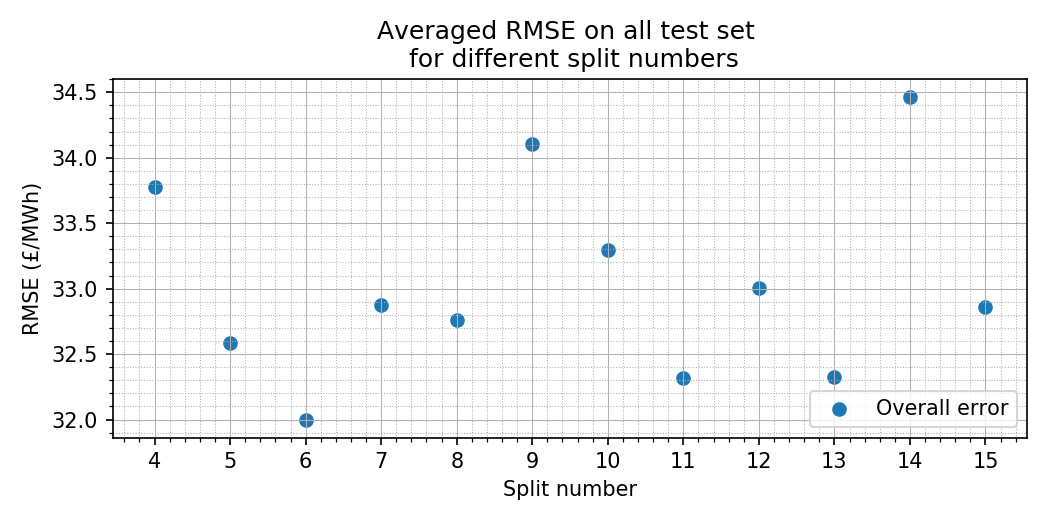

<IPython.core.display.Javascript object>


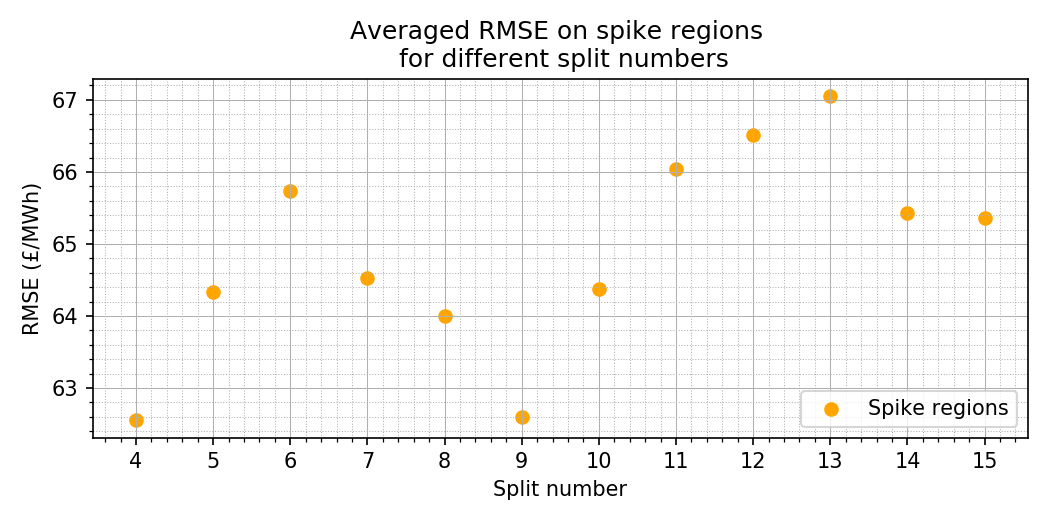

<IPython.core.display.Javascript object>


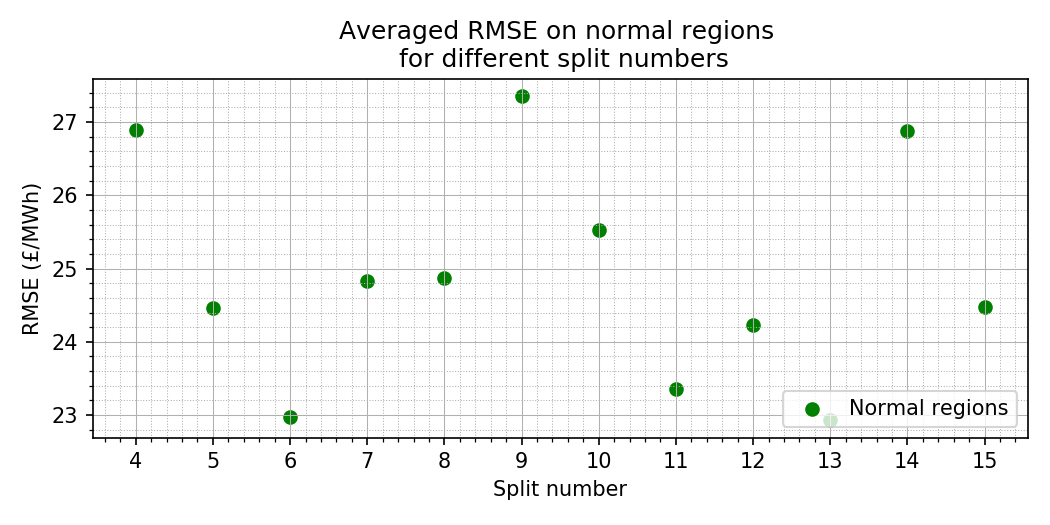

In [15]:
split_range = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE on all test set \n for different split numbers')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], y = rmse_gen, label = 'Overall error')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Split number')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], split_range)
plt.tight_layout()
plt.savefig('Split_number_2_all_RMSE.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE on spike regions \n for different split numbers')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], y =rmse_spi, label = 'Spike regions', color = 'orange')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Split number')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], split_range)
plt.tight_layout()
plt.savefig('Split_number_2_spike_RMSE.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE on normal regions \n for different split numbers')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], y =rmse_nor, label = 'Normal regions', color = 'green')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Split number')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], split_range)
plt.tight_layout()
plt.savefig('Split_number_2_nomal_RMSE.png')

<IPython.core.display.Javascript object>


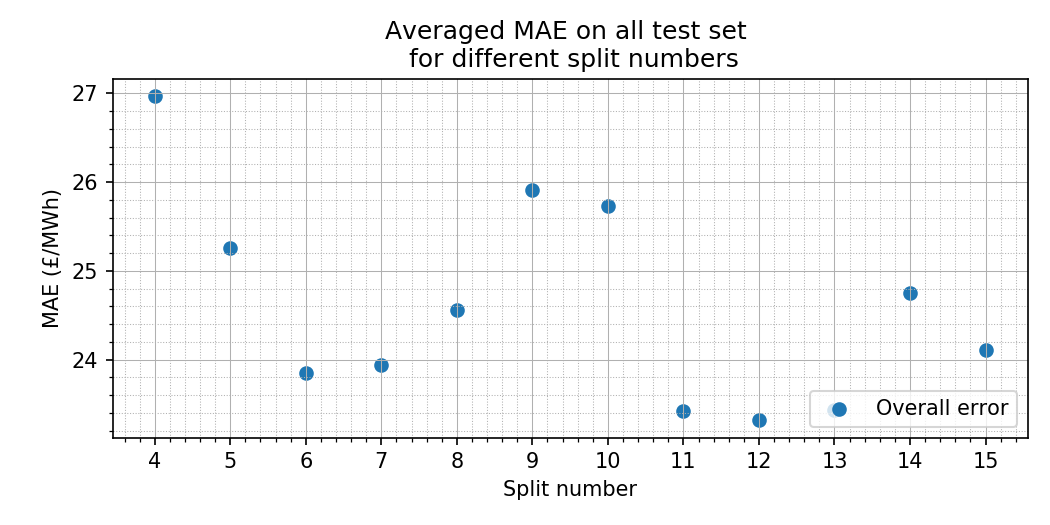

<IPython.core.display.Javascript object>


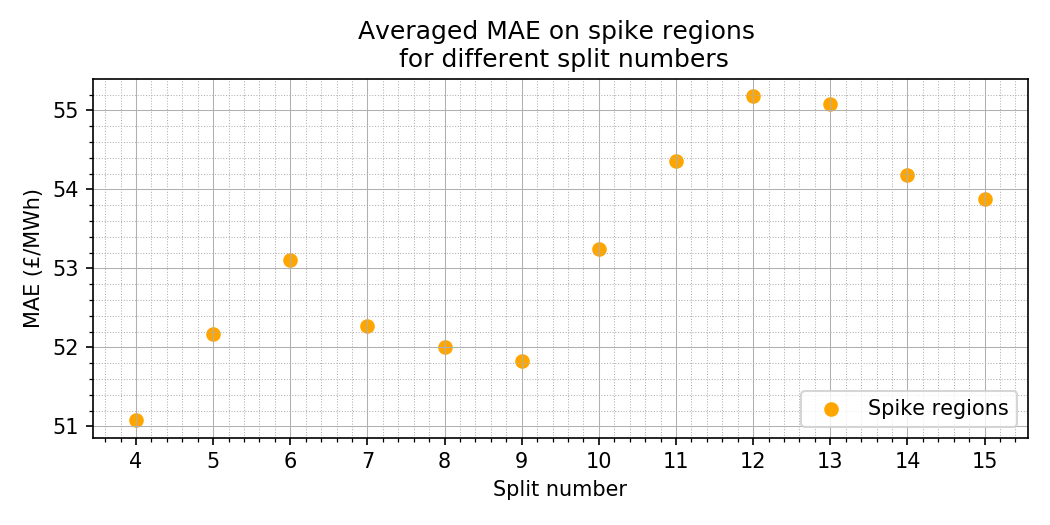

<IPython.core.display.Javascript object>


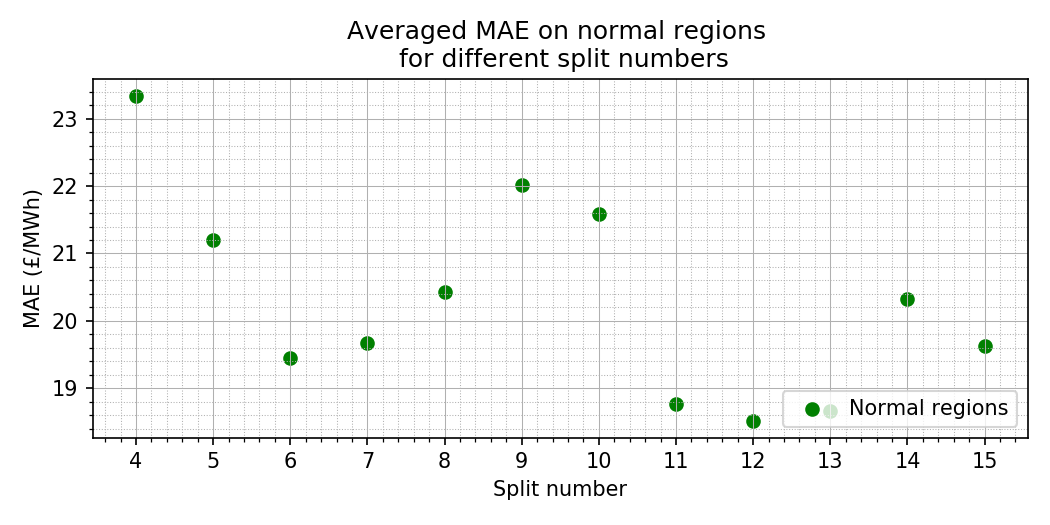

In [16]:
plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE on all test set \n for different split numbers')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], y = mae_gen, label = 'Overall error')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Split number')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], split_range)
plt.tight_layout()
plt.savefig('Split_number_2_all_MAE.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE on spike regions \n for different split numbers')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], y =mae_spi, label = 'Spike regions', color = 'orange')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Split number')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], split_range)
plt.tight_layout()
plt.savefig('Split_number_2_spike_MAE.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE on normal regions \n for different split numbers')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], y = mae_nor, label = 'Normal regions', color = 'green')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Split number')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], split_range)
plt.tight_layout()
plt.savefig('Split_number_2_normal_MAE.png')